In [2]:
import sys
print(sys.version)

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 18})
%config InlineBackend.rc = {}
%matplotlib inline

import numpy as np
import pandas as pd
import astropy
from astropy.io import fits
from tqdm import tqdm
import pickle

3.6.5 |Anaconda custom (64-bit)| (default, Mar 29 2018, 13:14:23) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [3]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [4]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Preparation for the cut

## Code 

In [5]:
def centering_algorithm(full_data,xinit,yinit,size_of_stamp):
    """!given the initial position, give a center of the image
    
    @param full_data        full science data image 
    @param xinit            x position of the initial guess 
    @param yinit            y position of the initial guess 
    @param size_of_stamp    size of the stamp that we wish to create
     """         
    
    
    
    # Iteration 0
    size_of_stamp_big=2*size_of_stamp
    xposmin=int(int(xinit)-size_of_stamp/2)
    xposmax=int(int(xinit)+size_of_stamp/2)
    yposmin=int(int(yinit)-size_of_stamp/2)
    yposmax=int(int(yinit)+size_of_stamp/2)
    print('0:'+str([yposmin,yposmax,xposmin,xposmax]))
    scidata_cut=full_data[yposmin:yposmax,xposmin:xposmax]
    med_pos=(int(np.round(np.median(np.where(np.any(scidata_cut>300, axis=1))))),
                    int(np.round(np.median(np.where(np.any(scidata_cut>300, axis=0))))))
    
    # Iteration 1
    new_xinit=xinit+med_pos[1]-size_of_stamp/2
    new_yinit=yinit+med_pos[0]-size_of_stamp/2
    xposmin=int(new_xinit-size_of_stamp/2)
    xposmax=int(new_xinit+size_of_stamp/2)
    yposmin=int(new_yinit-size_of_stamp/2)
    yposmax=int(new_yinit+size_of_stamp/2)
    print('1:'+str([yposmin,yposmax,xposmin,xposmax]))
    scidata_cut=full_data[yposmin:yposmax,xposmin:xposmax]
    
    
    # iteration 2
    centroid_of_flux_model=find_centroid_of_flux(scidata_cut)
    # print(centroid_of_flux_model)

    centroid_of_flux_model_int=np.array(map(int,map(np.round,centroid_of_flux_model)))
    dif_centroid_of_flux_model_int_from_center=np.array(centroid_of_flux_model)-np.array([int(size_of_stamp/2),int(size_of_stamp/2)])

    xposmin=int(np.round(xposmin+dif_centroid_of_flux_model_int_from_center[0]))
    xposmax=int(np.round(xposmax+dif_centroid_of_flux_model_int_from_center[0]))
    yposmin=int(np.round(yposmin+dif_centroid_of_flux_model_int_from_center[1]))
    yposmax=int(np.round(yposmax+dif_centroid_of_flux_model_int_from_center[1]))


    print('2:'+str([yposmin,yposmax,xposmin,xposmax]))
    scidata_cut=full_data[yposmin:yposmax,xposmin:xposmax]
    
    # iteration 3
    centroid_of_flux_model=find_centroid_of_flux(scidata_cut)
    # print(centroid_of_flux_model)

    centroid_of_flux_model_int=np.array(map(int,map(np.round,centroid_of_flux_model)))
    dif_centroid_of_flux_model_int_from_center=np.array(centroid_of_flux_model)-np.array([int(size_of_stamp/2),int(size_of_stamp/2)])

    xposmin=int(np.round(xposmin+dif_centroid_of_flux_model_int_from_center[0]))
    xposmax=int(np.round(xposmax+dif_centroid_of_flux_model_int_from_center[0]))
    yposmin=int(np.round(yposmin+dif_centroid_of_flux_model_int_from_center[1]))
    yposmax=int(np.round(yposmax+dif_centroid_of_flux_model_int_from_center[1]))

    print('3:'+str([yposmin,yposmax,xposmin,xposmax]))
    scidata_cut=full_data[yposmin:yposmax,xposmin:xposmax]
    return [xposmin+size_of_stamp/2,yposmin+size_of_stamp/2]

def find_centroid_of_flux(image):
    """
    function giving the position of weighted average of the flux in a square image
    
    @param allparameters_proposal    array contaning suggested starting values for a model 
    """
    
    
    x_center=[]
    y_center=[]

    I_x=[]
    for i in range(len(image)):
        I_x.append([i,np.sum(image[:,i])])

    I_x=np.array(I_x)

    I_y=[]
    for i in range(len(image)):
        I_y.append([i,np.sum(image[i])])

    I_y=np.array(I_y)


    x_center=(np.sum(I_x[:,0]*I_x[:,1])/np.sum(I_x[:,1]))
    y_center=(np.sum(I_y[:,0]*I_y[:,1])/np.sum(I_y[:,1]))

    return(x_center,y_center)

import numpy as np
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

## Loading (finalHgArFeb2019 and finalNeonFeb2019, scidata, dataframes)

In [5]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Dataframes/finalNe_Feb2019.pkl', 'rb') as f:
    finalNe_Feb2019=pickle.load(f)
    
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Dataframes/finalHgAr_Feb2019.pkl', 'rb') as f:
    finalHgAr_Feb2019=pickle.load(f)

In [10]:
sci_data_HgAr=fits.open('/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/rerun/rerun_1/detrend/calExp/2019-05-06/v0017071/calExp-LA017071r1.fits')[1].data
sci_data_Ne=fits.open('/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/rerun/rerun_1/detrend/calExp/2019-04-17/v0016292/calExp-LA016292r1.fits')[1].data
sci_data_Kr=fits.open('/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/rerun/rerun_1/detrend/calExp/2019-05-08/v0017647/calExp-LA017647r1.fits')[1].data
sci_data_Xe=fits.open('/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/rerun/rerun_1/detrend/calExp/2019-05-08/v0017533/calExp-LA017533r1.fits')[1].data


In [86]:
dm_00=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/May_2019_calibs/DETECTORMAP/pfsDetectorMap-000000-r1.fits')
dm_HgAr=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/May_2019_calibs/DETECTORMAP/pfsDetectorMap-017071-r1.fits')
dm_Ne=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/May_2019_calibs/DETECTORMAP/pfsDetectorMap-016292-r1.fits')
dm_Kr=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/May_2019_calibs/DETECTORMAP/pfsDetectorMap-017647-r1.fits')
dm_Xe=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/May_2019_calibs/DETECTORMAP/pfsDetectorMap-017533-r1.fits')

In [27]:
claimed_fiber_Ids=[650,589,527,466,403,341,257,194,65,4]

In [219]:
# the ones which goes to 599
claimed_fiber_science_Ids=[]
for i in range(len(claimed_fiber_Ids)):
    claimed_fiber_science_Ids.append(list(dm_00[1].data).index(claimed_fiber_Ids[i]))
    
claimed_fiber_science_Ids=np.array(claimed_fiber_science_Ids)
claimed_fiber_science_Ids

array([599, 540, 481, 425, 364, 304, 243, 182,  61,   2])

In [220]:
def findPoint_fake(science_fiber_Id,v,dm):
    # science_fiber_Id - number which goes to 599
    # v - wavelength
    #
    arr=(dm[4].data)[dm[4].data['index']==science_fiber_Id]['value']
    idx = (np.abs(arr - v)).argmin()
    # fiber, y, wavelength
    fiber_y_wavelength=(dm[4].data)[dm[4].data['index']==science_fiber_Id][idx]
    y_value=fiber_y_wavelength[1]

    arr=(dm[3].data)[dm[3].data['index']==science_fiber_Id]['knot']
    v=y_value
    idx = (np.abs(arr - v)).argmin()

    fiber_y_x=(dm[3].data)[dm[3].data['index']==science_fiber_Id][idx]
    x_value=fiber_y_x[2]

    return [x_value,y_value]

## updating HgAr

In [487]:
HgAr_wavelengths=np.unique(finalHgAr_Feb2019['wavelength'].values).astype(float)

In [488]:
fibers_all_pos=[]
for f in claimed_fiber_science_Ids:
    res=[]
    for i in range(len(HgAr_wavelengths)):
        res.append(findPoint_fake(f,HgAr_wavelengths[i],dm_Ne))

    fiber_single_initial_pos=res
    fibers_all_pos.append(fiber_single_initial_pos)

In [489]:
fibers_dx=[10,-2,-2,-3,-2,-2,-2,-2,-2,-2]
fibers_dy=[5,6,4,4,4,4,4,4,5,4]

In [490]:
size=20
test_sci_cuts=[]
fiber_to_10_int=9

for image_pos in fibers_all_pos[fiber_to_10_int]:
    test_sci_cuts.append(sci_data_HgAr[int(image_pos[1]-fibers_dy[fiber_to_10_int]-size):int(image_pos[1]-fibers_dy[fiber_to_10_int]+size),int(image_pos[0]-fibers_dx[fiber_to_10_int])-size:int(image_pos[0]-fibers_dx[fiber_to_10_int]+size)])

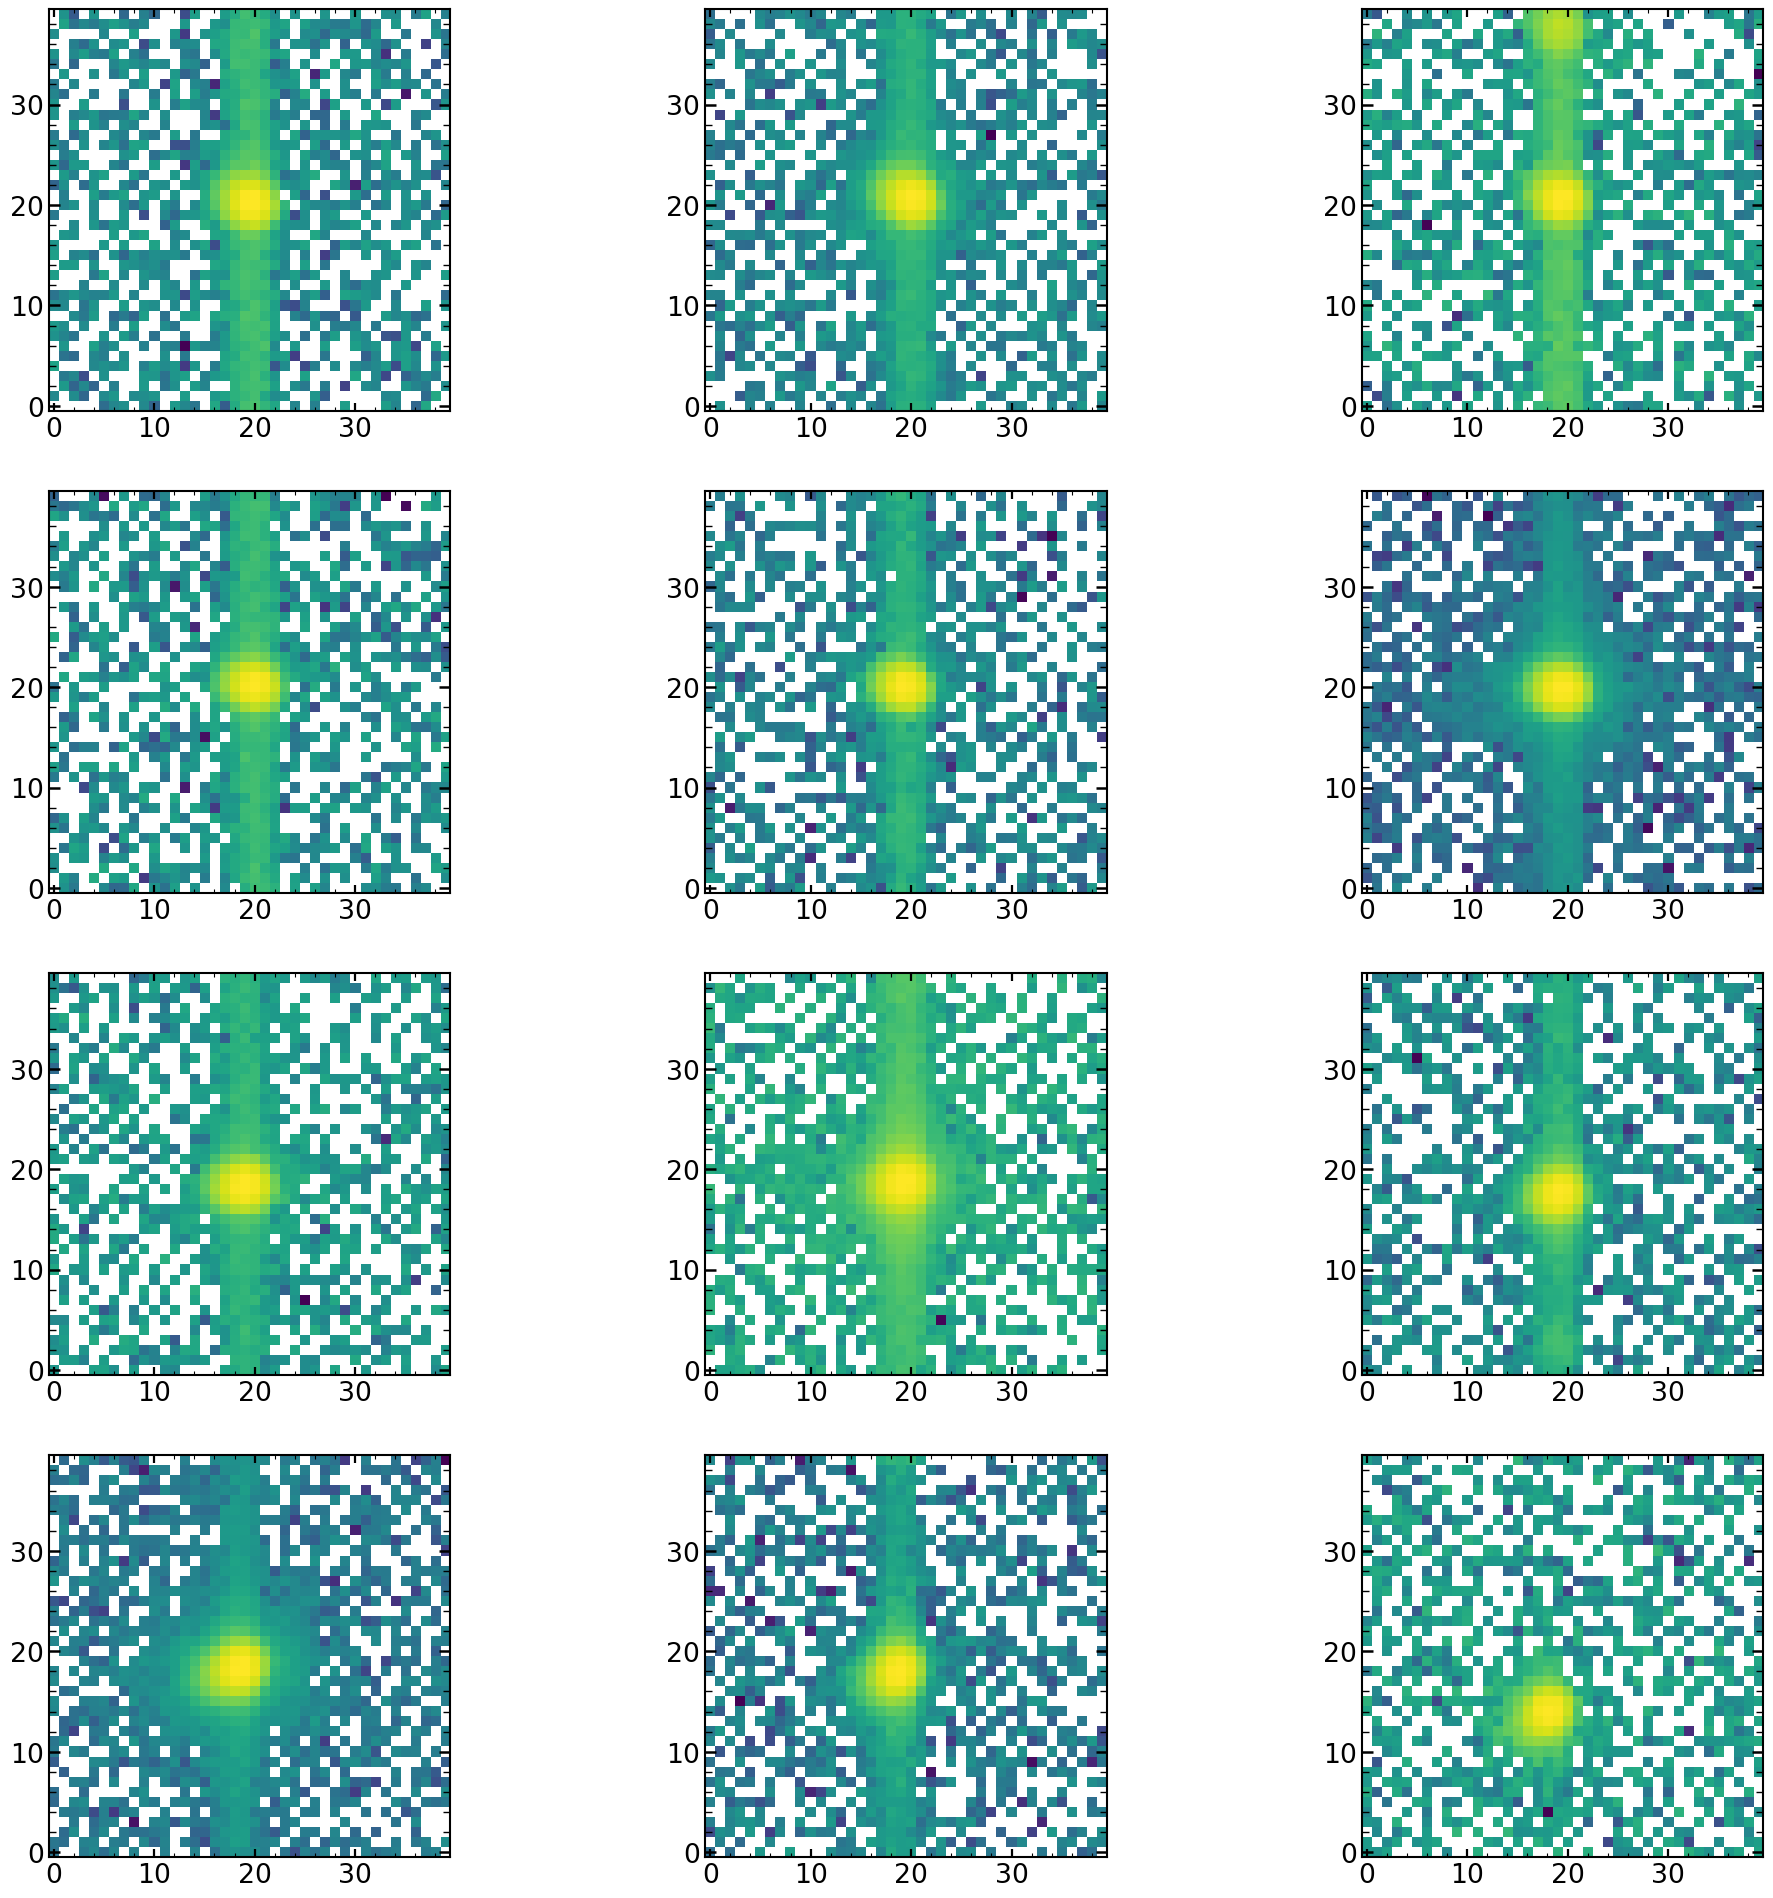

In [491]:
plt.figure(figsize=(24,24))
plt.subplot(431)
plt.imshow(test_sci_cuts[0],norm=LogNorm())

plt.subplot(432)
plt.imshow(test_sci_cuts[1],norm=LogNorm())

plt.subplot(433)
plt.imshow(test_sci_cuts[2],norm=LogNorm())

plt.subplot(434)
plt.imshow(test_sci_cuts[3],norm=LogNorm())

plt.subplot(435)
plt.imshow(test_sci_cuts[4],norm=LogNorm())

plt.subplot(436)
plt.imshow(test_sci_cuts[5],norm=LogNorm())

plt.subplot(437)
plt.imshow(test_sci_cuts[6],norm=LogNorm())

plt.subplot(438)
plt.imshow(test_sci_cuts[7],norm=LogNorm())

plt.subplot(439)
plt.imshow(test_sci_cuts[8],norm=LogNorm())

plt.subplot(4,3,10)
plt.imshow(test_sci_cuts[9],norm=LogNorm())

plt.subplot(4,3,11)
plt.imshow(test_sci_cuts[10],norm=LogNorm())

plt.subplot(4,3,12)
plt.imshow(test_sci_cuts[11],norm=LogNorm())


In [492]:
finalHgAr_May2019=finalHgAr_Feb2019.copy()
finalHgAr_May2019=finalHgAr_May2019[0:12*10]

In [493]:
fibers_all_pos[0]

[[79.139465, 813.0],
 [79.57726, 880.0],
 [80.37182, 997.0],
 [81.65243, 1234.0],
 [82.36661, 1363.0],
 [83.125244, 1652.0],
 [83.37578, 2014.0],
 [82.92998, 2382.0],
 [82.005455, 2684.0],
 [76.81711, 3400.0],
 [75.58311, 3522.0],
 [69.0793, 4049.0]]

In [494]:
for f in range(10):
    (finalHgAr_May2019.loc[finalHgAr_May2019['fiber']==str(f),'xc'])=np.array(fibers_all_pos[f])[:,0].astype(int)-fibers_dx[f]
    (finalHgAr_May2019.loc[finalHgAr_May2019['fiber']==str(f),'yc'])=np.array(fibers_all_pos[f])[:,1].astype(int)-fibers_dy[f]

In [495]:
xc_effective_preparation=np.copy(finalHgAr_May2019['xc'].values)
xc_effective_preparation[xc_effective_preparation>2048]=xc_effective_preparation[xc_effective_preparation>2048]+69
finalHgAr_May2019['xc_effective']=xc_effective_preparation

In [496]:
# do fiber now 
# deduced from the fact that May data is done with 1099528409104 ['green', 'red1', 'red4', 'red8']
# February data was done with 4296015889 ['blue', 'green', 'red3', 'red6']
# https://github.com/Subaru-PFS/drp_stella/blob/master/bin.src/makeLamDesign.py#L11-L30
May_configuration_of_fibers=[2,63,192,255,339,401,464,525,587,650]
fiber_number_list=[]
for j in range(len(May_configuration_of_fibers)):
    for i in range(12):
        fiber_number_list.append(May_configuration_of_fibers[j])
        
fiber_number_array=np.array(fiber_number_list)

finalHgAr_May2019['fiber']=fiber_number_array


### one would probably want to update old_index_approx in order to connect with February data

In [497]:
finalHgAr_May2019

,fiber,xc,yc,wavelength,close,lamp,xc_effective,old_index_approx,superold_index_approx
0,2,69,808,690.9346,0,HgAr,69,0,nan
1,2,69,875,696.7261,1,HgAr,69,1,90.0
2,2,70,992,706.8989,0,HgAr,70,2,nan
3,2,71,1229,727.47876,1,HgAr,71,3,nan
4,2,72,1358,738.6248,0,HgAr,72,4,80.0
5,2,73,1647,763.74286,0.5,HgAr,73,5,70.0
6,2,73,2009,795.0522,1,HgAr,73,6,50.0
7,2,72,2377,826.6699,0.5,HgAr,72,7,40.0
8,2,72,2679,852.4029,0.5,HgAr,72,8,30.0
9,2,66,3395,912.5693,1,HgAr,66,9,20.0


In [498]:
finalHgAr_May2019.to_pickle('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_May2019.pkl')

## updating Neon

In [422]:
Ne_wavelengths=np.unique(finalNe_Feb2019['wavelength'].values).astype(float)

In [423]:
fibers_all_pos=[]
for f in claimed_fiber_science_Ids:
    res=[]
    for i in range(len(Ne_wavelengths)):
        res.append(findPoint_fake(f,Ne_wavelengths[i],dm_Ne))

    fiber_single_initial_pos=res
    fibers_all_pos.append(fiber_single_initial_pos)

In [424]:
fibers_dx=[6,-5,-5,-5,-5,-5,-5,-5,-5,-5]
fibers_dy=[5,3,4,4,4,4,2,4,5,3]

In [425]:
size=20
test_sci_cuts=[]
fiber_to_10_int=9

for image_pos in fibers_all_pos[fiber_to_10_int]:
    test_sci_cuts.append(sci_data_Ne[int(image_pos[1]-fibers_dy[fiber_to_10_int]-size):int(image_pos[1]-fibers_dy[fiber_to_10_int]+size),int(image_pos[0]-fibers_dx[fiber_to_10_int])-size:int(image_pos[0]-fibers_dx[fiber_to_10_int]+size)])

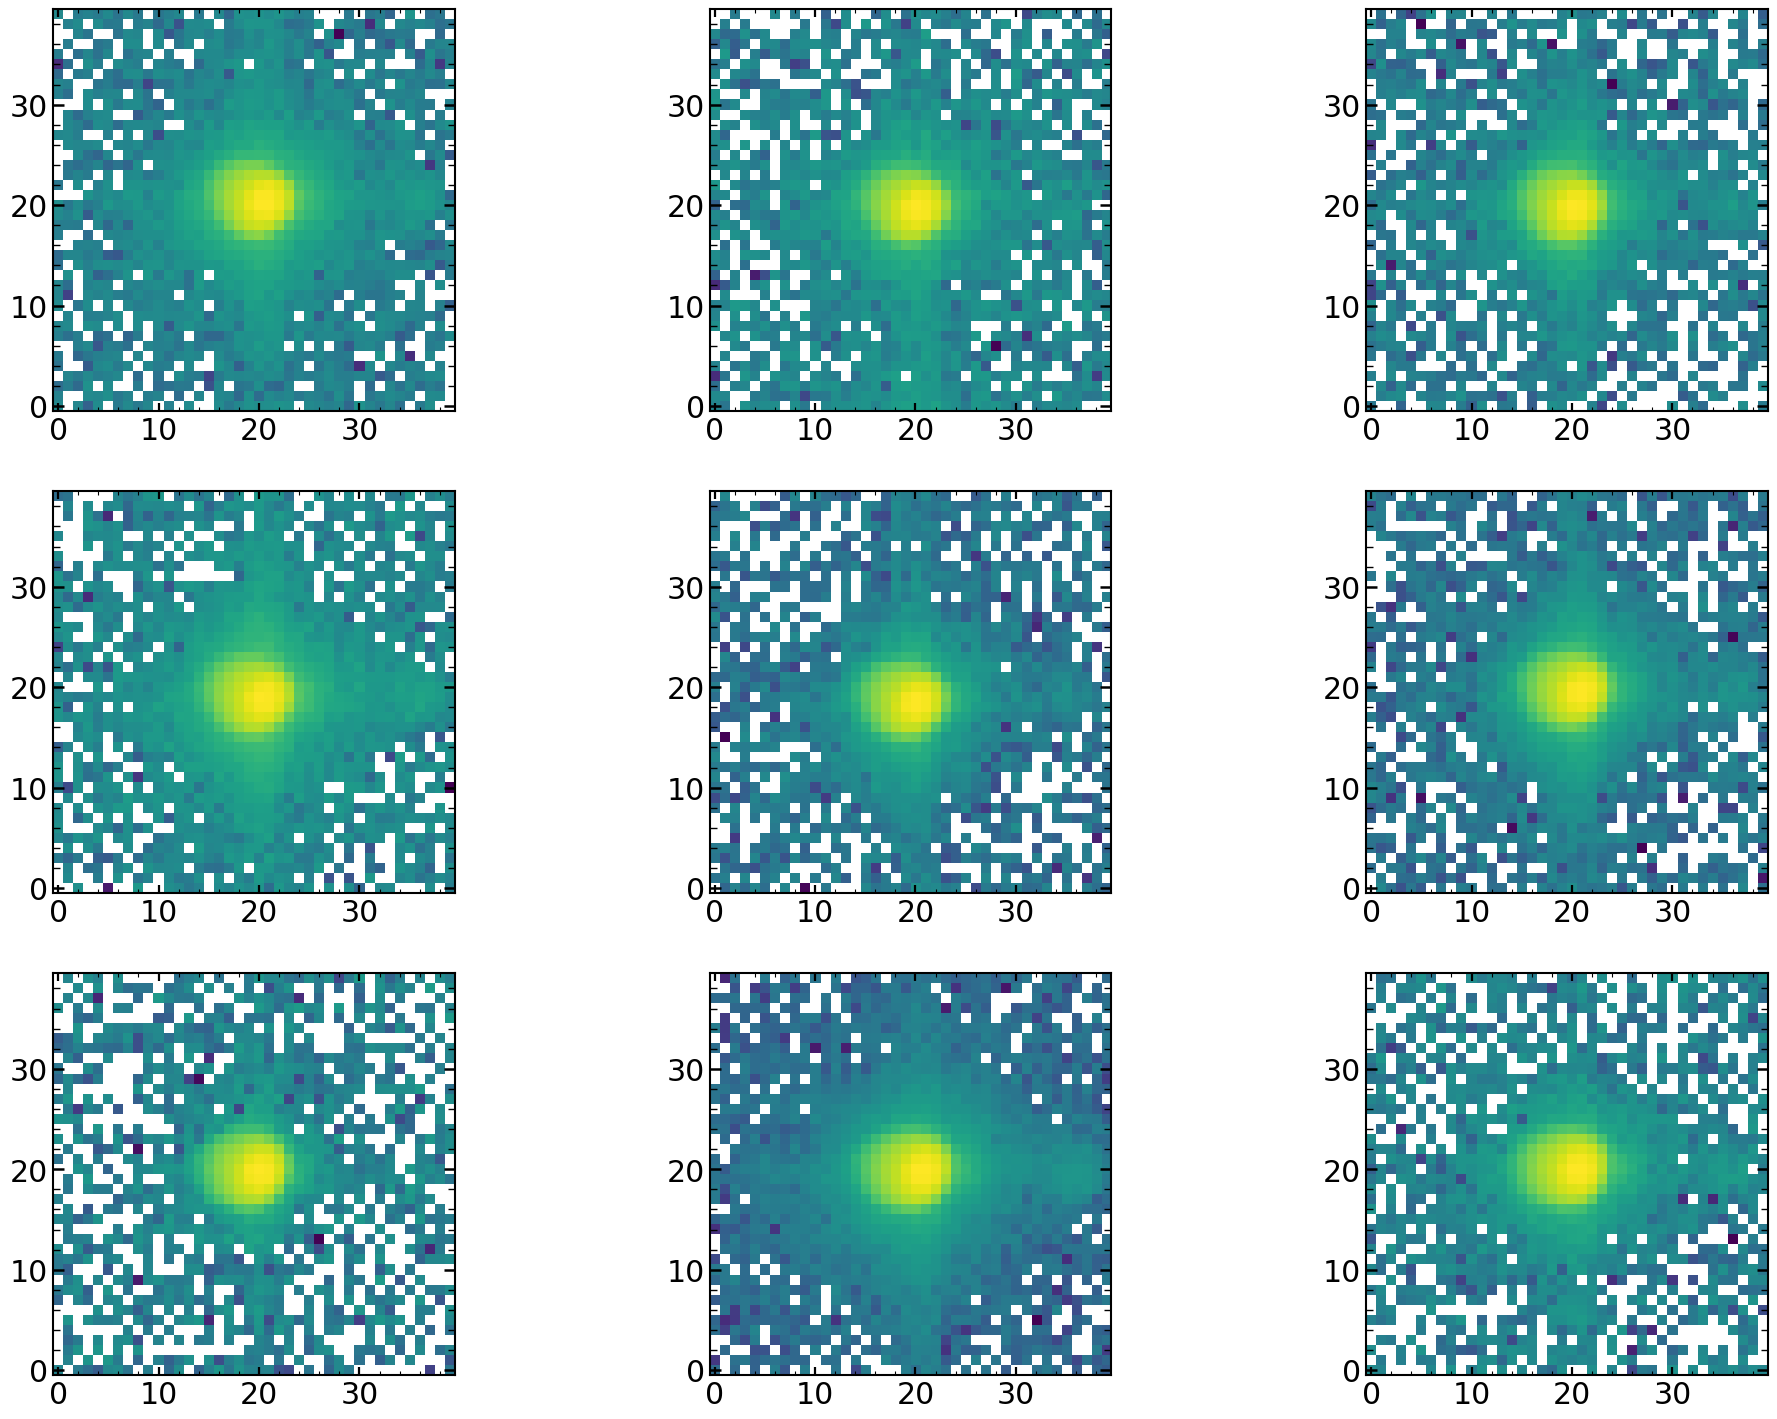

In [426]:
plt.figure(figsize=(24,24))
plt.subplot(431)
plt.imshow(test_sci_cuts[0],norm=LogNorm())

plt.subplot(432)
plt.imshow(test_sci_cuts[1],norm=LogNorm())

plt.subplot(433)
plt.imshow(test_sci_cuts[2],norm=LogNorm())

plt.subplot(434)
plt.imshow(test_sci_cuts[3],norm=LogNorm())

plt.subplot(435)
plt.imshow(test_sci_cuts[4],norm=LogNorm())

plt.subplot(436)
plt.imshow(test_sci_cuts[5],norm=LogNorm())

plt.subplot(437)
plt.imshow(test_sci_cuts[6],norm=LogNorm())

plt.subplot(438)
plt.imshow(test_sci_cuts[7],norm=LogNorm())

plt.subplot(439)
plt.imshow(test_sci_cuts[8],norm=LogNorm())


In [429]:
# copy old dataframe
# copy only enough space to fill with 10 fibers
# so in this case 10 * 10
finalNe_May2019=finalNe_Feb2019.copy()
finalNe_May2019=finalNe_May2019[0:10*10]

In [430]:
finalNe_May2019

,fiber,xc,yc,wavelength,close,lamp,xc_effective,old_index_approx,superold_index_approx
0,0,255,346,650.84186,0,Ne,255,0,nan
1,0,255,376,653.4774,0,Ne,255,1,nan
2,0,256,452,660.0668,1,Ne,256,2,nan
3,0,257,543,668.01764,0,Ne,257,3,nan
4,0,257,587,671.9268,0,Ne,257,4,nan
5,0,259,831,693.13116,1,Ne,259,5,nan
6,0,261,1111,717.59015,1,Ne,261,6,nan
7,0,261,1193,724.72437,1,Ne,261,7,nan
8,0,262,1416,744.1276,0,Ne,262,8,nan
9,1,467,339,650.84186,0,Ne,467,9,nan


In [431]:
# update with new positions 
for f in range(10):
    (finalNe_May2019.loc[finalNe_May2019['fiber']==str(f),'xc'])=np.array(fibers_all_pos[f])[:,0].astype(int)-fibers_dx[f]
    (finalNe_May2019.loc[finalNe_May2019['fiber']==str(f),'yc'])=np.array(fibers_all_pos[f])[:,1].astype(int)-fibers_dy[f]

In [432]:
# update effective positions
xc_effective_preparation=np.copy(finalNe_May2019['xc'].values)
xc_effective_preparation[xc_effective_preparation>2048]=xc_effective_preparation[xc_effective_preparation>2048]+69
finalNe_May2019['xc_effective']=xc_effective_preparation

In [433]:
# do fiber now 
# deduced from the fact that May data is done with 1099528409104 ['green', 'red1', 'red4', 'red8']
# February data was done with 4296015889 ['blue', 'green', 'red3', 'red6']
# https://github.com/Subaru-PFS/drp_stella/blob/master/bin.src/makeLamDesign.py#L11-L30
May_configuration_of_fibers=[2,63,192,255,339,401,464,525,587,650]
fiber_number_list=[]
for j in range(len(May_configuration_of_fibers)):
    # number of spots for fiber here - different than for other arcs
    for i in range(10):
        fiber_number_list.append(May_configuration_of_fibers[j])
        
fiber_number_array=np.array(fiber_number_list)

finalNe_May2019['fiber']=fiber_number_array


### one would probably want to update old_index_approx in order to connect with February data

In [442]:
finalNe_May2019.to_pickle('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_May2019.pkl')


# checking background 

In [ ]:
# Ok, I have two approaches - doing sigma clipping and looking at the area without any sources

In [ ]:
## Looking at the area without any sources 

In [437]:
background_estimate=[]
for run in tqdm(range(17017,17130,1)):
    data=fits.open('/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/rerun/rerun_1/detrend/calExp/2019-05-06/v00'+str(run)+'/calExp-LA0'+str(run)+'r1.fits')
    res=np.mean(data[1].data[1250:2880,3060:3140])
    background_estimate.append([data[0].header['W_ENFCAX'],res])
    
background_estimate_direct_narrow=np.array(background_estimate)

100%|██████████| 113/113 [02:21<00:00,  1.25s/it]


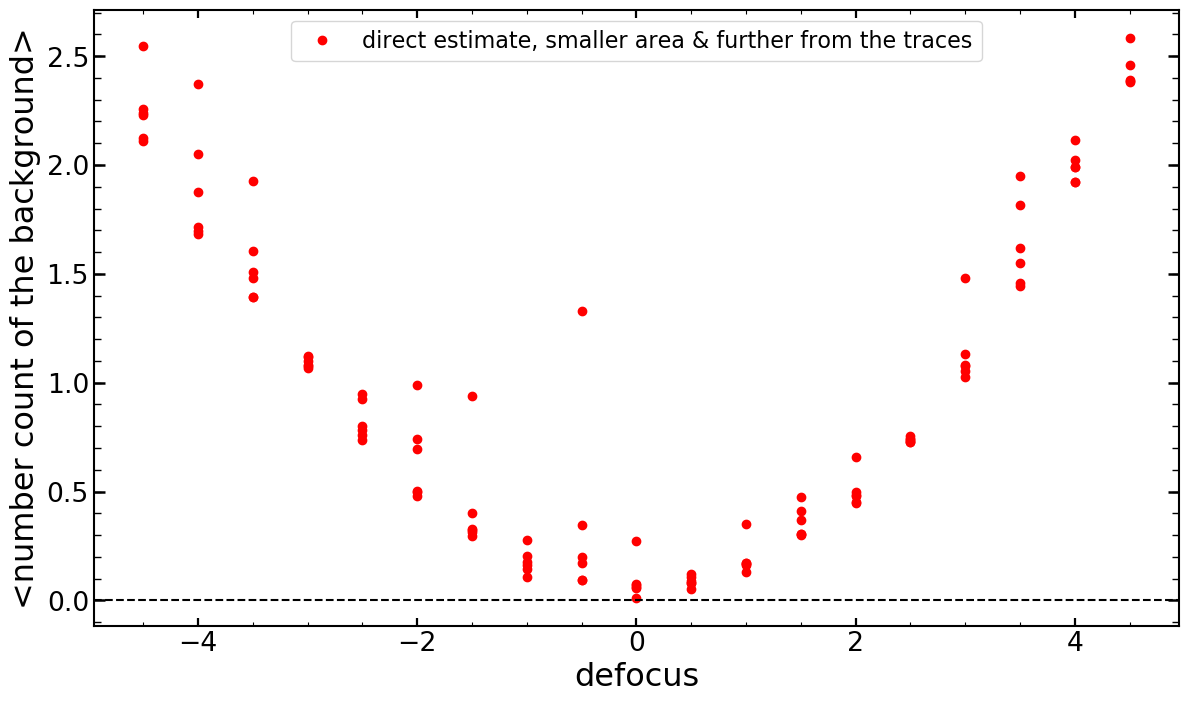

In [438]:
matplotlib.rcParams.update({'font.size': 16})
plt.figure(figsize=(14,8))
plt.plot(background_estimate_direct_narrow[:,0],background_estimate_direct_narrow[:,1],marker='o',ls='',color='red',label='direct estimate, smaller area & further from the traces')
plt.axhline(y=0,ls='--',color='black')
plt.xlabel('defocus')
plt.ylabel('<number count of the background>')
plt.legend()

In [ ]:
# seems relativly low - lets ignore it

# Actual cutting of the data

In [7]:
from astropy import stats

In [8]:
defocus_values=[-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0.5,+1,1.5,2,2.5,3,3.5,4,4.5]
sizes_of_stamps=np.array([60, 60, 50, 40, 30, 30, 24, 20, 20, 20, 24, 30, 30, 40, 50, 60,
       60, 70])

## Test - small

In [9]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_May2019.pkl', 'rb') as f:
    finalHgAr_May2019=pickle.load(f)

In [10]:
image_index=102
run=17071-6
DATA_FOLDER='/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/rerun/rerun_1/detrend/calExp/2019-05-06/'

data=fits.open(DATA_FOLDER+'/v00'+str(run+0)+'/calExp-LA0'+str(run+0)+'r1.fits')
scidata=np.zeros_like(data[1].data)
maskdata=np.zeros_like(scidata)
vardata=np.zeros_like(scidata)  

for i in range(5):
    data=fits.open(DATA_FOLDER+'v00'+str(run+i)+'/calExp-LA0'+str(run+i)+'r1.fits')
    # round it a bit because sometimes the values are off by like 0.00001
    exposure_defocus=np.round(data[0].header['W_ENFCAX'],2)
    scidata_single=data[1].data
    maskdata_single=data[2].data
    vardata_single=data[3].data
    scidata=scidata+scidata_single
    maskdata=maskdata+maskdata_single
    vardata=vardata+vardata_single

In [11]:
center_pos=[int(np.array(finalHgAr_May2019.loc[image_index,['xc','yc']].values)[0]),int(np.array(finalHgAr_May2019.loc[image_index,['xc','yc']].values)[1])]
print('Central position of the spot '+str(image_index)+' is: '+str(center_pos))
size=sizes_of_stamps[defocus_values==exposure_defocus]
size_of_stamp=size

Central position of the spot 102 is: [3623, 1994]


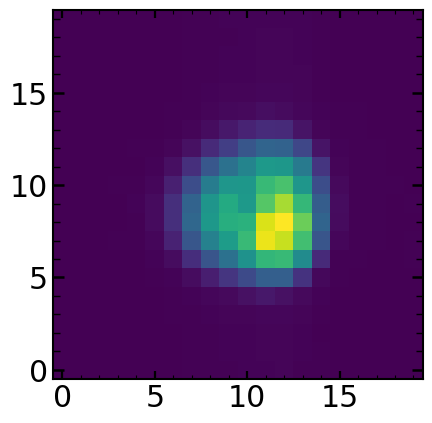

In [12]:
# just to test
scidata_cut=scidata[int(center_pos[1]-size_of_stamp/2):int(center_pos[1]+size_of_stamp/2),int(center_pos[0]-size_of_stamp/2):int(center_pos[0]+size_of_stamp/2)]
plt.imshow(scidata_cut)

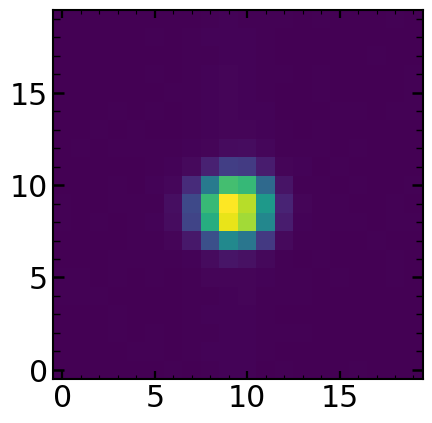

In [13]:
# Test focus
sci_data_HgAr=fits.open('/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/rerun/rerun_1/detrend/calExp/2019-05-06/v0017071/calExp-LA017071r1.fits')[1].data

sci_data_HgAr_cut=sci_data_HgAr[int(center_pos[1]-size_of_stamp/2):int(center_pos[1]+size_of_stamp/2),int(center_pos[0]-size_of_stamp/2):int(center_pos[0]+size_of_stamp/2)]
plt.imshow(sci_data_HgAr_cut)

## Test - together with old continuum removal 

In [533]:
image_index=55

run=17071
DATA_FOLDER='/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/rerun/rerun_1/detrend/calExp/2019-05-06/'

data=fits.open(DATA_FOLDER+'/v00'+str(run+0)+'/calExp-LA0'+str(run+0)+'r1.fits')
scidata=np.zeros_like(data[1].data)
maskdata=np.zeros_like(scidata)
vardata=np.zeros_like(scidata)  

for i in range(5):
    data=fits.open(DATA_FOLDER+'v00'+str(run+i)+'/calExp-LA0'+str(run+i)+'r1.fits')
    # round it a bit because sometimes the values are off by like 0.00001
    exposure_defocus=np.round(data[0].header['W_ENFCAX'],2)
    scidata_single=data[1].data
    maskdata_single=data[2].data
    vardata_single=data[3].data
    scidata=scidata+scidata_single
    maskdata=maskdata+maskdata_single
    vardata=vardata+vardata_single

# set the dataframe used here 
finalHgAr=finalHgAr_May2019

# central position as deduced from focused images
center_pos=[int(np.array(finalHgAr.loc[image_index,['xc','yc']].values)[0]),int(np.array(finalHgAr.loc[image_index,['xc','yc']].values)[1])]
print('Central position of the spot '+str(image_index)+' is: '+str(center_pos))


# have to set manually if in focus
if run==17071:
    size=20
else:
    size=sizes_of_stamps[defocus_values==exposure_defocus]
size_of_stamp=size

center_pos_new=centering_algorithm(scidata,center_pos[0],center_pos[1],size_of_stamp)

#xposmin=int(np.round(center_pos_new[0]-size-10))
#xposmax=int(np.round(center_pos_new[0]+size+10))
#yposmin=int(np.round(center_pos_new[1]-size-45))
#yposmax=int(np.round(center_pos_new[1]+size+45))

xposmin=int(np.round(center_pos_new[0]-70-10))
xposmax=int(np.round(center_pos_new[0]+70+10))
yposmin=int(np.round(center_pos_new[1]-70-45))
yposmax=int(np.round(center_pos_new[1]+70+45))

size_of_stamp
#print(xposmin,xposmax,yposmin,yposmax)

# if you are on the edge, stop at the edge
if xposmin<0:
    xposmin=0
if xposmax>4096:
    xposmax=4096

scidata_cut=scidata[yposmin:yposmax,xposmin:xposmax]
maskdata_cut=maskdata[yposmin:yposmax,xposmin:xposmax]
vardata_cut=vardata[yposmin:yposmax,xposmin:xposmax]

scidata_cut_original=np.copy(scidata_cut)

#################
# removal of continuum - estimating
#################

# estimating local background
sci_upper_cut=scidata_cut[len(scidata_cut[:,0])-70:len(scidata_cut[:,0])-5]
sci_lower_cut=scidata_cut[5:70]

overall_median_lower_left=stats.sigma_clipped_stats(sci_lower_cut[:,:25].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
overall_median_lower_right=stats.sigma_clipped_stats(sci_lower_cut[:,:-25:].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
overall_median_upper_left=stats.sigma_clipped_stats(sci_upper_cut[:,:25].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
overall_median_upper_right=stats.sigma_clipped_stats(sci_upper_cut[:,:-25:].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
list_of_medians=[overall_median_lower_left,overall_median_lower_right,overall_median_upper_left,overall_median_upper_right]
overall_median=np.array(list_of_medians)[np.abs(list_of_medians)==np.min(np.abs(list_of_medians))][0]
print('overall_median is: '+str(overall_median))

scidata_cut_median_subtracted=scidata_cut-overall_median
scidata_cut_original_median_subtracted=np.copy(scidata_cut_median_subtracted)

if finalHgAr.loc[image_index]['wavelength']=='690.9346':
    init_lower_limit=40
    init_upper_limit=65
    lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
    upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr.loc[image_index]['wavelength']=='696.7261':
    init_lower_limit=50
    init_upper_limit=65
    lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
    upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr.loc[image_index]['wavelength']=='706.8989':
    init_lower_limit=20
    init_upper_limit=60    
    lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
    upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr.loc[image_index]['wavelength']=='727.47876':
    init_lower_limit=20
    init_upper_limit=60
    lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
    upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr.loc[image_index]['wavelength']=='738.6248':
    init_lower_limit=20
    init_upper_limit=55  
    lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
    upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2]))
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr.loc[image_index]['wavelength']=='763.74286':
    init_lower_limit=0
    init_upper_limit=30   
    lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
    upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr.loc[image_index]['wavelength']=='795.0522':
    init_lower_limit=30
    init_upper_limit=70
    lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
    upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2]))  
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr.loc[image_index]['wavelength']=='826.6699':
    init_lower_limit=0
    init_upper_limit=30     
    lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
    upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr.loc[image_index]['wavelength']=='852.4029':
    init_lower_limit=30
    init_upper_limit=55
    lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
    upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr.loc[image_index]['wavelength']=='912.5693':
    init_lower_limit=30
    init_upper_limit=50   
    lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
    upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2]))
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr.loc[image_index]['wavelength']=='922.7301':
    init_lower_limit=30
    init_upper_limit=55
    lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
    upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr.loc[image_index]['wavelength']=='966.0642':
    init_lower_limit=35
    init_upper_limit=65      
    lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
    upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
    
    
# estimating continuum
sci_upper_cut=scidata_cut_median_subtracted[len(scidata_cut[:,0])-upper_limit:len(scidata_cut[:,0])-lower_limit]
sci_lower_cut=scidata_cut_median_subtracted[lower_limit:upper_limit]
midpoint=scidata_cut_median_subtracted.shape[0]/2
sci_central_cut=scidata_cut_median_subtracted[int(midpoint-size/2):int(midpoint+size/2)]
mask_central_cut=maskdata_cut[int(midpoint-size/2):int(midpoint+size/2)]
sci_central_cut_masked= np.ma.array(sci_central_cut, mask=mask_central_cut)
fiber_profile=np.ma.mean(sci_central_cut_masked,axis=0)

res=[]
#res_upper=[]
res_upper_all_values=[]
#res_lower=[]
res_lower_all_values=[]
for j in range(scidata_cut.shape[1]):
    value=np.median(sci_lower_cut[:,j])     
    res_lower_all_values.append(value)
    value=np.median(sci_upper_cut[:,j])     
    res_upper_all_values.append(value)


res_upper_all_values=np.array(res_upper_all_values)
res_lower_all_values=np.array(res_lower_all_values)

# esnures that you do not oversubtract in the middle
#res_upper[res_upper>0]=res_upper[res_upper>0]-np.median(np.array(res_upper_all_values))
#res_lower[res_lower>0]=res_lower[res_lower>0]-np.median(np.array(res_lower_all_values))

res_upper_multi=np.median(fiber_profile[fiber_profile>500]/res_upper_all_values[fiber_profile>500])
res_lower_multi=np.median(fiber_profile[fiber_profile>500]/res_lower_all_values[fiber_profile>500])

res_upper=(fiber_profile/res_upper_multi)*0.995
res_lower=(fiber_profile/res_lower_multi)*0.995

if float(finalHgAr.loc[image_index]['wavelength'])<950:
    # if there is another source in upper part, override it with lower half
    print('sum_lower over sum_upper: '+str(res_lower_multi/res_upper_multi))
    print('sum_lower over sum_upper: '+str(res_upper_multi/res_lower_multi))
    if res_upper_multi/res_lower_multi<1/1.05:
        print('overwritting upper with lower')
        res_upper=res_lower

    # if there is another source in lower part, override it with upper half
    elif res_lower_multi/res_upper_multi<1/1.05:
        print('overwritting lower with upper')
        res_lower=res_upper

#################
# removal of continuum - actual removal
#################
scidata_cut_large_removed=scidata_cut_median_subtracted
maskdata_cut_large_removed=maskdata_cut
vardata_cut_large_removed=vardata_cut
for j in range(scidata_cut_large_removed.shape[1]):    
    scidata_cut_large_removed[0:int(scidata_cut.shape[0]/2),j]=scidata_cut_large_removed[0:int(scidata_cut.shape[0]/2),j]-res_lower[j]
    scidata_cut_large_removed[int(scidata_cut.shape[0]/2):,j]=scidata_cut_large_removed[int(scidata_cut.shape[0]/2):,j]-res_upper[j]

############################ 
# cutting final image
# allow for 5 pixels change, to capture wings of the donut
#################
y_min_for_scidata_cut_large_removed=int(scidata_cut_large_removed.shape[0]/2-size_of_stamp/2-5)
y_max_for_scidata_cut_large_removed=int(scidata_cut_large_removed.shape[0]/2+size_of_stamp/2+5)

scidata_cut_large_removed_prestep=scidata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]
maskdata_cut_large_removed_prestep=maskdata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]   
vardata_cut_large_removed_prestep=vardata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]

y_pos_for_final_cut=np.round(np.median(np.where(np.max(scidata_cut_large_removed_prestep*np.abs((1-maskdata_cut_large_removed_prestep)),axis=1)>300)))
x_pos_for_final_cut=np.round(np.median(np.where(np.max(scidata_cut_large_removed_prestep*np.abs((1-maskdata_cut_large_removed_prestep)),axis=0)>300)))

y_lower_limit_for_final_cut=int(y_pos_for_final_cut-size_of_stamp/2)
y_upper_limit_for_final_cut=int(y_pos_for_final_cut+size_of_stamp/2)
x_lower_limit_for_final_cut=int(x_pos_for_final_cut-size_of_stamp/2)
x_upper_limit_for_final_cut=int(x_pos_for_final_cut+size_of_stamp/2)

print([y_lower_limit_for_final_cut,y_upper_limit_for_final_cut,x_lower_limit_for_final_cut,x_upper_limit_for_final_cut])

scidata_final_cut=scidata_cut_large_removed_prestep[y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]
maskdata_final_cut=maskdata_cut_large_removed_prestep[int(y_pos_for_final_cut-size_of_stamp/2):int(y_pos_for_final_cut+size_of_stamp/2),int(x_pos_for_final_cut-size_of_stamp/2):int(x_pos_for_final_cut+size_of_stamp/2)]
vardata_final_cut=vardata_cut_large_removed_prestep[int(y_pos_for_final_cut-size_of_stamp/2):int(y_pos_for_final_cut+size_of_stamp/2),int(x_pos_for_final_cut-size_of_stamp/2):int(x_pos_for_final_cut+size_of_stamp/2)]

############################ 
#select only exposures that have no cosmics inside
#################
#scidata_final_cut_no_CR=np.zeros_like(scidata_final_cut)
#vardata_final_cut_no_CR=np.zeros_like(scidata_final_cut)
#vardata=np.zeros_like(scidata)  
#for run_i in range(6):
#    if np.sum(list_of_mask_data[run_i][y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut])==0:
#        scidata_final_cut_no_CR+=list_of_sci_data[run_i][y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]
#        vardata_final_cut_no_CR+=list_of_var_data[run_i][y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]

print(scidata_final_cut.shape)

Central position of the spot 55 is: [1610, 2334]
0:[2324, 2344, 1600, 1620]
1:[2324, 2344, 1600, 1620]
2:[2321, 2341, 1600, 1620]
3:[2321, 2341, 1600, 1620]
overall_median is: 0.21231985092163086
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8874459196050892
sum_lower over sum_upper: 1.1268292274587244
overwritting lower with upper
[6, 26, 70, 90]
(20, 20)


/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


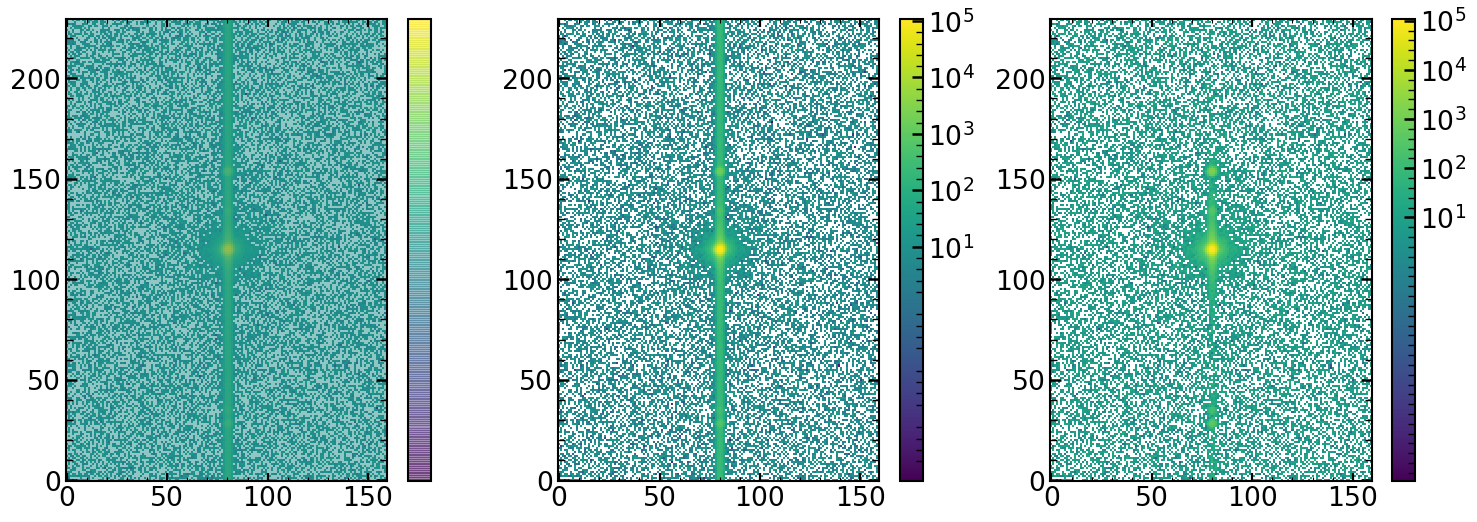

In [534]:
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.imshow(scidata_cut_original,norm=LogNorm(),origin='lower')
plt.imshow(maskdata_cut,origin='lower',alpha=.5)
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])
plt.subplot(132)
plt.imshow(scidata_cut_original_median_subtracted,norm=LogNorm(),origin='lower')
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])
plt.subplot(133)
plt.imshow(scidata_cut_large_removed,norm=LogNorm(),origin='lower')
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

## actual cut 

In [536]:
# set the dataframe used here 
finalHgAr=finalHgAr_May2019

# set up the numbers 
for run in tqdm(list(range(17017,17130+6,6))):
    try:

        DATA_FOLDER='/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/rerun/rerun_1/detrend/calExp/2019-05-06/'
        data=fits.open(DATA_FOLDER+'v00'+str(run+0)+'/calExp-LA0'+str(run+0)+'r1.fits')
        scidata=np.zeros_like(data[1].data)
        maskdata=np.zeros_like(scidata)
        vardata=np.zeros_like(scidata)  


        list_of_sci_data=[]
        list_of_var_data=[]
        list_of_mask_data=[]
        for run_i in range(6):
            data=fits.open(DATA_FOLDER+'v00'+str(run+run_i)+'/calExp-LA0'+str(run+run_i)+'r1.fits')
            exposure_defocus=np.round(data[0].header['W_ENFCAX'],2)
            #background=background_estimate_sigma_clip_fit_function(exposure_defocus)
            #if run_i==0:
            #    print('background estimate is: '+str(background))

            #scidata_single=data[1].data-background
            scidata_single=data[1].data
            maskdata_single=data[2].data
            print(np.sum(maskdata_single))
            vardata_single=data[3].data

            scidata=scidata+scidata_single
            maskdata=maskdata+maskdata_single
            vardata=vardata+vardata_single

            list_of_sci_data.append(scidata_single)
            list_of_var_data.append(vardata_single)
            maskdata_single[np.isin(maskdata_single,[0,512])]=0
            maskdata_single[~np.isin(maskdata_single,[0,512])]=1
            list_of_mask_data.append(maskdata_single)

        maskdata[np.isin(maskdata,[0,3072])]=0
        maskdata[~np.isin(maskdata,[0,3072])]=1


        for image_index in range(len(finalHgAr)):


            # central position as deduced from focused images
            center_pos=[int(np.array(finalHgAr.loc[image_index,['xc','yc']].values)[0]),int(np.array(finalHgAr.loc[image_index,['xc','yc']].values)[1])]
            print('Central position of the spot '+str(image_index)+' is: '+str(center_pos))
            size=sizes_of_stamps[defocus_values==exposure_defocus]
            size_of_stamp=size

            center_pos_new=centering_algorithm(scidata,center_pos[0],center_pos[1],size_of_stamp)

            xposmin=int(np.round(center_pos_new[0]-70-10))
            xposmax=int(np.round(center_pos_new[0]+70+10))
            yposmin=int(np.round(center_pos_new[1]-70-45))
            yposmax=int(np.round(center_pos_new[1]+70+45))
            #print(xposmin,xposmax,yposmin,yposmax)
            
            # if you are on the edge, stop at the edge
            if xposmin<0:
                xposmin=0
            if xposmax>4096:
                xposmax=4096

            scidata_cut=scidata[yposmin:yposmax,xposmin:xposmax]
            maskdata_cut=maskdata[yposmin:yposmax,xposmin:xposmax]
            vardata_cut=vardata[yposmin:yposmax,xposmin:xposmax]

            scidata_cut_original=np.copy(scidata_cut)

            #################
            # removal of continuum - estimating
            #################

            # estimating local background
            sci_upper_cut=scidata_cut[len(scidata_cut[:,0])-70:len(scidata_cut[:,0])-5]
            sci_lower_cut=scidata_cut[5:70]

            overall_median_lower_left=stats.sigma_clipped_stats(sci_lower_cut[:,:25].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
            overall_median_lower_right=stats.sigma_clipped_stats(sci_lower_cut[:,:-25:].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
            overall_median_upper_left=stats.sigma_clipped_stats(sci_upper_cut[:,:25].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
            overall_median_upper_right=stats.sigma_clipped_stats(sci_upper_cut[:,:-25:].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
            list_of_medians=[overall_median_lower_left,overall_median_lower_right,overall_median_upper_left,overall_median_upper_right]
            overall_median=np.array(list_of_medians)[np.abs(list_of_medians)==np.min(np.abs(list_of_medians))][0]
            print('overall_median is: '+str(overall_median))

            scidata_cut_median_subtracted=scidata_cut-overall_median
            scidata_cut_original_median_subtracted=np.copy(scidata_cut_median_subtracted)

            if finalHgAr.loc[image_index]['wavelength']=='690.9346':
                init_lower_limit=40
                init_upper_limit=65
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr.loc[image_index]['wavelength']=='696.7261':
                init_lower_limit=50
                init_upper_limit=65
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr.loc[image_index]['wavelength']=='706.8989':
                init_lower_limit=20
                init_upper_limit=60    
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr.loc[image_index]['wavelength']=='727.47876':
                init_lower_limit=20
                init_upper_limit=60
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr.loc[image_index]['wavelength']=='738.6248':
                init_lower_limit=20
                init_upper_limit=55  
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2]))
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr.loc[image_index]['wavelength']=='763.74286':
                init_lower_limit=0
                init_upper_limit=30   
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr.loc[image_index]['wavelength']=='795.0522':
                init_lower_limit=30
                init_upper_limit=70
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2]))  
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr.loc[image_index]['wavelength']=='826.6699':
                init_lower_limit=0
                init_upper_limit=30     
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr.loc[image_index]['wavelength']=='852.4029':
                init_lower_limit=30
                init_upper_limit=55
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr.loc[image_index]['wavelength']=='912.5693':
                init_lower_limit=30
                init_upper_limit=50   
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2]))
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr.loc[image_index]['wavelength']=='922.7301':
                init_lower_limit=30
                init_upper_limit=55
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr.loc[image_index]['wavelength']=='966.0642':
                init_lower_limit=35
                init_upper_limit=65      
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
      


            # estimating continuum
            sci_upper_cut=scidata_cut_median_subtracted[len(scidata_cut[:,0])-upper_limit:len(scidata_cut[:,0])-lower_limit]
            sci_lower_cut=scidata_cut_median_subtracted[lower_limit:upper_limit]
            midpoint=scidata_cut_median_subtracted.shape[0]/2
            sci_central_cut=scidata_cut_median_subtracted[int(midpoint-size/2):int(midpoint+size/2)]
            mask_central_cut=maskdata_cut[int(midpoint-size/2):int(midpoint+size/2)]
            sci_central_cut_masked= np.ma.array(sci_central_cut, mask=mask_central_cut)
            fiber_profile=np.mean(sci_central_cut_masked,axis=0)

            res=[]
            #res_upper=[]
            res_upper_all_values=[]
            #res_lower=[]
            res_lower_all_values=[]
            for j in range(scidata_cut.shape[1]):
                value=np.median(sci_lower_cut[:,j])     
                res_lower_all_values.append(value)
                value=np.median(sci_upper_cut[:,j])     
                res_upper_all_values.append(value)


            res_upper_all_values=np.array(res_upper_all_values)
            res_lower_all_values=np.array(res_lower_all_values)

            # esnures that you do not oversubtract in the middle
            #res_upper[res_upper>0]=res_upper[res_upper>0]-np.median(np.array(res_upper_all_values))
            #res_lower[res_lower>0]=res_lower[res_lower>0]-np.median(np.array(res_lower_all_values))

            res_upper_multi=np.median(fiber_profile[fiber_profile>500]/res_upper_all_values[fiber_profile>500])
            res_lower_multi=np.median(fiber_profile[fiber_profile>500]/res_lower_all_values[fiber_profile>500])

            res_upper=(fiber_profile/res_upper_multi)*0.995
            res_lower=(fiber_profile/res_lower_multi)*0.995

            if float(finalHgAr.loc[image_index]['wavelength'])<950:
                # if there is another source in upper part, override it with lower half
                print('sum_lower over sum_upper: '+str(res_lower_multi/res_upper_multi))
                print('sum_lower over sum_upper: '+str(res_upper_multi/res_lower_multi))
                if res_upper_multi/res_lower_multi<1/1.2:
                    print('overwritting upper with lower')
                    res_upper=res_lower

                # if there is another source in lower part, override it with upper half
                elif res_lower_multi/res_upper_multi<1/1.2:
                    print('overwritting lower with upper')
                    res_lower=res_upper

            #################
            # removal of continuum - actual removal
            #################
            scidata_cut_large_removed=scidata_cut_median_subtracted
            maskdata_cut_large_removed=maskdata_cut
            vardata_cut_large_removed=vardata_cut
            for j in range(scidata_cut_large_removed.shape[1]):    
                scidata_cut_large_removed[0:int(scidata_cut.shape[0]/2),j]=scidata_cut_large_removed[0:int(scidata_cut.shape[0]/2),j]-res_lower[j]
                scidata_cut_large_removed[int(scidata_cut.shape[0]/2):,j]=scidata_cut_large_removed[int(scidata_cut.shape[0]/2):,j]-res_upper[j]

            ############################ 
            # cutting final image
            # allow for 5 pixels change, to capture wings of the donut
            #################
            y_min_for_scidata_cut_large_removed=int(scidata_cut_large_removed.shape[0]/2-size_of_stamp/2-5)
            y_max_for_scidata_cut_large_removed=int(scidata_cut_large_removed.shape[0]/2+size_of_stamp/2+5)

            scidata_cut_large_removed_prestep=scidata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]
            maskdata_cut_large_removed_prestep=maskdata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]   
            vardata_cut_large_removed_prestep=vardata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]

            # use mask to make sure that CR do not mess with this median
            y_pos_for_final_cut=np.round(np.median(np.where(np.max(scidata_cut_large_removed_prestep*np.abs((1-maskdata_cut_large_removed_prestep)),axis=1)>300)))
            x_pos_for_final_cut=np.round(np.median(np.where(np.max(scidata_cut_large_removed_prestep*np.abs((1-maskdata_cut_large_removed_prestep)),axis=0)>300)))

            y_lower_limit_for_final_cut=int(np.round(y_pos_for_final_cut-size_of_stamp/2))
            y_upper_limit_for_final_cut=int(np.round(y_pos_for_final_cut+size_of_stamp/2))
            x_lower_limit_for_final_cut=int(np.round(x_pos_for_final_cut-size_of_stamp/2))
            x_upper_limit_for_final_cut=int(np.round(x_pos_for_final_cut+size_of_stamp/2))

            scidata_final_cut=scidata_cut_large_removed_prestep[y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]
            maskdata_final_cut=maskdata_cut_large_removed_prestep[y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]
            vardata_final_cut=vardata_cut_large_removed_prestep[y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]


            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Stamps_cleaned/sci"+str(run)+str(image_index)+'HgAr_Stacked.npy',scidata_final_cut)
            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Stamps_cleaned/mask"+str(run)+str(image_index)+'HgAr_Stacked.npy',maskdata_final_cut)
            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Stamps_cleaned/var"+str(run)+str(image_index)+'HgAr_Stacked.npy',vardata_final_cut)

            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Stamps_cleaned/sci"+str(run)+str(image_index)+'HgAr_Stacked_large.npy',scidata_cut_large_removed)
            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Stamps_cleaned/mask"+str(run)+str(image_index)+'HgAr_Stacked_large.npy',maskdata_cut_large_removed)
            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Stamps_cleaned/var"+str(run)+str(image_index)+'HgAr_Stacked_large.npy',vardata_cut_large_removed)
    except TypeError:
        pass

  0%|          | 0/20 [00:00<?, ?it/s]

61061
53293
64717
49917
42805
66869
Central position of the spot 0 is: [69, 808]
0:[778, 838, 39, 99]
1:[778, 838, 39, 99]
2:[777, 837, 29, 89]
3:[776, 836, 26, 86]
overall_median is: 22.854122161865234
lower_limit: 35
upper_limit: 70
sum_lower over sum_upper: 8.760821855606821
sum_lower over sum_upper: 0.114144542199544
overwritting upper with lower
Central position of the spot 1 is: [69, 875]
0:[845, 905, 39, 99]
1:[845, 905, 31, 91]
2:[843, 903, 26, 86]
3:[843, 903, 26, 86]
overall_median is: 25.534496307373047
lower_limit: 45
upper_limit: 70
sum_lower over sum_upper: 0.24173287089442844
sum_lower over sum_upper: 4.136797764821683
overwritting lower with upper
Central position of the spot 2 is: [70, 992]
0:[962, 1022, 40, 100]
1:[962, 1022, 31, 91]
2:[963, 1023, 27, 87]
3:[963, 1023, 27, 87]
overall_median is: 23.079351
lower_limit: 15
upper_limit: 70


/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


sum_lower over sum_upper: 0.9716659520581712
sum_lower over sum_upper: 1.0291602766175063
Central position of the spot 3 is: [71, 1229]
0:[1199, 1259, 41, 101]
1:[1199, 1259, 32, 92]
2:[1197, 1257, 28, 88]
3:[1196, 1256, 28, 88]
overall_median is: 22.035200119018555
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9531828326342252
sum_lower over sum_upper: 1.049116670761254
Central position of the spot 4 is: [72, 1358]
0:[1328, 1388, 42, 102]
1:[1328, 1388, 33, 93]
2:[1325, 1385, 29, 89]
3:[1324, 1384, 29, 89]
overall_median is: 24.032848358154297
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9437708417950708
sum_lower over sum_upper: 1.0595792492359482
Central position of the spot 5 is: [73, 1647]
0:[1617, 1677, 43, 103]
1:[1617, 1677, 40, 100]
2:[1614, 1674, 32, 92]
3:[1614, 1674, 30, 90]
overall_median is: 33.66698455810547
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.4713619052348752
sum_lower over sum_upper: 0.6796424431284761
overwritting up

overall_median is: 23.688732147216797
lower_limit: 25
upper_limit: 75
sum_lower over sum_upper: 16.10068334140805
sum_lower over sum_upper: 0.06210916510780512
overwritting upper with lower
Central position of the spot 31 is: [846, 2350]
0:[2320, 2380, 816, 876]
1:[2320, 2380, 810, 870]
2:[2315, 2375, 808, 868]
3:[2314, 2374, 808, 868]
overall_median is: 23.22022819519043
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8417149694655834
sum_lower over sum_upper: 1.18805063029224
Central position of the spot 32 is: [846, 2651]
0:[2621, 2681, 816, 876]
1:[2621, 2681, 810, 870]
2:[2615, 2675, 808, 868]
3:[2614, 2674, 808, 868]
overall_median is: 16.559295654296875
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.9028481064079994
sum_lower over sum_upper: 1.1076060224332989
Central position of the spot 33 is: [844, 3360]
0:[3330, 3390, 814, 874]
1:[3330, 3390, 810, 870]
2:[3323, 3383, 806, 866]
3:[3322, 3382, 805, 865]
overall_median is: 19.191120147705078
lower_limit:

overall_median is: 17.6911
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.8972193770916677
sum_lower over sum_upper: 1.1145546178923322
Central position of the spot 57 is: [1609, 3343]
0:[3313, 3373, 1579, 1639]
1:[3313, 3373, 1578, 1638]
2:[3306, 3366, 1576, 1636]
3:[3305, 3365, 1576, 1636]
overall_median is: 20.194194793701172
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.9241588598017773
sum_lower over sum_upper: 1.0820650469276352
Central position of the spot 58 is: [1609, 3464]
0:[3434, 3494, 1579, 1639]
1:[3434, 3494, 1576, 1636]
2:[3427, 3487, 1576, 1636]
3:[3426, 3486, 1576, 1636]
overall_median is: 14.547290802001953
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.9747994351372067
sum_lower over sum_upper: 1.025852051154755
Central position of the spot 59 is: [1608, 3987]
0:[3957, 4017, 1578, 1638]
1:[3952, 4012, 1575, 1635]
2:[3945, 4005, 1575, 1635]
3:[3944, 4004, 1575, 1635]
overall_median is: 11.129049301147461
lower_limit: 30
upper_l

overall_median is: 14.248655319213867
lower_limit: 35
upper_limit: 70
sum_lower over sum_upper: 8.900163140676142
sum_lower over sum_upper: 0.11235749100257846
overwritting upper with lower
Central position of the spot 85 is: [2828, 843]
0:[813, 873, 2798, 2858]
1:[813, 873, 2798, 2858]
2:[811, 871, 2803, 2863]
3:[810, 870, 2803, 2863]
overall_median is: 14.834653854370117
lower_limit: 45
upper_limit: 70
sum_lower over sum_upper: 0.2194884961094918
sum_lower over sum_upper: 4.556047436313702
overwritting lower with upper
Central position of the spot 86 is: [2828, 959]
0:[929, 989, 2798, 2858]
1:[929, 989, 2802, 2862]
2:[930, 990, 2803, 2863]
3:[930, 990, 2803, 2863]
overall_median is: 15.486492156982422
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 1.021627528676412
sum_lower over sum_upper: 0.9788303192021148
Central position of the spot 87 is: [2828, 1195]
0:[1165, 1225, 2798, 2858]
1:[1165, 1225, 2802, 2862]
2:[1162, 1222, 2803, 2863]
3:[1162, 1222, 2803, 2863]
overall_m

Central position of the spot 111 is: [4003, 1229]
0:[1199, 1259, 3973, 4033]
1:[1199, 1259, 3981, 4041]
2:[1198, 1258, 3985, 4045]
3:[1198, 1258, 3986, 4046]
overall_median is: 10.795190811157227
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9481954516147768
sum_lower over sum_upper: 1.054634883870198
Central position of the spot 112 is: [4003, 1357]
0:[1327, 1387, 3973, 4033]
1:[1327, 1387, 3980, 4040]
2:[1326, 1386, 3985, 4045]
3:[1326, 1386, 3985, 4045]
overall_median is: 11.848005294799805
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9343140958499792
sum_lower over sum_upper: 1.070303877937605
Central position of the spot 113 is: [4002, 1647]
0:[1617, 1677, 3972, 4032]
1:[1617, 1677, 3978, 4038]
2:[1616, 1676, 3984, 4044]
3:[1616, 1676, 3984, 4044]
overall_median is: 17.355609893798828
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.643796205722076
sum_lower over sum_upper: 0.6083479183848867
overwritting upper with lower
Central position of 

  5%|▌         | 1/20 [00:27<08:33, 27.05s/it]

sum_lower over sum_upper: 0.9396254066380221
sum_lower over sum_upper: 1.0642538962180663
Central position of the spot 119 is: [4016, 4044]
0:[4014, 4074, 3986, 4046]
1:[4011, 4071, 3992, 4052]
2:[4005, 4065, 3996, 4056]
3:[4004, 4064, 3996, 4056]
overall_median is: 5.389239311218262
lower_limit: 30
upper_limit: 70
43301
47701
48237
31669
58445
56117
Central position of the spot 0 is: [69, 808]
0:[778, 838, 39, 99]
1:[778, 838, 29, 89]
2:[777, 837, 27, 87]
3:[777, 837, 27, 87]
overall_median is: 17.421680450439453
lower_limit: 35
upper_limit: 70
sum_lower over sum_upper: 9.302990038403358
sum_lower over sum_upper: 0.10749232191713995
overwritting upper with lower
Central position of the spot 1 is: [69, 875]
0:[845, 905, 39, 99]
1:[845, 905, 30, 90]
2:[843, 903, 28, 88]
3:[843, 903, 28, 88]
overall_median is: 19.569826126098633
lower_limit: 45
upper_limit: 70
sum_lower over sum_upper: 0.2302218215026533
sum_lower over sum_upper: 4.343636904065043
overwritting lower with upper
Central po

overall_median is: 15.949180603027344
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9466957070520553
sum_lower over sum_upper: 1.0563056244481457
Central position of the spot 29 is: [846, 1620]
0:[1590, 1650, 816, 876]
1:[1590, 1650, 810, 870]
2:[1587, 1647, 809, 869]
3:[1586, 1646, 809, 869]
overall_median is: 22.651060104370117
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.3402121388337178
sum_lower over sum_upper: 0.7461505317137496
overwritting upper with lower
Central position of the spot 30 is: [847, 1982]
0:[1952, 2012, 817, 877]
1:[1952, 2012, 809, 869]
2:[1948, 2008, 809, 869]
3:[1948, 2008, 809, 869]
overall_median is: 18.657047271728516
lower_limit: 25
upper_limit: 75
sum_lower over sum_upper: 16.52595975798843
sum_lower over sum_upper: 0.06051085774407826
overwritting upper with lower
Central position of the spot 31 is: [846, 2350]
0:[2320, 2380, 816, 876]
1:[2320, 2380, 810, 870]
2:[2315, 2375, 809, 869]
3:[2314, 2374, 809, 869]
overall_median is

overall_median is: 20.530498504638672
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8502959188449362
sum_lower over sum_upper: 1.1760611545195063
Central position of the spot 56 is: [1610, 2635]
0:[2605, 2665, 1580, 1640]
1:[2605, 2665, 1577, 1637]
2:[2599, 2659, 1577, 1637]
3:[2598, 2658, 1577, 1637]
overall_median is: 14.063785552978516
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.9052945279487896
sum_lower over sum_upper: 1.1046128846772039
Central position of the spot 57 is: [1609, 3343]
0:[3313, 3373, 1579, 1639]
1:[3313, 3373, 1576, 1636]
2:[3306, 3366, 1577, 1637]
3:[3306, 3366, 1577, 1637]
overall_median is: 15.829523086547852
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.9015952630660656
sum_lower over sum_upper: 1.1091451352564654
Central position of the spot 58 is: [1609, 3464]
0:[3434, 3494, 1579, 1639]
1:[3434, 3494, 1576, 1636]
2:[3427, 3487, 1577, 1637]
3:[3426, 3486, 1577, 1637]
overall_median is: 11.212194442749023
lower_limit:

lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.9770569999201603
sum_lower over sum_upper: 1.0234817416811042
Central position of the spot 83 is: [2441, 3983]
0:[3953, 4013, 2411, 2471]
1:[3948, 4008, 2412, 2472]
2:[3944, 4004, 2412, 2472]
3:[3944, 4004, 2412, 2472]
overall_median is: 6.794895648956299
lower_limit: 30
upper_limit: 70
Central position of the spot 84 is: [2828, 776]
0:[746, 806, 2798, 2858]
1:[746, 806, 2802, 2862]
2:[745, 805, 2803, 2863]
3:[744, 804, 2803, 2863]
overall_median is: 10.767295837402344
lower_limit: 35
upper_limit: 70
sum_lower over sum_upper: 8.573988915734533
sum_lower over sum_upper: 0.11663182794240061
overwritting upper with lower
Central position of the spot 85 is: [2828, 843]
0:[813, 873, 2798, 2858]
1:[813, 873, 2802, 2862]
2:[811, 871, 2803, 2863]
3:[811, 871, 2803, 2863]
overall_median is: 12.05596
lower_limit: 45
upper_limit: 70
sum_lower over sum_upper: 0.20522223144059673
sum_lower over sum_upper: 4.872766429739647
overwritting low

3:[845, 905, 3986, 4046]
overall_median is: 9.213414192199707
lower_limit: 45
upper_limit: 70
sum_lower over sum_upper: 0.21491677912704285
sum_lower over sum_upper: 4.65296383121801
overwritting lower with upper
Central position of the spot 110 is: [4005, 992]
0:[962, 1022, 3975, 4035]
1:[962, 1022, 3983, 4043]
2:[964, 1024, 3985, 4045]
3:[965, 1025, 3986, 4046]
overall_median is: 7.962238788604736
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 1.0070975336238748
sum_lower over sum_upper: 0.9929524863412826
Central position of the spot 111 is: [4003, 1229]
0:[1199, 1259, 3973, 4033]
1:[1199, 1259, 3981, 4041]
2:[1199, 1259, 3984, 4044]
3:[1199, 1259, 3984, 4044]
overall_median is: 9.13778305053711
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9538514953973346
sum_lower over sum_upper: 1.048381225825349
Central position of the spot 112 is: [4003, 1357]
0:[1327, 1387, 3973, 4033]
1:[1327, 1387, 3981, 4041]
2:[1326, 1386, 3984, 4044]
3:[1326, 1386, 3984, 4044]
ov

 10%|█         | 2/20 [00:52<07:49, 26.06s/it]

overall_median is: 9.235528945922852
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.9051595313591451
sum_lower over sum_upper: 1.1047776279817183
Central position of the spot 118 is: [4009, 3515]
0:[3485, 3545, 3979, 4039]
1:[3485, 3545, 3986, 4046]
2:[3482, 3542, 3989, 4049]
3:[3482, 3542, 3989, 4049]
overall_median is: 6.61859130859375
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.9451751540671199
sum_lower over sum_upper: 1.0580049588660545
Central position of the spot 119 is: [4016, 4044]
0:[4014, 4074, 3986, 4046]
1:[4009, 4069, 3993, 4053]
2:[4005, 4065, 3995, 4055]
3:[4005, 4065, 3995, 4055]
overall_median is: 5.218866348266602
lower_limit: 30
upper_limit: 70
39717
29405
33229
25933
42125
28045
Central position of the spot 0 is: [69, 808]
0:[783, 833, 44, 94]
1:[782, 832, 37, 87]
2:[782, 832, 34, 84]
3:[782, 832, 34, 84]
overall_median is: 13.694375991821289
lower_limit: 30
upper_limit: 75
sum_lower over sum_upper: 7.676995209204948
sum_lower over sum_

overall_median is: 12.430862426757812
lower_limit: 40
upper_limit: 75
sum_lower over sum_upper: 0.24698381920948834
sum_lower over sum_upper: 4.048848233056974
overwritting lower with upper
Central position of the spot 26 is: [845, 968]
0:[943, 993, 820, 870]
1:[942, 992, 814, 864]
2:[943, 993, 814, 864]
3:[943, 993, 814, 864]
overall_median is: 12.045951843261719
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.9819434591384654
sum_lower over sum_upper: 1.0183885749158887
Central position of the spot 27 is: [846, 1203]
0:[1178, 1228, 821, 871]
1:[1177, 1227, 814, 864]
2:[1176, 1226, 814, 864]
3:[1176, 1226, 814, 864]
overall_median is: 12.206033706665039
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.9538216217832068
sum_lower over sum_upper: 1.048414061038437
Central position of the spot 28 is: [846, 1331]
0:[1306, 1356, 821, 871]
1:[1305, 1355, 815, 865]
2:[1303, 1353, 815, 865]
3:[1303, 1353, 815, 865]
overall_median is: 13.452377319335938
lower_limit: 10
up

Central position of the spot 54 is: [1610, 1968]
0:[1943, 1993, 1585, 1635]
1:[1942, 1992, 1582, 1632]
2:[1938, 1988, 1583, 1633]
3:[1938, 1988, 1583, 1633]
overall_median is: 17.21393585205078
lower_limit: 20
upper_limit: 80
sum_lower over sum_upper: 16.440340821621927
sum_lower over sum_upper: 0.060825989609949255
overwritting upper with lower
Central position of the spot 55 is: [1610, 2334]
0:[2309, 2359, 1585, 1635]
1:[2308, 2358, 1582, 1632]
2:[2305, 2355, 1583, 1633]
3:[2305, 2355, 1583, 1633]
overall_median is: 17.271357
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8577083425891209
sum_lower over sum_upper: 1.1658974855967361
Central position of the spot 56 is: [1610, 2635]
0:[2610, 2660, 1585, 1635]
1:[2609, 2659, 1582, 1632]
2:[2604, 2654, 1583, 1633]
3:[2603, 2653, 1583, 1633]
overall_median is: 11.43162727355957
lower_limit: 20
upper_limit: 70
sum_lower over sum_upper: 0.8907359143236155
sum_lower over sum_upper: 1.1226672057557652
Central position of the spot 

overall_median is: 7.371641
lower_limit: 20
upper_limit: 70
sum_lower over sum_upper: 0.973114596071078
sum_lower over sum_upper: 1.0276281992249126
Central position of the spot 83 is: [2441, 3983]
0:[3958, 4008, 2416, 2466]
1:[3954, 4004, 2417, 2467]
2:[3949, 3999, 2416, 2466]
3:[3949, 3999, 2416, 2466]
overall_median is: 5.409714698791504
lower_limit: 25
upper_limit: 75
Central position of the spot 84 is: [2828, 776]
0:[751, 801, 2803, 2853]
1:[750, 800, 2807, 2857]
2:[750, 800, 2807, 2857]
3:[750, 800, 2807, 2857]
overall_median is: 8.433381080627441
lower_limit: 30
upper_limit: 75
sum_lower over sum_upper: 7.93316155630734
sum_lower over sum_upper: 0.12605314954224522
overwritting upper with lower
Central position of the spot 85 is: [2828, 843]
0:[818, 868, 2803, 2853]
1:[817, 867, 2806, 2856]
2:[816, 866, 2807, 2857]
3:[816, 866, 2807, 2857]
overall_median is: 9.695951461791992
lower_limit: 40
upper_limit: 75
sum_lower over sum_upper: 0.22351207670927017
sum_lower over sum_upper: 

Central position of the spot 109 is: [4005, 875]
0:[850, 900, 3980, 4030]
1:[849, 899, 3986, 4036]
2:[850, 900, 3990, 4040]
3:[850, 900, 3990, 4040]
overall_median is: 6.0389556884765625
lower_limit: 40
upper_limit: 75
sum_lower over sum_upper: 0.21395887786094106
sum_lower over sum_upper: 4.673795310563991
overwritting lower with upper
Central position of the spot 110 is: [4005, 992]
0:[967, 1017, 3980, 4030]
1:[966, 1016, 3986, 4036]
2:[968, 1018, 3989, 4039]
3:[969, 1019, 3989, 4039]
overall_median is: 6.5034871101379395
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 1.013121803294895
sum_lower over sum_upper: 0.9870481483546993
Central position of the spot 111 is: [4003, 1229]
0:[1204, 1254, 3978, 4028]
1:[1203, 1253, 3979, 4029]
2:[1203, 1253, 3987, 4037]
3:[1203, 1253, 3988, 4038]
overall_median is: 6.987705707550049
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.9597947688174545
sum_lower over sum_upper: 1.0418894043693128
Central position of the spot 112

 15%|█▌        | 3/20 [01:17<07:18, 25.77s/it]

overall_median is: 3.673431158065796
lower_limit: 25
upper_limit: 75
27357
87805
43509
33717
25693
24413
Central position of the spot 0 is: [69, 808]
0:[788, 828, 49, 89]
1:[788, 828, 43, 83]
2:[787, 827, 40, 80]
3:[787, 827, 40, 80]
overall_median is: 9.56744
lower_limit: 25
upper_limit: 80
sum_lower over sum_upper: 2.8946189104996707
sum_lower over sum_upper: 0.34546861984929805
overwritting upper with lower
Central position of the spot 1 is: [69, 875]
0:[855, 895, 49, 89]
1:[855, 895, 44, 84]
2:[854, 894, 41, 81]
3:[854, 894, 40, 80]
overall_median is: 11.34054946899414
lower_limit: 35
upper_limit: 80
sum_lower over sum_upper: 0.42462756634984283
sum_lower over sum_upper: 2.355004901344814
overwritting lower with upper
Central position of the spot 2 is: [70, 992]
0:[972, 1012, 50, 90]
1:[972, 1012, 45, 85]
2:[972, 1012, 42, 82]
3:[972, 1012, 42, 82]
overall_median is: 10.583724975585938
lower_limit: 5
upper_limit: 75
sum_lower over sum_upper: 0.9950705104619095
sum_lower over sum_up

overall_median is: 14.977630615234375
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.2589663305608714
sum_lower over sum_upper: 0.7943024175670357
overwritting upper with lower
Central position of the spot 30 is: [847, 1982]
0:[1962, 2002, 827, 867]
1:[1962, 2002, 823, 863]
2:[1958, 1998, 821, 861]
3:[1958, 1998, 821, 861]
overall_median is: 12.364642143249512
lower_limit: 15
upper_limit: 85
sum_lower over sum_upper: 10.587230007609467
sum_lower over sum_upper: 0.09445341220331097
overwritting upper with lower
Central position of the spot 31 is: [846, 2350]
0:[2330, 2370, 826, 866]
1:[2330, 2370, 822, 862]
2:[2325, 2365, 821, 861]
3:[2325, 2365, 821, 861]
overall_median is: 11.444323
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8755622040669945
sum_lower over sum_upper: 1.1421233070077612
Central position of the spot 32 is: [846, 2651]
0:[2631, 2671, 826, 866]
1:[2631, 2671, 822, 862]
2:[2625, 2665, 820, 860]
3:[2624, 2664, 820, 860]
overall_median is: 7.46938

overall_median is: 8.450396537780762
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.8910819818539663
sum_lower over sum_upper: 1.122231197986319
Central position of the spot 57 is: [1609, 3343]
0:[3323, 3363, 1589, 1629]
1:[3323, 3363, 1589, 1629]
2:[3317, 3357, 1587, 1627]
3:[3316, 3356, 1587, 1627]
overall_median is: 9.912251
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9302165758708096
sum_lower over sum_upper: 1.0750184698266245
Central position of the spot 58 is: [1609, 3464]
0:[3444, 3484, 1589, 1629]
1:[3444, 3484, 1587, 1627]
2:[3438, 3478, 1587, 1627]
3:[3437, 3477, 1587, 1627]
overall_median is: 7.055787086486816
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9599129611885081
sum_lower over sum_upper: 1.0417611183850028
Central position of the spot 59 is: [1608, 3987]
0:[3967, 4007, 1588, 1628]
1:[3962, 4002, 1586, 1626]
2:[3956, 3996, 1586, 1626]
3:[3955, 3995, 1586, 1626]
overall_median is: 5.151644706726074
lower_limit: 20
upper_lim

overall_median is: 3.8288440704345703
lower_limit: 20
upper_limit: 80
Central position of the spot 84 is: [2828, 776]
0:[756, 796, 2808, 2848]
1:[756, 796, 2810, 2850]
2:[755, 795, 2812, 2852]
3:[755, 795, 2812, 2852]
overall_median is: 6.638144493103027
lower_limit: 25
upper_limit: 80
sum_lower over sum_upper: 2.244349080931413
sum_lower over sum_upper: 0.4455634858660207
overwritting upper with lower
Central position of the spot 85 is: [2828, 843]
0:[823, 863, 2808, 2848]
1:[823, 863, 2810, 2850]
2:[821, 861, 2811, 2851]
3:[821, 861, 2811, 2851]
overall_median is: 7.656704902648926
lower_limit: 35
upper_limit: 80
sum_lower over sum_upper: 0.43717010749473445
sum_lower over sum_upper: 2.28743910632555
overwritting lower with upper
Central position of the spot 86 is: [2828, 959]
0:[939, 979, 2808, 2848]
1:[939, 979, 2810, 2850]
2:[939, 979, 2811, 2851]
3:[939, 979, 2811, 2851]
overall_median is: 6.766400337219238
lower_limit: 5
upper_limit: 75
sum_lower over sum_upper: 0.98414163199054

overall_median is: 4.791032791137695
lower_limit: 5
upper_limit: 75
sum_lower over sum_upper: 0.9995346076046733
sum_lower over sum_upper: 1.0004656090862547
Central position of the spot 111 is: [4003, 1229]
0:[1209, 1249, 3983, 4023]
1:[1209, 1249, 3987, 4027]
2:[1209, 1249, 3991, 4031]
3:[1209, 1249, 3991, 4031]
overall_median is: 4.948204040527344
lower_limit: 5
upper_limit: 75
sum_lower over sum_upper: 0.9770515574414667
sum_lower over sum_upper: 1.0234874427902523
Central position of the spot 112 is: [4003, 1357]
0:[1337, 1377, 3983, 4023]
1:[1337, 1377, 3987, 4027]
2:[1337, 1377, 3991, 4031]
3:[1337, 1377, 3991, 4031]
overall_median is: 4.952251434326172
lower_limit: 5
upper_limit: 70
sum_lower over sum_upper: 0.9603407455850591
sum_lower over sum_upper: 1.0412970652315494
Central position of the spot 113 is: [4002, 1647]
0:[1627, 1667, 3982, 4022]
1:[1627, 1667, 3985, 4025]
2:[1626, 1666, 3990, 4030]
3:[1626, 1666, 3990, 4030]
overall_median is: 7.2603325843811035
lower_limit: 0

 20%|██        | 4/20 [01:41<06:46, 25.43s/it]

overall_median is: 2.9482879638671875
lower_limit: 20
upper_limit: 80
20805
22925
8277
25229
77325
17157
Central position of the spot 0 is: [69, 808]
0:[793, 823, 54, 84]
1:[792, 822, 50, 80]
2:[792, 822, 47, 77]
3:[792, 822, 46, 76]
overall_median is: 7.026631832122803
lower_limit: 20
upper_limit: 85
sum_lower over sum_upper: 1.2116886356799441
sum_lower over sum_upper: 0.8252945274499879
overwritting upper with lower
Central position of the spot 1 is: [69, 875]
0:[860, 890, 54, 84]
1:[859, 889, 51, 81]
2:[859, 889, 48, 78]
3:[859, 889, 47, 77]
overall_median is: 7.5717387199401855
lower_limit: 30
upper_limit: 85
sum_lower over sum_upper: 0.6547003311083535
sum_lower over sum_upper: 1.5274163651438555
overwritting lower with upper
Central position of the spot 2 is: [70, 992]
0:[977, 1007, 55, 85]
1:[976, 1006, 51, 81]
2:[976, 1006, 48, 78]
3:[976, 1006, 48, 78]
overall_median is: 7.711974143981934
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.9561272030309497
sum_lower ov

overall_median is: 10.163528442382812
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.2377662155857372
sum_lower over sum_upper: 0.8079070081314013
overwritting upper with lower
Central position of the spot 30 is: [847, 1982]
0:[1967, 1997, 832, 862]
1:[1966, 1996, 829, 859]
2:[1963, 1993, 827, 857]
3:[1963, 1993, 827, 857]
overall_median is: 8.396774291992188
lower_limit: 10
upper_limit: 90
sum_lower over sum_upper: 1.4382501944908024
sum_lower over sum_upper: 0.6952893201965042
overwritting upper with lower
Central position of the spot 31 is: [846, 2350]
0:[2335, 2365, 831, 861]
1:[2334, 2364, 829, 859]
2:[2330, 2360, 827, 857]
3:[2330, 2360, 827, 857]
overall_median is: 8.673810958862305
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8876049740932438
sum_lower over sum_upper: 1.1266273051495417
Central position of the spot 32 is: [846, 2651]
0:[2636, 2666, 831, 861]
1:[2635, 2665, 828, 858]
2:[2631, 2661, 826, 856]
3:[2630, 2660, 826, 856]
overall_median is: 6

overall_median is: 6.293679714202881
lower_limit: 10
upper_limit: 75
sum_lower over sum_upper: 0.9033278292174931
sum_lower over sum_upper: 1.1070178152999548
Central position of the spot 57 is: [1609, 3343]
0:[3328, 3358, 1594, 1624]
1:[3327, 3357, 1593, 1623]
2:[3323, 3353, 1593, 1623]
3:[3321, 3351, 1593, 1623]
overall_median is: 7.2397308349609375
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.9518452013237247
sum_lower over sum_upper: 1.050590997999787
Central position of the spot 58 is: [1609, 3464]
0:[3449, 3479, 1594, 1624]
1:[3448, 3478, 1593, 1623]
2:[3444, 3474, 1592, 1622]
3:[3442, 3472, 1593, 1623]
overall_median is: 4.300363540649414
lower_limit: 10
upper_limit: 75
sum_lower over sum_upper: 0.9143715585687373
sum_lower over sum_upper: 1.0936473150644543
Central position of the spot 59 is: [1608, 3987]
0:[3972, 4002, 1593, 1623]
1:[3968, 3998, 1592, 1622]
2:[3963, 3993, 1591, 1621]
3:[3961, 3991, 1591, 1621]
overall_median is: 3.744189977645874
lower_limit: 15

overall_median is: 2.2092552185058594
lower_limit: 15
upper_limit: 85
Central position of the spot 84 is: [2828, 776]
0:[761, 791, 2813, 2843]
1:[760, 790, 2814, 2844]
2:[760, 790, 2816, 2846]
3:[760, 790, 2816, 2846]
overall_median is: 4.001598358154297
lower_limit: 20
upper_limit: 85
sum_lower over sum_upper: 1.0646347395481215
sum_lower over sum_upper: 0.9392892819038056
Central position of the spot 85 is: [2828, 843]
0:[828, 858, 2813, 2843]
1:[827, 857, 2814, 2844]
2:[826, 856, 2816, 2846]
3:[826, 856, 2816, 2846]
overall_median is: 4.676263809204102
lower_limit: 30
upper_limit: 85
sum_lower over sum_upper: 0.7296697807184459
sum_lower over sum_upper: 1.3704829587644183
overwritting lower with upper
Central position of the spot 86 is: [2828, 959]
0:[944, 974, 2813, 2843]
1:[943, 973, 2814, 2844]
2:[943, 973, 2816, 2846]
3:[943, 973, 2816, 2846]
overall_median is: 4.781484127044678
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.9719460762964411
sum_lower over sum_upper:

Central position of the spot 111 is: [4003, 1229]
0:[1214, 1244, 3988, 4018]
1:[1213, 1243, 3991, 4021]
2:[1213, 1243, 3994, 4024]
3:[1213, 1243, 3995, 4025]
overall_median is: 2.7234740257263184
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.9862473687458074
sum_lower over sum_upper: 1.0139444034934983
Central position of the spot 112 is: [4003, 1357]
0:[1342, 1372, 3988, 4018]
1:[1341, 1371, 3990, 4020]
2:[1341, 1371, 3993, 4023]
3:[1341, 1371, 3994, 4024]
overall_median is: 4.101039886474609
lower_limit: 0
upper_limit: 75
sum_lower over sum_upper: 0.9630328755433272
sum_lower over sum_upper: 1.0383861500427143
Central position of the spot 113 is: [4002, 1647]
0:[1632, 1662, 3987, 4017]
1:[1631, 1661, 3988, 4018]
2:[1631, 1661, 3991, 4021]
3:[1631, 1661, 3993, 4023]
overall_median is: 5.513984680175781
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.2364413213992025
sum_lower over sum_upper: 0.8087727114040181
overwritting upper with lower
Central position of t

 25%|██▌       | 5/20 [02:06<06:19, 25.31s/it]

Central position of the spot 119 is: [4016, 4044]
0:[4029, 4059, 4001, 4031]
1:[4027, 4057, 4002, 4032]
2:[4023, 4053, 4004, 4034]
3:[4021, 4051, 4005, 4035]
overall_median is: 1.784132719039917
lower_limit: 15
upper_limit: 85
17941
8757
32141
34253
11805
19573
Central position of the spot 0 is: [69, 808]
0:[793, 823, 54, 84]
1:[792, 822, 49, 79]
2:[792, 822, 48, 78]
3:[792, 822, 48, 78]
overall_median is: 4.2772674560546875
lower_limit: 20
upper_limit: 85
sum_lower over sum_upper: 1.0149819089737009
sum_lower over sum_upper: 0.9852392354570637
Central position of the spot 1 is: [69, 875]
0:[860, 890, 54, 84]
1:[859, 889, 50, 80]
2:[859, 889, 48, 78]
3:[859, 889, 48, 78]
overall_median is: 4.339472770690918
lower_limit: 30
upper_limit: 85
sum_lower over sum_upper: 0.7973130952826772
sum_lower over sum_upper: 1.2542124366406684
overwritting lower with upper
Central position of the spot 2 is: [70, 992]
0:[977, 1007, 55, 85]
1:[976, 1006, 50, 80]
2:[977, 1007, 49, 79]
3:[977, 1007, 49, 79

overall_median is: 3.888789415359497
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.9394890220014034
sum_lower over sum_upper: 1.0644083928407055
Central position of the spot 27 is: [846, 1203]
0:[1188, 1218, 831, 861]
1:[1187, 1217, 827, 857]
2:[1186, 1216, 827, 857]
3:[1186, 1216, 827, 857]
overall_median is: 4.090803146362305
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.9599541877340474
sum_lower over sum_upper: 1.0417163785289378
Central position of the spot 28 is: [846, 1331]
0:[1316, 1346, 831, 861]
1:[1315, 1345, 827, 857]
2:[1314, 1344, 827, 857]
3:[1314, 1344, 827, 857]
overall_median is: 3.833167552947998
lower_limit: 0
upper_limit: 75
sum_lower over sum_upper: 0.9563715830927256
sum_lower over sum_upper: 1.0456186880482043
Central position of the spot 29 is: [846, 1620]
0:[1605, 1635, 831, 861]
1:[1604, 1634, 830, 860]
2:[1602, 1632, 828, 858]
3:[1602, 1632, 828, 858]
overall_median is: 6.8226637840271
lower_limit: 0
upper_limit: 70
sum_lower over s

overall_median is: 6.389909744262695
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.287601796752914
sum_lower over sum_upper: 0.7766376239314119
overwritting upper with lower
Central position of the spot 54 is: [1610, 1968]
0:[1953, 1983, 1595, 1625]
1:[1952, 1982, 1594, 1624]
2:[1949, 1979, 1594, 1624]
3:[1949, 1979, 1594, 1624]
overall_median is: 5.78034782409668
lower_limit: 10
upper_limit: 90
sum_lower over sum_upper: 1.1579385207095598
sum_lower over sum_upper: 0.8636037078956674
Central position of the spot 55 is: [1610, 2334]
0:[2319, 2349, 1595, 1625]
1:[2318, 2348, 1594, 1624]
2:[2315, 2345, 1594, 1624]
3:[2315, 2345, 1594, 1624]
overall_median is: 5.461579322814941
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8825158550321786
sum_lower over sum_upper: 1.1331241181650358
Central position of the spot 56 is: [1610, 2635]
0:[2620, 2650, 1595, 1625]
1:[2619, 2649, 1594, 1624]
2:[2615, 2645, 1594, 1624]
3:[2614, 2644, 1594, 1624]
overall_median is: 3.19011

overall_median is: 3.1289122104644775
lower_limit: 10
upper_limit: 75
sum_lower over sum_upper: 0.8971571193494712
sum_lower over sum_upper: 1.1146319618185723
Central position of the spot 81 is: [2440, 3342]
0:[3327, 3357, 2425, 2455]
1:[3326, 3356, 2424, 2454]
2:[3321, 3351, 2425, 2455]
3:[3321, 3351, 2425, 2455]
overall_median is: 3.574611186981201
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.9308548931134769
sum_lower over sum_upper: 1.0742812949666622
Central position of the spot 82 is: [2440, 3463]
0:[3448, 3478, 2425, 2455]
1:[3447, 3477, 2424, 2454]
2:[3442, 3472, 2425, 2455]
3:[3441, 3471, 2425, 2455]
overall_median is: 2.5862064361572266
lower_limit: 10
upper_limit: 75
sum_lower over sum_upper: 0.9401757325779957
sum_lower over sum_upper: 1.0636309419069603
Central position of the spot 83 is: [2441, 3983]
0:[3968, 3998, 2426, 2456]
1:[3964, 3994, 2425, 2455]
2:[3960, 3990, 2426, 2456]
3:[3960, 3990, 2426, 2456]
overall_median is: 1.4221649169921875
lower_limit:

overall_median is: 1.484276533126831
lower_limit: 15
upper_limit: 85
Central position of the spot 108 is: [4006, 809]
0:[794, 824, 3991, 4021]
1:[793, 823, 3994, 4024]
2:[794, 824, 3996, 4026]
3:[794, 824, 3996, 4026]
overall_median is: 1.3735734224319458
lower_limit: 20
upper_limit: 85
sum_lower over sum_upper: 1.0532365060569782
sum_lower over sum_upper: 0.9494543668484482
Central position of the spot 109 is: [4005, 875]
0:[860, 890, 3990, 4020]
1:[859, 889, 3993, 4023]
2:[860, 890, 3996, 4026]
3:[860, 890, 3996, 4026]
overall_median is: 1.6673049926757812
lower_limit: 30
upper_limit: 85
sum_lower over sum_upper: 0.7792540891896896
sum_lower over sum_upper: 1.2832784760101212
overwritting lower with upper
Central position of the spot 110 is: [4005, 992]
0:[977, 1007, 3990, 4020]
1:[976, 1006, 3993, 4023]
2:[978, 1008, 3995, 4025]
3:[978, 1008, 3995, 4025]
overall_median is: 1.910775065422058
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.9788366919963425
sum_lower over su

 30%|███       | 6/20 [02:31<05:52, 25.18s/it]

overall_median is: 0.9763718247413635
lower_limit: 15
upper_limit: 85
22917
15405
15205
8989
9885
10461
Central position of the spot 0 is: [69, 808]
0:[796, 820, 57, 81]
1:[796, 820, 53, 77]
2:[796, 820, 52, 76]
3:[796, 820, 52, 76]
overall_median is: 1.930355191230774
lower_limit: 17
upper_limit: 88
sum_lower over sum_upper: 0.9252975497920405
sum_lower over sum_upper: 1.0807334356659097
Central position of the spot 1 is: [69, 875]
0:[863, 887, 57, 81]
1:[863, 887, 54, 78]
2:[862, 886, 53, 77]
3:[862, 886, 53, 77]
overall_median is: 2.283444
lower_limit: 27
upper_limit: 88
sum_lower over sum_upper: 0.8721070031404824
sum_lower over sum_upper: 1.14664828558763
Central position of the spot 2 is: [70, 992]
0:[980, 1004, 58, 82]
1:[980, 1004, 54, 78]
2:[980, 1004, 53, 77]
3:[980, 1004, 53, 77]
overall_median is: 2.604033946990967
lower_limit: 0
upper_limit: 83
sum_lower over sum_upper: 0.935794583930034
sum_lower over sum_upper: 1.0686105873794696
Central position of the spot 3 is: [71, 1

overall_median is: 4.847864151000977
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.2714635200761382
sum_lower over sum_upper: 0.7864952349872514
overwritting upper with lower
Central position of the spot 30 is: [847, 1982]
0:[1970, 1994, 835, 859]
1:[1970, 1994, 831, 855]
2:[1967, 1991, 832, 856]
3:[1966, 1990, 832, 856]
overall_median is: 3.320678472518921
lower_limit: 7
upper_limit: 93
sum_lower over sum_upper: 1.1081184305843392
sum_lower over sum_upper: 0.9024306178832115
Central position of the spot 31 is: [846, 2350]
0:[2338, 2362, 834, 858]
1:[2338, 2362, 832, 856]
2:[2334, 2358, 832, 856]
3:[2333, 2357, 832, 856]
overall_median is: 2.7806286811828613
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8840339093029171
sum_lower over sum_upper: 1.1311783286554302
Central position of the spot 32 is: [846, 2651]
0:[2639, 2663, 834, 858]
1:[2639, 2663, 831, 855]
2:[2634, 2658, 831, 855]
3:[2633, 2657, 831, 855]
overall_median is: 2.755575656890869
lower_limit: 7

overall_median is: 2.8271360397338867
lower_limit: 7
upper_limit: 78
sum_lower over sum_upper: 0.8999347339489071
sum_lower over sum_upper: 1.111191692326406
Central position of the spot 57 is: [1609, 3343]
0:[3331, 3355, 1597, 1621]
1:[3331, 3355, 1597, 1621]
2:[3326, 3350, 1596, 1620]
3:[3325, 3349, 1596, 1620]
overall_median is: 1.7507264614105225
lower_limit: 7
upper_limit: 73
sum_lower over sum_upper: 0.9328413950022421
sum_lower over sum_upper: 1.07199359436402
Central position of the spot 58 is: [1609, 3464]
0:[3452, 3476, 1597, 1621]
1:[3452, 3476, 1595, 1619]
2:[3447, 3471, 1596, 1620]
3:[3445, 3469, 1596, 1620]
overall_median is: 1.6608206033706665
lower_limit: 7
upper_limit: 78
sum_lower over sum_upper: 0.9229539898529395
sum_lower over sum_upper: 1.0834776283477974
Central position of the spot 59 is: [1608, 3987]
0:[3975, 3999, 1596, 1620]
1:[3969, 3993, 1594, 1618]
2:[3965, 3989, 1595, 1619]
3:[3964, 3988, 1595, 1619]
overall_median is: 0.3285454511642456
lower_limit: 12
u

overall_median is: 0.6359697580337524
lower_limit: 12
upper_limit: 88
Central position of the spot 84 is: [2828, 776]
0:[764, 788, 2816, 2840]
1:[764, 788, 2818, 2842]
2:[763, 787, 2818, 2842]
3:[763, 787, 2818, 2842]
overall_median is: 1.3441317081451416
lower_limit: 17
upper_limit: 88
sum_lower over sum_upper: 0.9502830083528615
sum_lower over sum_upper: 1.0523180896744788
Central position of the spot 85 is: [2828, 843]
0:[831, 855, 2816, 2840]
1:[831, 855, 2817, 2841]
2:[829, 853, 2818, 2842]
3:[829, 853, 2818, 2842]
overall_median is: 1.409148931503296
lower_limit: 27
upper_limit: 88
sum_lower over sum_upper: 0.8911355191167298
sum_lower over sum_upper: 1.1221637770551147
Central position of the spot 86 is: [2828, 959]
0:[947, 971, 2816, 2840]
1:[947, 971, 2818, 2842]
2:[946, 970, 2818, 2842]
3:[946, 970, 2818, 2842]
overall_median is: 1.1143031120300293
lower_limit: 0
upper_limit: 83
sum_lower over sum_upper: 0.9585614848453141
sum_lower over sum_upper: 1.0432298979354182
Central 

overall_median is: 0.7323088645935059
lower_limit: 0
upper_limit: 83
sum_lower over sum_upper: 0.9861170661653984
sum_lower over sum_upper: 1.0140783830956162
Central position of the spot 111 is: [4003, 1229]
0:[1217, 1241, 3991, 4015]
1:[1217, 1241, 3993, 4017]
2:[1217, 1241, 3995, 4019]
3:[1217, 1241, 3995, 4019]
overall_median is: 0.6737957
lower_limit: 0
upper_limit: 83
sum_lower over sum_upper: 1.0197327050706086
sum_lower over sum_upper: 0.9806491397476144
Central position of the spot 112 is: [4003, 1357]
0:[1345, 1369, 3991, 4015]
1:[1345, 1369, 3993, 4017]
2:[1345, 1369, 3995, 4019]
3:[1345, 1369, 3995, 4019]
overall_median is: 0.8598177433013916
lower_limit: 0
upper_limit: 78
sum_lower over sum_upper: 0.9881613524185592
sum_lower over sum_upper: 1.0119804802651564
Central position of the spot 113 is: [4002, 1647]
0:[1635, 1659, 3990, 4014]
1:[1635, 1659, 3991, 4015]
2:[1635, 1659, 3994, 4018]
3:[1635, 1659, 3994, 4018]
overall_median is: 1.136535406112671
lower_limit: 0
upper_

 35%|███▌      | 7/20 [02:55<05:25, 25.05s/it]

overall_median is: -0.0423358678817749
lower_limit: 12
upper_limit: 88
10557
9301
16717
10757
13541
8109
Central position of the spot 0 is: [69, 808]
0:[798, 818, 59, 79]
1:[798, 818, 55, 75]
2:[798, 818, 56, 76]
3:[798, 818, 56, 76]
overall_median is: 1.0292370319366455
lower_limit: 15
upper_limit: 90
sum_lower over sum_upper: 0.884167707872911
sum_lower over sum_upper: 1.1310071506747887
Central position of the spot 1 is: [69, 875]
0:[865, 885, 59, 79]
1:[865, 885, 56, 76]
2:[864, 884, 56, 76]
3:[864, 884, 56, 76]
overall_median is: 1.0277503728866577
lower_limit: 25
upper_limit: 90
sum_lower over sum_upper: 0.8810567655428693
sum_lower over sum_upper: 1.1350006482089074
Central position of the spot 2 is: [70, 992]
0:[982, 1002, 60, 80]
1:[982, 1002, 56, 76]
2:[981, 1001, 57, 77]
3:[981, 1001, 57, 77]
overall_median is: 0.729034960269928
lower_limit: 0
upper_limit: 85
sum_lower over sum_upper: 0.8935150092954536
sum_lower over sum_upper: 1.1191753799284367
Central position of the spo

overall_median is: 1.3650434017181396
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.9485456129538223
sum_lower over sum_upper: 1.0542455590363715
Central position of the spot 29 is: [846, 1620]
0:[1610, 1630, 836, 856]
1:[1610, 1630, 834, 854]
2:[1607, 1627, 834, 854]
3:[1607, 1627, 834, 854]
overall_median is: 2.706244468688965
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.2747450572405195
sum_lower over sum_upper: 0.7844705843886395
overwritting upper with lower
Central position of the spot 30 is: [847, 1982]
0:[1972, 1992, 837, 857]
1:[1972, 1992, 835, 855]
2:[1969, 1989, 835, 855]
3:[1969, 1989, 835, 855]
overall_median is: 1.793532133102417
lower_limit: 5
upper_limit: 95
sum_lower over sum_upper: 1.0903949773599806
sum_lower over sum_upper: 0.9170988685413416
Central position of the spot 31 is: [846, 2350]
0:[2340, 2360, 836, 856]
1:[2340, 2360, 834, 854]
2:[2336, 2356, 834, 854]
3:[2336, 2356, 834, 854]
overall_median is: 1.2841870784759521
lower_limit: 

overall_median is: 0.8586406707763672
lower_limit: 5
upper_limit: 75
sum_lower over sum_upper: 0.9093026894582338
sum_lower over sum_upper: 1.0997438054382134
Central position of the spot 58 is: [1609, 3464]
0:[3454, 3474, 1599, 1619]
1:[3454, 3474, 1598, 1618]
2:[3449, 3469, 1598, 1618]
3:[3448, 3468, 1598, 1618]
overall_median is: 0.6253368854522705
lower_limit: 5
upper_limit: 80
sum_lower over sum_upper: 0.9209512313442955
sum_lower over sum_upper: 1.0858338269881225
Central position of the spot 59 is: [1608, 3987]
0:[3977, 3997, 1598, 1618]
1:[3971, 3991, 1597, 1617]
2:[3967, 3987, 1597, 1617]
3:[3967, 3987, 1597, 1617]
overall_median is: -0.20497965812683105
lower_limit: 10
upper_limit: 90
Central position of the spot 60 is: [1992, 771]
0:[761, 781, 1982, 2002]
1:[761, 781, 1981, 2001]
2:[759, 779, 1981, 2001]
3:[759, 779, 1981, 2001]
overall_median is: -0.10133291780948639
lower_limit: 15
upper_limit: 90
sum_lower over sum_upper: 0.9093266120653695
sum_lower over sum_upper: 1.099

overall_median is: 0.3712972104549408
lower_limit: 25
upper_limit: 90
sum_lower over sum_upper: 0.8956935462260673
sum_lower over sum_upper: 1.1164532827253466
Central position of the spot 86 is: [2828, 959]
0:[949, 969, 2818, 2838]
1:[949, 969, 2818, 2838]
2:[948, 968, 2819, 2839]
3:[947, 967, 2819, 2839]
overall_median is: 0.14328253269195557
lower_limit: 0
upper_limit: 85
sum_lower over sum_upper: 0.962727475277357
sum_lower over sum_upper: 1.038715551056549
Central position of the spot 87 is: [2828, 1195]
0:[1185, 1205, 2818, 2838]
1:[1185, 1205, 2818, 2838]
2:[1183, 1203, 2819, 2839]
3:[1183, 1203, 2819, 2839]
overall_median is: 0.5572199821472168
lower_limit: 0
upper_limit: 85
sum_lower over sum_upper: 0.9588110539480842
sum_lower over sum_upper: 1.0429583554364676
Central position of the spot 88 is: [2827, 1323]
0:[1313, 1333, 2817, 2837]
1:[1313, 1333, 2818, 2838]
2:[1310, 1330, 2818, 2838]
3:[1310, 1330, 2818, 2838]
overall_median is: -0.002115964889526367
lower_limit: 0
upper

overall_median is: 0.8483514785766602
lower_limit: 5
upper_limit: 95
sum_lower over sum_upper: 1.0822883953501776
sum_lower over sum_upper: 0.9239681440698133
Central position of the spot 115 is: [4002, 2379]
0:[2369, 2389, 3992, 4012]
1:[2369, 2389, 3993, 4013]
2:[2367, 2387, 3994, 4014]
3:[2367, 2387, 3994, 4014]
overall_median is: 0.42921775579452515
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8443215928640255
sum_lower over sum_upper: 1.1843828328586237
Central position of the spot 116 is: [4003, 2681]
0:[2671, 2691, 3993, 4013]
1:[2669, 2689, 3994, 4014]
2:[2668, 2688, 3995, 4015]
3:[2668, 2688, 3995, 4015]
overall_median is: 0.6271452903747559
lower_limit: 5
upper_limit: 80
sum_lower over sum_upper: 0.8334568470709683
sum_lower over sum_upper: 1.1998221665756506
Central position of the spot 117 is: [4008, 3393]
0:[3383, 3403, 3998, 4018]
1:[3383, 3403, 3998, 4018]
2:[3381, 3401, 3999, 4019]
3:[3381, 3401, 3999, 4019]


 40%|████      | 8/20 [03:21<05:01, 25.16s/it]

overall_median is: 0.031081557273864746
lower_limit: 5
upper_limit: 75
sum_lower over sum_upper: 0.8130230096159312
sum_lower over sum_upper: 1.2299774891640471
overwritting lower with upper
Central position of the spot 118 is: [4009, 3515]
0:[3505, 3525, 3999, 4019]
1:[3504, 3524, 3999, 4019]
2:[3503, 3523, 4000, 4020]
3:[3502, 3522, 4000, 4020]
overall_median is: 0.023561835289001465
lower_limit: 5
upper_limit: 80
sum_lower over sum_upper: 0.7826872802939251
sum_lower over sum_upper: 1.2776494842543842
overwritting lower with upper
Central position of the spot 119 is: [4016, 4044]
0:[4034, 4054, 4006, 4026]
1:[4030, 4050, 4006, 4026]
2:[4027, 4047, 4007, 4027]
3:[4027, 4047, 4007, 4027]
overall_median is: -0.06318783760070801
lower_limit: 10
upper_limit: 90
9357
9269
18333
10389
12053
16749
Central position of the spot 0 is: [69, 808]
0:[798, 818, 59, 79]
1:[798, 818, 57, 77]
2:[798, 818, 57, 77]
3:[798, 818, 57, 77]
overall_median is: 0.6949554681777954
lower_limit: 15
upper_limit: 

Central position of the spot 27 is: [846, 1203]
0:[1193, 1213, 836, 856]
1:[1193, 1213, 834, 854]
2:[1192, 1212, 835, 855]
3:[1192, 1212, 835, 855]
overall_median is: 0.1211080253124237
lower_limit: 0
upper_limit: 85
sum_lower over sum_upper: 0.9600778270461802
sum_lower over sum_upper: 1.0415822257625158
Central position of the spot 28 is: [846, 1331]
0:[1321, 1341, 836, 856]
1:[1321, 1341, 835, 855]
2:[1319, 1339, 835, 855]
3:[1319, 1339, 835, 855]
overall_median is: 0.4055333137512207
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.931003734261873
sum_lower over sum_upper: 1.0741095477912657
Central position of the spot 29 is: [846, 1620]
0:[1610, 1630, 836, 856]
1:[1610, 1630, 836, 856]
2:[1608, 1628, 835, 855]
3:[1608, 1628, 835, 855]
overall_median is: 1.0874159336090088
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.2197072399670783
sum_lower over sum_upper: 0.8198688728181948
overwritting upper with lower
Central position of the spot 30 is: [847, 1982]
0:

Central position of the spot 54 is: [1610, 1968]
0:[1958, 1978, 1600, 1620]
1:[1958, 1978, 1600, 1620]
2:[1954, 1974, 1600, 1620]
3:[1954, 1974, 1600, 1620]
overall_median is: 0.7776002883911133
lower_limit: 5
upper_limit: 95
sum_lower over sum_upper: 1.0688368502181023
sum_lower over sum_upper: 0.9355964849040752
Central position of the spot 55 is: [1610, 2334]
0:[2324, 2344, 1600, 1620]
1:[2324, 2344, 1600, 1620]
2:[2321, 2341, 1600, 1620]
3:[2321, 2341, 1600, 1620]
overall_median is: 0.08506417274475098
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.9141242737122538
sum_lower over sum_upper: 1.0939431637002761
Central position of the spot 56 is: [1610, 2635]
0:[2625, 2645, 1600, 1620]
1:[2625, 2645, 1600, 1620]
2:[2620, 2640, 1600, 1620]
3:[2620, 2640, 1600, 1620]
overall_median is: 0.20410120487213135
lower_limit: 5
upper_limit: 80
sum_lower over sum_upper: 0.8985080589264156
sum_lower over sum_upper: 1.1129560720855995
Central position of the spot 57 is: [1609, 3343]
0

Central position of the spot 81 is: [2440, 3342]
0:[3332, 3352, 2430, 2450]
1:[3332, 3352, 2429, 2449]
2:[3327, 3347, 2429, 2449]
3:[3327, 3347, 2429, 2449]
overall_median is: 0.2695203125476837
lower_limit: 5
upper_limit: 75
sum_lower over sum_upper: 0.9558039975845389
sum_lower over sum_upper: 1.0462396082535237
Central position of the spot 82 is: [2440, 3463]
0:[3453, 3473, 2430, 2450]
1:[3451, 3471, 2429, 2449]
2:[3447, 3467, 2429, 2449]
3:[3447, 3467, 2429, 2449]
overall_median is: 0.13417935371398926
lower_limit: 5
upper_limit: 80
sum_lower over sum_upper: 0.8939141499095197
sum_lower over sum_upper: 1.1186756581727877
Central position of the spot 83 is: [2441, 3983]
0:[3973, 3993, 2431, 2451]
1:[3967, 3987, 2429, 2449]
2:[3966, 3986, 2430, 2450]
3:[3966, 3986, 2430, 2450]
overall_median is: 0.12726736068725586
lower_limit: 10
upper_limit: 90
Central position of the spot 84 is: [2828, 776]
0:[766, 786, 2818, 2838]
1:[766, 786, 2818, 2838]
2:[765, 785, 2819, 2839]
3:[765, 785, 281

Central position of the spot 108 is: [4006, 809]
0:[799, 819, 3996, 4016]
1:[800, 820, 3996, 4016]
2:[799, 819, 3997, 4017]
3:[799, 819, 3997, 4017]
overall_median is: 0.34095001220703125
lower_limit: 15
upper_limit: 90
sum_lower over sum_upper: 1.1062453437603452
sum_lower over sum_upper: 0.9039586070489604
Central position of the spot 109 is: [4005, 875]
0:[865, 885, 3995, 4015]
1:[866, 886, 3995, 4015]
2:[866, 886, 3996, 4016]
3:[866, 886, 3996, 4016]
overall_median is: 0.014378249645233154
lower_limit: 25
upper_limit: 90
sum_lower over sum_upper: 1.0202924612180588
sum_lower over sum_upper: 0.9801111328473082
Central position of the spot 110 is: [4005, 992]
0:[982, 1002, 3995, 4015]
1:[984, 1004, 3995, 4015]
2:[983, 1003, 3996, 4016]
3:[983, 1003, 3996, 4016]
overall_median is: -0.20572566986083984
lower_limit: 0
upper_limit: 85
sum_lower over sum_upper: 1.0773285864977242
sum_lower over sum_upper: 0.9282219116183383
Central position of the spot 111 is: [4003, 1229]
0:[1219, 1239, 

 45%|████▌     | 9/20 [03:45<04:35, 25.02s/it]

10037
14509
13949
13733
14645
7773


 50%|█████     | 10/20 [04:00<04:00, 24.02s/it]

Central position of the spot 0 is: [69, 808]
11981
5789
12981
10221
4613
11373
Central position of the spot 0 is: [69, 808]
0:[798, 818, 59, 79]
1:[798, 818, 60, 80]
2:[798, 818, 60, 80]
3:[798, 818, 60, 80]
overall_median is: 0.4149007797241211
lower_limit: 15
upper_limit: 90
sum_lower over sum_upper: 1.2066869453162126
sum_lower over sum_upper: 0.8287153547832158
overwritting upper with lower
Central position of the spot 1 is: [69, 875]
0:[865, 885, 59, 79]
1:[865, 885, 61, 81]
2:[865, 885, 60, 80]
3:[865, 885, 60, 80]
overall_median is: 0.6535611152648926
lower_limit: 25
upper_limit: 90
sum_lower over sum_upper: 1.1006047425664078
sum_lower over sum_upper: 0.9085913964609892
Central position of the spot 2 is: [70, 992]
0:[982, 1002, 60, 80]
1:[982, 1002, 61, 81]
2:[982, 1002, 61, 81]
3:[982, 1002, 61, 81]
overall_median is: 0.5671515464782715
lower_limit: 0
upper_limit: 85
sum_lower over sum_upper: 1.1486777210436259
sum_lower over sum_upper: 0.8705662011895335
Central position of t

overall_median is: 0.8703547716140747
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.2366879899494365
sum_lower over sum_upper: 0.808611394407482
overwritting upper with lower
Central position of the spot 30 is: [847, 1982]
0:[1972, 1992, 837, 857]
1:[1971, 1991, 837, 857]
2:[1969, 1989, 837, 857]
3:[1969, 1989, 837, 857]
overall_median is: 0.4457330107688904
lower_limit: 5
upper_limit: 95
sum_lower over sum_upper: 1.080082862433438
sum_lower over sum_upper: 0.925854890195174
Central position of the spot 31 is: [846, 2350]
0:[2340, 2360, 836, 856]
1:[2340, 2360, 837, 857]
2:[2336, 2356, 837, 857]
3:[2336, 2356, 837, 857]
overall_median is: -0.011527568101882935
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.9096186003811194
sum_lower over sum_upper: 1.0993618639515637
Central position of the spot 32 is: [846, 2651]
0:[2641, 2661, 836, 856]
1:[2639, 2659, 836, 856]
2:[2636, 2656, 837, 857]
3:[2636, 2656, 837, 857]
overall_median is: 0.25663662
lower_limit: 5
uppe

overall_median is: -0.09104061126708984
lower_limit: 5
upper_limit: 80
sum_lower over sum_upper: 0.9020852059175494
sum_lower over sum_upper: 1.1085427334803226
Central position of the spot 57 is: [1609, 3343]
0:[3333, 3353, 1599, 1619]
1:[3332, 3352, 1599, 1619]
2:[3328, 3348, 1599, 1619]
3:[3328, 3348, 1599, 1619]
overall_median is: -0.15584224462509155
lower_limit: 5
upper_limit: 75
sum_lower over sum_upper: 0.8866365676752254
sum_lower over sum_upper: 1.1278578353947382
Central position of the spot 58 is: [1609, 3464]
0:[3454, 3474, 1599, 1619]
1:[3452, 3472, 1599, 1619]
2:[3449, 3469, 1599, 1619]
3:[3449, 3469, 1599, 1619]
overall_median is: 0.4958655834197998
lower_limit: 5
upper_limit: 80
sum_lower over sum_upper: 0.9404936578775901
sum_lower over sum_upper: 1.063271391172055
Central position of the spot 59 is: [1608, 3987]
0:[3977, 3997, 1598, 1618]
1:[3970, 3990, 1598, 1618]
2:[3968, 3988, 1598, 1618]
3:[3968, 3988, 1598, 1618]
overall_median is: -0.27205947041511536
lower_lim

overall_median is: 0.15790605545043945
lower_limit: 10
upper_limit: 90
Central position of the spot 84 is: [2828, 776]
0:[766, 786, 2818, 2838]
1:[766, 786, 2817, 2837]
2:[765, 785, 2818, 2838]
3:[765, 785, 2818, 2838]
overall_median is: 0.380234956741333
lower_limit: 15
upper_limit: 90
sum_lower over sum_upper: 0.9424600861700653
sum_lower over sum_upper: 1.0610528919731375
Central position of the spot 85 is: [2828, 843]
0:[833, 853, 2818, 2838]
1:[833, 853, 2816, 2836]
2:[832, 852, 2817, 2837]
3:[832, 852, 2817, 2837]
overall_median is: -0.10823416709899902
lower_limit: 25
upper_limit: 90
sum_lower over sum_upper: 0.901374439124436
sum_lower over sum_upper: 1.1094168600691245
Central position of the spot 86 is: [2828, 959]
0:[949, 969, 2818, 2838]
1:[949, 969, 2816, 2836]
2:[948, 968, 2817, 2837]
3:[948, 968, 2817, 2837]
overall_median is: -0.14410579204559326
lower_limit: 0
upper_limit: 85
sum_lower over sum_upper: 0.9965290113971014
sum_lower over sum_upper: 1.0034830783280784
Cent

overall_median is: 0.0966949462890625
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 1.1516685132447866
sum_lower over sum_upper: 0.8683054094988967
Central position of the spot 113 is: [4002, 1647]
0:[1637, 1657, 3992, 4012]
1:[1637, 1657, 3990, 4010]
2:[1637, 1657, 3990, 4010]
3:[1637, 1657, 3990, 4010]
overall_median is: -0.15637904405593872
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.3652320633871367
sum_lower over sum_upper: 0.7324762044622678
overwritting upper with lower
Central position of the spot 114 is: [4002, 2011]
0:[2001, 2021, 3992, 4012]
1:[2000, 2020, 3988, 4008]
2:[1999, 2019, 3989, 4009]
3:[1999, 2019, 3989, 4009]
overall_median is: 0.0016260147094726562
lower_limit: 5
upper_limit: 95
sum_lower over sum_upper: 1.0690960633723805
sum_lower over sum_upper: 0.9353696400729207
Central position of the spot 115 is: [4002, 2379]
0:[2369, 2389, 3992, 4012]
1:[2369, 2389, 3990, 4010]
2:[2368, 2388, 3990, 4010]
3:[2368, 2388, 3990, 4010]
overall_median

 55%|█████▌    | 11/20 [04:24<03:36, 24.05s/it]

overall_median is: 0.2175614833831787
lower_limit: 5
upper_limit: 80
sum_lower over sum_upper: 0.7844044488713802
sum_lower over sum_upper: 1.274852534861096
overwritting lower with upper
Central position of the spot 119 is: [4016, 4044]
0:[4034, 4054, 4006, 4026]
1:[4028, 4048, 4002, 4022]
2:[4028, 4048, 4002, 4022]
3:[4028, 4048, 4002, 4022]
overall_median is: -0.0068776607513427734
lower_limit: 10
upper_limit: 90
8365
15309
17605
16989
7405
12893
Central position of the spot 0 is: [69, 808]
0:[796, 820, 57, 81]
1:[796, 820, 60, 84]
2:[796, 820, 59, 83]
3:[796, 820, 59, 83]
overall_median is: 1.4613699913024902
lower_limit: 17
upper_limit: 88
sum_lower over sum_upper: 1.030716149526964
sum_lower over sum_upper: 0.970199215816051
Central position of the spot 1 is: [69, 875]
0:[863, 887, 57, 81]
1:[863, 887, 61, 85]
2:[863, 887, 59, 83]
3:[863, 887, 59, 83]
overall_median is: 1.1237150430679321
lower_limit: 27
upper_limit: 88
sum_lower over sum_upper: 0.9852742309729836
sum_lower over 

Central position of the spot 27 is: [846, 1203]
0:[1191, 1215, 834, 858]
1:[1191, 1215, 836, 860]
2:[1190, 1214, 835, 859]
3:[1190, 1214, 835, 859]
overall_median is: 1.3724700212478638
lower_limit: 0
upper_limit: 83
sum_lower over sum_upper: 0.9917979824709859
sum_lower over sum_upper: 1.008269846958732
Central position of the spot 28 is: [846, 1331]
0:[1319, 1343, 834, 858]
1:[1319, 1343, 836, 860]
2:[1317, 1341, 836, 860]
3:[1317, 1341, 836, 860]
overall_median is: 1.3485898971557617
lower_limit: 0
upper_limit: 78
sum_lower over sum_upper: 0.9849985588500845
sum_lower over sum_upper: 1.0152299117751284
Central position of the spot 29 is: [846, 1620]
0:[1608, 1632, 834, 858]
1:[1608, 1632, 836, 860]
2:[1606, 1630, 836, 860]
3:[1606, 1630, 836, 860]
overall_median is: 2.434251308441162
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.280757705761153
sum_lower over sum_upper: 0.7807878067036114
overwritting upper with lower
Central position of the spot 30 is: [847, 1982]
0:[1

Central position of the spot 54 is: [1610, 1968]
0:[1956, 1980, 1598, 1622]
1:[1955, 1979, 1598, 1622]
2:[1953, 1977, 1599, 1623]
3:[1953, 1977, 1599, 1623]
overall_median is: 2.338334083557129
lower_limit: 7
upper_limit: 93
sum_lower over sum_upper: 1.11433074209354
sum_lower over sum_upper: 0.8973996339015631
Central position of the spot 55 is: [1610, 2334]
0:[2322, 2346, 1598, 1622]
1:[2322, 2346, 1598, 1622]
2:[2319, 2343, 1599, 1623]
3:[2319, 2343, 1599, 1623]
overall_median is: 0.9807086
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8839871829869613
sum_lower over sum_upper: 1.1312381211467744
Central position of the spot 56 is: [1610, 2635]
0:[2623, 2647, 1598, 1622]
1:[2623, 2647, 1598, 1622]
2:[2619, 2643, 1598, 1622]
3:[2619, 2643, 1598, 1622]
overall_median is: 0.24416977167129517
lower_limit: 7
upper_limit: 78
sum_lower over sum_upper: 0.9009457295284279
sum_lower over sum_upper: 1.1099447693962865
Central position of the spot 57 is: [1609, 3343]
0:[3331, 3355,

overall_median is: 0.1875639259815216
lower_limit: 7
upper_limit: 78
sum_lower over sum_upper: 0.8989686085352346
sum_lower over sum_upper: 1.1123858947971323
Central position of the spot 83 is: [2441, 3983]
0:[3971, 3995, 2429, 2453]
1:[3965, 3989, 2427, 2451]
2:[3965, 3989, 2427, 2451]
3:[3965, 3989, 2427, 2451]
overall_median is: -0.17716076970100403
lower_limit: 12
upper_limit: 88
Central position of the spot 84 is: [2828, 776]
0:[764, 788, 2816, 2840]
1:[764, 788, 2814, 2838]
2:[764, 788, 2815, 2839]
3:[764, 788, 2815, 2839]
overall_median is: 0.36360061168670654
lower_limit: 17
upper_limit: 88
sum_lower over sum_upper: 0.9443214157143389
sum_lower over sum_upper: 1.0589614757847492
Central position of the spot 85 is: [2828, 843]
0:[831, 855, 2816, 2840]
1:[831, 855, 2814, 2838]
2:[830, 854, 2815, 2839]
3:[830, 854, 2815, 2839]
overall_median is: 0.9826383590698242
lower_limit: 27
upper_limit: 88
sum_lower over sum_upper: 0.8980474915332239
sum_lower over sum_upper: 1.113526856238

overall_median is: -0.06337469816207886
lower_limit: 27
upper_limit: 88
sum_lower over sum_upper: 1.024632431102309
sum_lower over sum_upper: 0.9759597389711653
Central position of the spot 110 is: [4005, 992]
0:[980, 1004, 3993, 4017]
1:[980, 1004, 3988, 4012]
2:[981, 1005, 3989, 4013]
3:[981, 1005, 3989, 4013]
overall_median is: 0.6375651359558105
lower_limit: 0
upper_limit: 83
sum_lower over sum_upper: 1.0688294825195708
sum_lower over sum_upper: 0.9356029341955296
Central position of the spot 111 is: [4003, 1229]
0:[1217, 1241, 3991, 4015]
1:[1217, 1241, 3987, 4011]
2:[1217, 1241, 3988, 4012]
3:[1217, 1241, 3988, 4012]
overall_median is: 0.0020557642
lower_limit: 0
upper_limit: 83
sum_lower over sum_upper: 1.0820525639195622
sum_lower over sum_upper: 0.9241695212824599
Central position of the spot 112 is: [4003, 1357]
0:[1345, 1369, 3991, 4015]
1:[1345, 1369, 3986, 4010]
2:[1345, 1369, 3987, 4011]
3:[1345, 1369, 3987, 4011]
overall_median is: 0.5778688192367554
lower_limit: 0
upper

 60%|██████    | 12/20 [04:48<03:12, 24.06s/it]

overall_median is: 0.5294042825698853
lower_limit: 7
upper_limit: 78
sum_lower over sum_upper: 0.7431574691385809
sum_lower over sum_upper: 1.3456098357715949
overwritting lower with upper
Central position of the spot 119 is: [4016, 4044]
0:[4032, 4056, 4004, 4028]
1:[4026, 4050, 3998, 4022]
2:[4026, 4050, 3999, 4023]
3:[4026, 4050, 3999, 4023]
overall_median is: 0.16349220275878906
lower_limit: 12
upper_limit: 88
23957
17565
11709
12877
5517
25549
Central position of the spot 0 is: [69, 808]
0:[793, 823, 54, 84]
1:[792, 822, 59, 89]
2:[793, 823, 57, 87]
3:[794, 824, 57, 87]
overall_median is: 2.1020150184631348
lower_limit: 20
upper_limit: 85
sum_lower over sum_upper: 1.0224085207108577
sum_lower over sum_upper: 0.9780826154546545
Central position of the spot 1 is: [69, 875]
0:[860, 890, 54, 84]
1:[859, 889, 59, 89]
2:[860, 890, 58, 88]
3:[860, 890, 58, 88]
overall_median is: 2.193284273147583
lower_limit: 30
upper_limit: 85
sum_lower over sum_upper: 0.9267972305761718
sum_lower over 

overall_median is: 2.5055456161499023
lower_limit: 0
upper_limit: 75
sum_lower over sum_upper: 0.9744971312127935
sum_lower over sum_upper: 1.0261702861613018
Central position of the spot 29 is: [846, 1620]
0:[1605, 1635, 831, 861]
1:[1604, 1634, 833, 863]
2:[1603, 1633, 834, 864]
3:[1603, 1633, 834, 864]
overall_median is: 4.579219341278076
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.2666487001294937
sum_lower over sum_upper: 0.7894848823495944
overwritting upper with lower
Central position of the spot 30 is: [847, 1982]
0:[1967, 1997, 832, 862]
1:[1966, 1996, 834, 864]
2:[1965, 1995, 834, 864]
3:[1965, 1995, 834, 864]
overall_median is: 2.9233474731445312
lower_limit: 10
upper_limit: 90
sum_lower over sum_upper: 1.1567259210941474
sum_lower over sum_upper: 0.8645090265238455
Central position of the spot 31 is: [846, 2350]
0:[2335, 2365, 831, 861]
1:[2334, 2364, 834, 864]
2:[2332, 2362, 834, 864]
3:[2332, 2362, 834, 864]
overall_median is: 3.4517931938171387
lower_limit

overall_median is: 2.887950897216797
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8719263928255818
sum_lower over sum_upper: 1.1468858016321541
Central position of the spot 56 is: [1610, 2635]
0:[2620, 2650, 1595, 1625]
1:[2619, 2649, 1596, 1626]
2:[2616, 2646, 1596, 1626]
3:[2616, 2646, 1596, 1626]
overall_median is: 1.595205307006836
lower_limit: 10
upper_limit: 75
sum_lower over sum_upper: 0.8908910944515183
sum_lower over sum_upper: 1.122471653637592
Central position of the spot 57 is: [1609, 3343]
0:[3328, 3358, 1594, 1624]
1:[3327, 3357, 1595, 1625]
2:[3324, 3354, 1595, 1625]
3:[3324, 3354, 1595, 1625]
overall_median is: 1.6044094562530518
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.9324895702843078
sum_lower over sum_upper: 1.0723980534121245
Central position of the spot 58 is: [1609, 3464]
0:[3449, 3479, 1594, 1624]
1:[3448, 3478, 1595, 1625]
2:[3445, 3475, 1595, 1625]
3:[3444, 3474, 1595, 1625]
overall_median is: 1.2137576341629028
lower_limit: 10

overall_median is: 1.4054319858551025
lower_limit: 20
upper_limit: 85
sum_lower over sum_upper: 0.9669484435585811
sum_lower over sum_upper: 1.0341813016625603
Central position of the spot 85 is: [2828, 843]
0:[828, 858, 2813, 2843]
1:[827, 857, 2810, 2840]
2:[827, 857, 2811, 2841]
3:[827, 857, 2811, 2841]
overall_median is: 1.4623289108276367
lower_limit: 30
upper_limit: 85
sum_lower over sum_upper: 0.8677325371989609
sum_lower over sum_upper: 1.1524288385312809
Central position of the spot 86 is: [2828, 959]
0:[944, 974, 2813, 2843]
1:[943, 973, 2810, 2840]
2:[944, 974, 2811, 2841]
3:[944, 974, 2811, 2841]
overall_median is: 1.2153304815292358
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.9674719263224697
sum_lower over sum_upper: 1.0336217235792828
Central position of the spot 87 is: [2828, 1195]
0:[1180, 1210, 2813, 2843]
1:[1179, 1209, 2810, 2840]
2:[1178, 1208, 2811, 2841]
3:[1178, 1208, 2811, 2841]
overall_median is: 1.4216346740722656
lower_limit: 0
upper_limit: 80

overall_median is: 0.9939604
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 1.045716052854721
sum_lower over sum_upper: 0.9562825369947036
Central position of the spot 112 is: [4003, 1357]
0:[1342, 1372, 3988, 4018]
1:[1341, 1371, 3981, 4011]
2:[1342, 1372, 3983, 4013]
3:[1342, 1372, 3983, 4013]
overall_median is: 1.0168455839157104
lower_limit: 0
upper_limit: 75
sum_lower over sum_upper: 1.0269993350866757
sum_lower over sum_upper: 0.9737104648812678
Central position of the spot 113 is: [4002, 1647]
0:[1632, 1662, 3987, 4017]
1:[1631, 1661, 3982, 4012]
2:[1632, 1662, 3982, 4012]
3:[1632, 1662, 3982, 4012]
overall_median is: 2.163142204284668
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.2900887754401025
sum_lower over sum_upper: 0.7751404547015447
overwritting upper with lower
Central position of the spot 114 is: [4002, 2011]
0:[1996, 2026, 3987, 4017]
1:[1995, 2025, 3980, 4010]
2:[1995, 2025, 3981, 4011]
3:[1995, 2025, 3981, 4011]
overall_median is: 1.529644012

 65%|██████▌   | 13/20 [05:12<02:48, 24.06s/it]

overall_median is: 1.3280702829360962
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.8315702865899212
sum_lower over sum_upper: 1.2025441698990598
overwritting lower with upper
Central position of the spot 118 is: [4009, 3515]
0:[3500, 3530, 3994, 4024]
1:[3499, 3529, 3987, 4017]
2:[3499, 3529, 3988, 4018]
3:[3499, 3529, 3988, 4018]
overall_median is: 0.7933142185211182
lower_limit: 10
upper_limit: 75
sum_lower over sum_upper: 0.8045731663634843
sum_lower over sum_upper: 1.2428950427464631
overwritting lower with upper
Central position of the spot 119 is: [4016, 4044]
0:[4029, 4059, 4001, 4031]
1:[4023, 4053, 3994, 4024]
2:[4024, 4054, 3994, 4024]
3:[4024, 4054, 3994, 4024]
overall_median is: -0.4861100912094116
lower_limit: 15
upper_limit: 85
14373
12637
12365
17925
12229
17197
Central position of the spot 0 is: [69, 808]
0:[793, 823, 54, 84]
1:[792, 822, 58, 88]
2:[793, 823, 59, 89]
3:[794, 824, 59, 89]
overall_median is: 4.901322841644287
lower_limit: 20
upper_limit: 85

overall_median is: 4.300390243530273
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.9769992688453784
sum_lower over sum_upper: 1.0235422194141497
Central position of the spot 27 is: [846, 1203]
0:[1188, 1218, 831, 861]
1:[1187, 1217, 834, 864]
2:[1187, 1217, 834, 864]
3:[1187, 1217, 834, 864]
overall_median is: 4.229666709899902
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.9852186136738749
sum_lower over sum_upper: 1.0150031537376314
Central position of the spot 28 is: [846, 1331]
0:[1316, 1346, 831, 861]
1:[1315, 1345, 834, 864]
2:[1315, 1345, 835, 865]
3:[1315, 1345, 835, 865]
overall_median is: 3.8590309619903564
lower_limit: 0
upper_limit: 75
sum_lower over sum_upper: 0.9714959647712811
sum_lower over sum_upper: 1.0293403537043302
Central position of the spot 29 is: [846, 1620]
0:[1605, 1635, 831, 861]
1:[1604, 1634, 832, 862]
2:[1603, 1633, 835, 865]
3:[1603, 1633, 835, 865]
overall_median is: 6.319509506225586
lower_limit: 0
upper_limit: 70
sum_lower ove

overall_median is: 7.059600830078125
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.2552271160351447
sum_lower over sum_upper: 0.7966685767263184
overwritting upper with lower
Central position of the spot 54 is: [1610, 1968]
0:[1953, 1983, 1595, 1625]
1:[1952, 1982, 1596, 1626]
2:[1950, 1980, 1596, 1626]
3:[1950, 1980, 1596, 1626]
overall_median is: 6.257541179656982
lower_limit: 10
upper_limit: 90
sum_lower over sum_upper: 1.2557204889840783
sum_lower over sum_upper: 0.7963555654085368
overwritting upper with lower
Central position of the spot 55 is: [1610, 2334]
0:[2319, 2349, 1595, 1625]
1:[2318, 2348, 1595, 1625]
2:[2317, 2347, 1596, 1626]
3:[2317, 2347, 1596, 1626]
overall_median is: 4.83889102935791
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8637377817359811
sum_lower over sum_upper: 1.1577587795107822
Central position of the spot 56 is: [1610, 2635]
0:[2620, 2650, 1595, 1625]
1:[2619, 2649, 1596, 1626]
2:[2616, 2646, 1596, 1626]
3:[2616, 2646, 1596, 1

overall_median is: 3.178126811981201
lower_limit: 10
upper_limit: 75
sum_lower over sum_upper: 0.902357413721298
sum_lower over sum_upper: 1.1082083272037702
Central position of the spot 81 is: [2440, 3342]
0:[3327, 3357, 2425, 2455]
1:[3326, 3356, 2424, 2454]
2:[3323, 3353, 2423, 2453]
3:[3323, 3353, 2423, 2453]
overall_median is: 3.0878193378448486
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.9448300429318651
sum_lower over sum_upper: 1.0583914085722117
Central position of the spot 82 is: [2440, 3463]
0:[3448, 3478, 2425, 2455]
1:[3447, 3477, 2422, 2452]
2:[3444, 3474, 2423, 2453]
3:[3443, 3473, 2423, 2453]
overall_median is: 2.6653025150299072
lower_limit: 10
upper_limit: 75
sum_lower over sum_upper: 0.9250804224724412
sum_lower over sum_upper: 1.0809870965892057
Central position of the spot 83 is: [2441, 3983]
0:[3968, 3998, 2426, 2456]
1:[3964, 3994, 2423, 2453]
2:[3963, 3993, 2424, 2454]
3:[3963, 3993, 2424, 2454]
overall_median is: 1.7726008892059326
lower_limit: 

overall_median is: 1.117639183998108
lower_limit: 15
upper_limit: 85
Central position of the spot 108 is: [4006, 809]
0:[794, 824, 3991, 4021]
1:[793, 823, 3985, 4015]
2:[794, 824, 3985, 4015]
3:[794, 824, 3985, 4015]
overall_median is: 1.7226358652114868
lower_limit: 20
upper_limit: 85
sum_lower over sum_upper: 1.0533875144214877
sum_lower over sum_upper: 0.9493182578200505
Central position of the spot 109 is: [4005, 875]
0:[860, 890, 3990, 4020]
1:[859, 889, 3985, 4015]
2:[861, 891, 3984, 4014]
3:[861, 891, 3984, 4014]
overall_median is: 2.287968635559082
lower_limit: 30
upper_limit: 85
sum_lower over sum_upper: 0.8966048841251548
sum_lower over sum_upper: 1.1153184838779135
Central position of the spot 110 is: [4005, 992]
0:[977, 1007, 3990, 4020]
1:[976, 1006, 3983, 4013]
2:[978, 1008, 3983, 4013]
3:[979, 1009, 3983, 4013]
overall_median is: 1.5765862464904785
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.9932842724743908
sum_lower over sum_upper: 1.0067611334556616
Ce

 70%|███████   | 14/20 [05:36<02:24, 24.07s/it]

overall_median is: 0.9005780220031738
lower_limit: 15
upper_limit: 85
17973
17133
50493
23373
19845
32741
Central position of the spot 0 is: [69, 808]
0:[788, 828, 49, 89]
1:[788, 828, 55, 95]
2:[789, 829, 55, 95]
3:[789, 829, 55, 95]
overall_median is: 6.917306423187256
lower_limit: 25
upper_limit: 80
sum_lower over sum_upper: 1.6379895698562081
sum_lower over sum_upper: 0.6105044979546393
overwritting upper with lower
Central position of the spot 1 is: [69, 875]
0:[855, 895, 49, 89]
1:[855, 895, 55, 95]
2:[855, 895, 56, 96]
3:[855, 895, 56, 96]
overall_median is: 7.336935997009277
lower_limit: 35
upper_limit: 80
sum_lower over sum_upper: 0.5910040640950788
sum_lower over sum_upper: 1.6920357418035001
overwritting lower with upper
Central position of the spot 2 is: [70, 992]
0:[972, 1012, 50, 90]
1:[972, 1012, 56, 96]
2:[973, 1013, 57, 97]
3:[974, 1014, 57, 97]
overall_median is: 6.885739326477051
lower_limit: 5
upper_limit: 75
sum_lower over sum_upper: 0.9786477919260661
sum_lower ov

overall_median is: 10.153264999389648
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.2537495026828775
sum_lower over sum_upper: 0.7976074948465516
overwritting upper with lower
Central position of the spot 30 is: [847, 1982]
0:[1962, 2002, 827, 867]
1:[1962, 2002, 830, 870]
2:[1960, 2000, 831, 871]
3:[1960, 2000, 831, 871]
overall_median is: 8.850704193115234
lower_limit: 15
upper_limit: 85
sum_lower over sum_upper: 6.45014443503093
sum_lower over sum_upper: 0.1550352879803698
overwritting upper with lower
Central position of the spot 31 is: [846, 2350]
0:[2330, 2370, 826, 866]
1:[2330, 2370, 829, 869]
2:[2327, 2367, 831, 871]
3:[2327, 2367, 831, 871]
overall_median is: 8.029529571533203
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8714276033224427
sum_lower over sum_upper: 1.1475422584588284
Central position of the spot 32 is: [846, 2651]
0:[2631, 2671, 826, 866]
1:[2631, 2671, 830, 870]
2:[2627, 2667, 830, 870]
3:[2627, 2667, 830, 870]
overall_median is: 5.4

overall_median is: 6.0979156494140625
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.8942505218489266
sum_lower over sum_upper: 1.1182548688173295
Central position of the spot 57 is: [1609, 3343]
0:[3323, 3363, 1589, 1629]
1:[3323, 3363, 1590, 1630]
2:[3319, 3359, 1591, 1631]
3:[3319, 3359, 1591, 1631]
overall_median is: 6.46611213684082
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9404507368313548
sum_lower over sum_upper: 1.0633199176059807
Central position of the spot 58 is: [1609, 3464]
0:[3444, 3484, 1589, 1629]
1:[3444, 3484, 1591, 1631]
2:[3440, 3480, 1590, 1630]
3:[3440, 3480, 1590, 1630]
overall_median is: 4.644838333129883
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9389238372515278
sum_lower over sum_upper: 1.0650491129581479
Central position of the spot 59 is: [1608, 3987]
0:[3967, 4007, 1588, 1628]
1:[3961, 4001, 1590, 1630]
2:[3959, 3999, 1590, 1630]
3:[3959, 3999, 1590, 1630]
overall_median is: 2.7500433921813965
lower_limit: 2

overall_median is: 2.3828177452087402
lower_limit: 20
upper_limit: 80
Central position of the spot 84 is: [2828, 776]
0:[756, 796, 2808, 2848]
1:[756, 796, 2804, 2844]
2:[756, 796, 2805, 2845]
3:[756, 796, 2805, 2845]
overall_median is: 4.030706882476807
lower_limit: 25
upper_limit: 80
sum_lower over sum_upper: 1.8149950622489672
sum_lower over sum_upper: 0.5509656862431881
overwritting upper with lower
Central position of the spot 85 is: [2828, 843]
0:[823, 863, 2808, 2848]
1:[823, 863, 2804, 2844]
2:[822, 862, 2805, 2845]
3:[822, 862, 2805, 2845]
overall_median is: 4.915431499481201
lower_limit: 35
upper_limit: 80
sum_lower over sum_upper: 0.3871654989997331
sum_lower over sum_upper: 2.5828747721157077
overwritting lower with upper
Central position of the spot 86 is: [2828, 959]
0:[939, 979, 2808, 2848]
1:[939, 979, 2804, 2844]
2:[940, 980, 2805, 2845]
3:[940, 980, 2805, 2845]
overall_median is: 4.090208530426025
lower_limit: 5
upper_limit: 75
sum_lower over sum_upper: 0.984238182835

overall_median is: 2.8830394744873047
lower_limit: 5
upper_limit: 75
sum_lower over sum_upper: 0.9738906510562693
sum_lower over sum_upper: 1.0268093229105475
Central position of the spot 111 is: [4003, 1229]
0:[1209, 1249, 3983, 4023]
1:[1209, 1249, 3975, 4015]
2:[1209, 1249, 3976, 4016]
3:[1209, 1249, 3976, 4016]
overall_median is: 3.1785078
lower_limit: 5
upper_limit: 75
sum_lower over sum_upper: 0.9950967295948279
sum_lower over sum_upper: 1.0049274309314318
Central position of the spot 112 is: [4003, 1357]
0:[1337, 1377, 3983, 4023]
1:[1337, 1377, 3975, 4015]
2:[1337, 1377, 3975, 4015]
3:[1337, 1377, 3975, 4015]
overall_median is: 3.338850975036621
lower_limit: 5
upper_limit: 70
sum_lower over sum_upper: 0.979742876322606
sum_lower over sum_upper: 1.0206759591388177
Central position of the spot 113 is: [4002, 1647]
0:[1627, 1667, 3982, 4022]
1:[1627, 1667, 3976, 4016]
2:[1627, 1667, 3974, 4014]
3:[1627, 1667, 3974, 4014]
overall_median is: 6.157628059387207
lower_limit: 0
upper_li

 75%|███████▌  | 15/20 [06:01<02:00, 24.08s/it]

overall_median is: 1.3971986770629883
lower_limit: 20
upper_limit: 80
25517
37341
32317
29885
34821
31301
Central position of the spot 0 is: [69, 808]
0:[783, 833, 44, 94]
1:[782, 832, 52, 102]
2:[783, 833, 52, 102]
3:[784, 834, 52, 102]
overall_median is: 10.14717960357666
lower_limit: 30
upper_limit: 75
sum_lower over sum_upper: 7.349703927429872
sum_lower over sum_upper: 0.1360599025312971
overwritting upper with lower
Central position of the spot 1 is: [69, 875]
0:[850, 900, 44, 94]
1:[849, 899, 51, 101]
2:[850, 900, 52, 102]
3:[850, 900, 52, 102]
overall_median is: 11.318933486938477
lower_limit: 40
upper_limit: 75
sum_lower over sum_upper: 0.2683468042250868
sum_lower over sum_upper: 3.726520995425045
overwritting lower with upper
Central position of the spot 2 is: [70, 992]
0:[967, 1017, 45, 95]
1:[966, 1016, 53, 103]
2:[968, 1018, 53, 103]
3:[969, 1019, 53, 103]
overall_median is: 10.473512649536133
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.9980115394163112
su

overall_median is: 14.96657943725586
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.2727252253834918
sum_lower over sum_upper: 0.7857155496377346
overwritting upper with lower
Central position of the spot 30 is: [847, 1982]
0:[1957, 2007, 822, 872]
1:[1956, 2006, 827, 877]
2:[1955, 2005, 827, 877]
3:[1955, 2005, 827, 877]
overall_median is: 12.080453872680664
lower_limit: 20
upper_limit: 80
sum_lower over sum_upper: 15.381282357379387
sum_lower over sum_upper: 0.06501408509156169
overwritting upper with lower
Central position of the spot 31 is: [846, 2350]
0:[2325, 2375, 821, 871]
1:[2324, 2374, 826, 876]
2:[2322, 2372, 827, 877]
3:[2322, 2372, 827, 877]
overall_median is: 11.320450782775879
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8650743170363243
sum_lower over sum_upper: 1.1559700482450113
Central position of the spot 32 is: [846, 2651]
0:[2626, 2676, 821, 871]
1:[2625, 2675, 826, 876]
2:[2622, 2672, 826, 876]
3:[2622, 2672, 826, 876]
overall_median is:

overall_median is: 8.347421646118164
lower_limit: 20
upper_limit: 70
sum_lower over sum_upper: 0.8948981568459902
sum_lower over sum_upper: 1.1174455912664234
Central position of the spot 57 is: [1609, 3343]
0:[3318, 3368, 1584, 1634]
1:[3317, 3367, 1585, 1635]
2:[3314, 3364, 1586, 1636]
3:[3314, 3364, 1586, 1636]
overall_median is: 9.667279243469238
lower_limit: 20
upper_limit: 70
sum_lower over sum_upper: 0.928216064317666
sum_lower over sum_upper: 1.0773353731333044
Central position of the spot 58 is: [1609, 3464]
0:[3439, 3489, 1584, 1634]
1:[3438, 3488, 1582, 1632]
2:[3435, 3485, 1586, 1636]
3:[3435, 3485, 1586, 1636]
overall_median is: 7.437584400177002
lower_limit: 20
upper_limit: 70
sum_lower over sum_upper: 0.9640730166952193
sum_lower over sum_upper: 1.037265832237413
Central position of the spot 59 is: [1608, 3987]
0:[3962, 4012, 1583, 1633]
1:[3959, 4009, 1584, 1634]
2:[3955, 4005, 1585, 1635]
3:[3955, 4005, 1585, 1635]
overall_median is: 4.063322067260742
lower_limit: 25
u

overall_median is: 4.035497188568115
lower_limit: 25
upper_limit: 75
Central position of the spot 84 is: [2828, 776]
0:[751, 801, 2803, 2853]
1:[750, 800, 2798, 2848]
2:[750, 800, 2800, 2850]
3:[750, 800, 2800, 2850]
overall_median is: 6.663518905639648
lower_limit: 30
upper_limit: 75
sum_lower over sum_upper: 8.817952960223474
sum_lower over sum_upper: 0.11340500505172313
overwritting upper with lower
Central position of the spot 85 is: [2828, 843]
0:[818, 868, 2803, 2853]
1:[817, 867, 2798, 2848]
2:[817, 867, 2800, 2850]
3:[817, 867, 2800, 2850]
overall_median is: 7.2924981117248535
lower_limit: 40
upper_limit: 75
sum_lower over sum_upper: 0.2381468490494714
sum_lower over sum_upper: 4.199089780072065
overwritting lower with upper
Central position of the spot 86 is: [2828, 959]
0:[934, 984, 2803, 2853]
1:[933, 983, 2798, 2848]
2:[935, 985, 2799, 2849]
3:[936, 986, 2799, 2849]
overall_median is: 6.604687690734863
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 1.012184461122

overall_median is: 5.650035381317139
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.9781135712207236
sum_lower over sum_upper: 1.0223761630788553
Central position of the spot 111 is: [4003, 1229]
0:[1204, 1254, 3978, 4028]
1:[1203, 1253, 3969, 4019]
2:[1204, 1254, 3969, 4019]
3:[1204, 1254, 3969, 4019]
overall_median is: 5.4285517
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.9883077937911785
sum_lower over sum_upper: 1.0118305312193987
Central position of the spot 112 is: [4003, 1357]
0:[1332, 1382, 3978, 4028]
1:[1331, 1381, 3968, 4018]
2:[1332, 1382, 3969, 4019]
3:[1332, 1382, 3969, 4019]
overall_median is: 5.674012184143066
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.96937599728402
sum_lower over sum_upper: 1.0315914596624858
Central position of the spot 113 is: [4002, 1647]
0:[1622, 1672, 3977, 4027]
1:[1621, 1671, 3970, 4020]
2:[1622, 1672, 3968, 4018]
3:[1622, 1672, 3968, 4018]
overall_median is: 9.450836181640625
lower_limit: 0
upper_l

 80%|████████  | 16/20 [06:25<01:36, 24.08s/it]

overall_median is: 3.0462198
lower_limit: 25
upper_limit: 75
27261
36573
34533
30957
28221
22485
Central position of the spot 0 is: [69, 808]
0:[778, 838, 39, 99]
1:[778, 838, 49, 109]
2:[779, 839, 48, 108]
3:[779, 839, 48, 108]
overall_median is: 13.848091125488281
lower_limit: 35
upper_limit: 70
sum_lower over sum_upper: 12.446737591481376
sum_lower over sum_upper: 0.08034233811472061
overwritting upper with lower
Central position of the spot 1 is: [69, 875]
0:[845, 905, 39, 99]
1:[845, 905, 49, 109]
2:[846, 906, 48, 108]
3:[846, 906, 48, 108]
overall_median is: 14.330899238586426
lower_limit: 45
upper_limit: 70
sum_lower over sum_upper: 0.22572074157848376
sum_lower over sum_upper: 4.430253033048348
overwritting lower with upper
Central position of the spot 2 is: [70, 992]
0:[962, 1022, 40, 100]
1:[962, 1022, 50, 110]
2:[964, 1024, 49, 109]
3:[965, 1025, 49, 109]
overall_median is: 13.97235107421875
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 1.0062992001151576
sum_low

overall_median is: 19.706562042236328
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.426520526876826
sum_lower over sum_upper: 0.7010063866303873
overwritting upper with lower
Central position of the spot 30 is: [847, 1982]
0:[1952, 2012, 817, 877]
1:[1952, 2012, 823, 883]
2:[1950, 2010, 823, 883]
3:[1950, 2010, 823, 883]
overall_median is: 16.549772262573242
lower_limit: 25
upper_limit: 75
sum_lower over sum_upper: 20.03533752927803
sum_lower over sum_upper: 0.04991181199411692
overwritting upper with lower
Central position of the spot 31 is: [846, 2350]
0:[2320, 2380, 816, 876]
1:[2320, 2380, 822, 882]
2:[2318, 2378, 822, 882]
3:[2317, 2377, 822, 882]
overall_median is: 15.504402160644531
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8522398861199877
sum_lower over sum_upper: 1.1733785478554908
Central position of the spot 32 is: [846, 2651]
0:[2621, 2681, 816, 876]
1:[2621, 2681, 822, 882]
2:[2618, 2678, 822, 882]
3:[2617, 2677, 822, 882]
overall_median is: 

overall_median is: 9.470823287963867
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.97577073858695
sum_lower over sum_upper: 1.0248308956754917
Central position of the spot 59 is: [1608, 3987]
0:[3957, 4017, 1578, 1638]
1:[3949, 4009, 1580, 1640]
2:[3950, 4010, 1580, 1640]
3:[3950, 4010, 1580, 1640]
overall_median is: 6.859450340270996
lower_limit: 30
upper_limit: 70
Central position of the spot 60 is: [1992, 771]
0:[741, 801, 1962, 2022]
1:[741, 801, 1962, 2022]
2:[740, 800, 1962, 2022]
3:[740, 800, 1962, 2022]
overall_median is: 9.255972862243652
lower_limit: 35
upper_limit: 70
sum_lower over sum_upper: 12.091193199542484
sum_lower over sum_upper: 0.08270482354362171
overwritting upper with lower
Central position of the spot 61 is: [1992, 836]
0:[806, 866, 1962, 2022]
1:[806, 866, 1961, 2021]
2:[806, 866, 1962, 2022]
3:[806, 866, 1962, 2022]
overall_median is: 9.995529174804688
lower_limit: 45
upper_limit: 70
sum_lower over sum_upper: 0.22556263467657844
sum_lower over s

overall_median is: 9.92242431640625
lower_limit: 45
upper_limit: 70
sum_lower over sum_upper: 0.23703937171686446
sum_lower over sum_upper: 4.218708448124248
overwritting lower with upper
Central position of the spot 86 is: [2828, 959]
0:[929, 989, 2798, 2858]
1:[929, 989, 2792, 2852]
2:[930, 990, 2794, 2854]
3:[931, 991, 2794, 2854]
overall_median is: 9.838658332824707
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 1.0064021925903883
sum_lower over sum_upper: 0.9936385347353927
Central position of the spot 87 is: [2828, 1195]
0:[1165, 1225, 2798, 2858]
1:[1165, 1225, 2792, 2852]
2:[1164, 1224, 2793, 2853]
3:[1164, 1224, 2793, 2853]
overall_median is: 9.509976387023926
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9629546446530348
sum_lower over sum_upper: 1.0384705090241433
Central position of the spot 88 is: [2827, 1323]
0:[1293, 1353, 2797, 2857]
1:[1293, 1353, 2791, 2851]
2:[1291, 1351, 2793, 2853]
3:[1291, 1351, 2793, 2853]
overall_median is: 11.2815427780

overall_median is: 8.434422492980957
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.963228544452537
sum_lower over sum_upper: 1.038175213721851
Central position of the spot 113 is: [4002, 1647]
0:[1617, 1677, 3972, 4032]
1:[1617, 1677, 3962, 4022]
2:[1617, 1677, 3961, 4021]
3:[1617, 1677, 3961, 4021]
overall_median is: 11.875448226928711
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.3522007013055743
sum_lower over sum_upper: 0.7395351881081572
overwritting upper with lower
Central position of the spot 114 is: [4002, 2011]
0:[1981, 2041, 3972, 4032]
1:[1981, 2041, 3960, 4020]
2:[1980, 2040, 3961, 4021]
3:[1980, 2040, 3961, 4021]
overall_median is: 9.306892395019531
lower_limit: 25
upper_limit: 75
sum_lower over sum_upper: 20.17465786580153
sum_lower over sum_upper: 0.049567135495027156
overwritting upper with lower
Central position of the spot 115 is: [4002, 2379]
0:[2349, 2409, 3972, 4032]
1:[2349, 2409, 3961, 4021]
2:[2349, 2409, 3961, 4021]
3:[2349, 2409, 39

 85%|████████▌ | 17/20 [06:49<01:12, 24.09s/it]

overall_median is: 6.920093536376953
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.9226420391360343
sum_lower over sum_upper: 1.083843958526325
Central position of the spot 119 is: [4016, 4044]
0:[4014, 4074, 3986, 4046]
1:[4008, 4068, 3973, 4033]
2:[4009, 4069, 3974, 4034]
3:[4009, 4069, 3974, 4034]
overall_median is: 4.293349266052246
lower_limit: 30
upper_limit: 70
51045
33877
41229
54685
38653
39453
Central position of the spot 0 is: [69, 808]
0:[778, 838, 39, 99]
1:[778, 838, 48, 108]
2:[779, 839, 49, 109]
3:[779, 839, 49, 109]
overall_median is: 16.737879
lower_limit: 35
upper_limit: 70
sum_lower over sum_upper: 12.215810250691364
sum_lower over sum_upper: 0.08186112746335465
overwritting upper with lower
Central position of the spot 1 is: [69, 875]
0:[845, 905, 39, 99]
1:[845, 905, 48, 108]
2:[846, 906, 50, 110]
3:[846, 906, 50, 110]
overall_median is: 19.135169982910156
lower_limit: 45
upper_limit: 70
sum_lower over sum_upper: 0.23519617858430975
sum_lower over su

overall_median is: 16.01068687438965
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 1.0103148818022325
sum_lower over sum_upper: 0.9897904287187848
Central position of the spot 27 is: [846, 1203]
0:[1173, 1233, 816, 876]
1:[1173, 1233, 822, 882]
2:[1173, 1233, 823, 883]
3:[1173, 1233, 823, 883]
overall_median is: 17.154743194580078
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9742267051300668
sum_lower over sum_upper: 1.026455130755723
Central position of the spot 28 is: [846, 1331]
0:[1301, 1361, 816, 876]
1:[1301, 1361, 822, 882]
2:[1300, 1360, 823, 883]
3:[1300, 1360, 823, 883]
overall_median is: 17.645936965942383
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9706458533780568
sum_lower over sum_upper: 1.0302418709355061
Central position of the spot 29 is: [846, 1620]
0:[1590, 1650, 816, 876]
1:[1590, 1650, 820, 880]
2:[1589, 1649, 823, 883]
3:[1589, 1649, 823, 883]
overall_median is: 25.968599319458008
lower_limit: 0
upper_limit: 70
sum_lower

Central position of the spot 55 is: [1610, 2334]
0:[2304, 2364, 1580, 1640]
1:[2304, 2364, 1582, 1642]
2:[2302, 2362, 1582, 1642]
3:[2302, 2362, 1582, 1642]
overall_median is: 25.506656646728516
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8405856089918659
sum_lower over sum_upper: 1.1896468239556512
Central position of the spot 56 is: [1610, 2635]
0:[2605, 2665, 1580, 1640]
1:[2605, 2665, 1582, 1642]
2:[2602, 2662, 1582, 1642]
3:[2602, 2662, 1582, 1642]
overall_median is: 16.768510818481445
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.8948461091503848
sum_lower over sum_upper: 1.1175105862051007
Central position of the spot 57 is: [1609, 3343]
0:[3313, 3373, 1579, 1639]
1:[3313, 3373, 1581, 1641]
2:[3310, 3370, 1582, 1642]
3:[3310, 3370, 1582, 1642]
overall_median is: 17.881263732910156
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.9269355688884265
sum_lower over sum_upper: 1.078823635173685
Central position of the spot 58 is: [1609, 3464]
0:

overall_median is: 15.00907039642334
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.9440081583838688
sum_lower over sum_upper: 1.059312878939509
Central position of the spot 82 is: [2440, 3463]
0:[3433, 3493, 2410, 2470]
1:[3433, 3493, 2406, 2466]
2:[3430, 3490, 2407, 2467]
3:[3429, 3489, 2407, 2467]
overall_median is: 10.863510131835938
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.9561608067970476
sum_lower over sum_upper: 1.0458491844586322
Central position of the spot 83 is: [2441, 3983]
0:[3953, 4013, 2411, 2471]
1:[3951, 4011, 2407, 2467]
2:[3949, 4009, 2407, 2467]
3:[3949, 4009, 2407, 2467]
overall_median is: 7.18064022064209
lower_limit: 30
upper_limit: 70
Central position of the spot 84 is: [2828, 776]
0:[746, 806, 2798, 2858]
1:[746, 806, 2792, 2852]
2:[746, 806, 2794, 2854]
3:[746, 806, 2794, 2854]
overall_median is: 11.289852142333984
lower_limit: 35
upper_limit: 70
sum_lower over sum_upper: 12.06131563287616
sum_lower over sum_upper: 0.0829096949

overall_median is: 10.81673812866211
lower_limit: 35
upper_limit: 70
sum_lower over sum_upper: 12.4320370750732
sum_lower over sum_upper: 0.08043734055499605
overwritting upper with lower
Central position of the spot 109 is: [4005, 875]
0:[845, 905, 3975, 4035]
1:[845, 905, 3965, 4025]
2:[846, 906, 3964, 4024]
3:[846, 906, 3964, 4024]
overall_median is: 10.900879859924316
lower_limit: 45
upper_limit: 70
sum_lower over sum_upper: 0.2757967716910556
sum_lower over sum_upper: 3.625858250147281
overwritting lower with upper
Central position of the spot 110 is: [4005, 992]
0:[962, 1022, 3975, 4035]
1:[962, 1022, 3963, 4023]
2:[964, 1024, 3963, 4023]
3:[965, 1025, 3963, 4023]
overall_median is: 10.469184875488281
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9985447293672581
sum_lower over sum_upper: 1.0014573915318385
Central position of the spot 111 is: [4003, 1229]
0:[1199, 1259, 3973, 4033]
1:[1199, 1259, 3965, 4025]
2:[1199, 1259, 3961, 4021]
3:[1199, 1259, 3961, 4021]
ove

 90%|█████████ | 18/20 [07:13<00:48, 24.10s/it]

68973
61181
40877
45989
40757
42245
Central position of the spot 0 is: [69, 808]
0:[773, 843, 34, 104]
1:[772, 842, 45, 115]
2:[773, 843, 46, 116]
3:[774, 844, 46, 116]
overall_median is: 22.056133270263672
lower_limit: 40
upper_limit: 70
sum_lower over sum_upper: 10.71834921102738
sum_lower over sum_upper: 0.0932979491814997
overwritting upper with lower
Central position of the spot 1 is: [69, 875]
0:[840, 910, 34, 104]
1:[839, 909, 45, 115]
2:[841, 911, 46, 116]
3:[841, 911, 46, 116]
overall_median is: 24.14015007019043
lower_limit: 50
upper_limit: 70
sum_lower over sum_upper: 0.23070040787991775
sum_lower over sum_upper: 4.334626059787947
overwritting lower with upper
Central position of the spot 2 is: [70, 992]
0:[957, 1027, 35, 105]
1:[956, 1026, 46, 116]
2:[959, 1029, 47, 117]
3:[960, 1030, 47, 117]
overall_median is: 23.110187530517578
lower_limit: 20
upper_limit: 70
sum_lower over sum_upper: 1.021413289506189
sum_lower over sum_upper: 0.9790356266888388
Central position of the 

overall_median is: 21.56927490234375
lower_limit: 20
upper_limit: 70
sum_lower over sum_upper: 0.9763288903753246
sum_lower over sum_upper: 1.0242450160576275
Central position of the spot 28 is: [846, 1331]
0:[1296, 1366, 811, 881]
1:[1295, 1365, 818, 888]
2:[1295, 1365, 819, 889]
3:[1295, 1365, 819, 889]
overall_median is: 22.600754
lower_limit: 20
upper_limit: 70
sum_lower over sum_upper: 0.971779315855509
sum_lower over sum_upper: 1.0290402189921555
Central position of the spot 29 is: [846, 1620]
0:[1585, 1655, 811, 881]
1:[1584, 1654, 816, 886]
2:[1584, 1654, 819, 889]
3:[1584, 1654, 819, 889]
overall_median is: 33.20059585571289
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 2.1176029746626526
sum_lower over sum_upper: 0.4722320529226241
overwritting upper with lower
Central position of the spot 30 is: [847, 1982]
0:[1947, 2017, 812, 882]
1:[1946, 2016, 819, 889]
2:[1945, 2015, 819, 889]
3:[1945, 2015, 819, 889]
overall_median is: 27.20637321472168
lower_limit: 30
upper_

overall_median is: 22.813247680664062
lower_limit: 30
upper_limit: 70
sum_lower over sum_upper: 0.9000473284840613
sum_lower over sum_upper: 1.1110526839563957
Central position of the spot 57 is: [1609, 3343]
0:[3308, 3378, 1574, 1644]
1:[3307, 3377, 1577, 1647]
2:[3305, 3375, 1577, 1647]
3:[3305, 3375, 1577, 1647]
overall_median is: 24.0964412689209
lower_limit: 30
upper_limit: 70
sum_lower over sum_upper: 0.9267995742801026
sum_lower over sum_upper: 1.078981937142943
Central position of the spot 58 is: [1609, 3464]
0:[3429, 3499, 1574, 1644]
1:[3428, 3498, 1577, 1647]
2:[3426, 3496, 1577, 1647]
3:[3426, 3496, 1577, 1647]
overall_median is: 17.290102005004883
lower_limit: 30
upper_limit: 70
sum_lower over sum_upper: 0.9532895085601064
sum_lower over sum_upper: 1.0489992714914562
Central position of the spot 59 is: [1608, 3987]
0:[3952, 4022, 1573, 1643]
1:[3945, 4015, 1575, 1645]
2:[3945, 4015, 1576, 1646]
3:[3945, 4015, 1576, 1646]
overall_median is: 11.151922225952148
lower_limit: 3

overall_median is: 15.029914855957031
lower_limit: 40
upper_limit: 70
sum_lower over sum_upper: 10.879174922885111
sum_lower over sum_upper: 0.0919187352982467
overwritting upper with lower
Central position of the spot 85 is: [2828, 843]
0:[808, 878, 2793, 2863]
1:[807, 877, 2788, 2858]
2:[807, 877, 2788, 2858]
3:[807, 877, 2788, 2858]
overall_median is: 17.15624237060547
lower_limit: 50
upper_limit: 70
sum_lower over sum_upper: 0.24588210735962523
sum_lower over sum_upper: 4.066989707947345
overwritting lower with upper
Central position of the spot 86 is: [2828, 959]
0:[924, 994, 2793, 2863]
1:[923, 993, 2786, 2856]
2:[925, 995, 2787, 2857]
3:[926, 996, 2787, 2857]
overall_median is: 16.2529296875
lower_limit: 20
upper_limit: 70
sum_lower over sum_upper: 1.0443376382452998
sum_lower over sum_upper: 0.9575447282357877
Central position of the spot 87 is: [2828, 1195]
0:[1160, 1230, 2793, 2863]
1:[1159, 1229, 2786, 2856]
2:[1159, 1229, 2787, 2857]
3:[1159, 1229, 2787, 2857]
overall_media

overall_median is: 11.930017471313477
lower_limit: 20
upper_limit: 70
sum_lower over sum_upper: 0.9856710387164758
sum_lower over sum_upper: 1.0145372651936524
Central position of the spot 112 is: [4003, 1357]
0:[1322, 1392, 3968, 4038]
1:[1321, 1391, 3956, 4026]
2:[1322, 1392, 3954, 4024]
3:[1322, 1392, 3954, 4024]
overall_median is: 13.947572708129883
lower_limit: 20
upper_limit: 70
sum_lower over sum_upper: 0.9630467978254543
sum_lower over sum_upper: 1.0383711386175474
Central position of the spot 113 is: [4002, 1647]
0:[1612, 1682, 3967, 4037]
1:[1611, 1681, 3957, 4027]
2:[1612, 1682, 3953, 4023]
3:[1612, 1682, 3953, 4023]
overall_median is: 20.388935089111328
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.7723441427958881
sum_lower over sum_upper: 0.5642245068852664
overwritting upper with lower
Central position of the spot 114 is: [4002, 2011]
0:[1976, 2046, 3967, 4037]
1:[1975, 2045, 3954, 4024]
2:[1975, 2045, 3953, 4023]
3:[1975, 2045, 3953, 4023]
overall_median is

 95%|█████████▌| 19/20 [07:39<00:24, 24.17s/it]


3:[4004, 4074, 3966, 4036]
overall_median is: 8.05196475982666
lower_limit: 35
upper_limit: 70


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/rerun/rerun_1/detrend/calExp/2019-05-06/v0017131/calExp-LA017131r1.fits'

## actual cut - Neon 

In [537]:
# set the dataframe used here 
finalNe=finalNe_May2019


for run in tqdm(list(range(16238,16351+6,6))):
    try:

        DATA_FOLDER='/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/rerun/rerun_1/detrend/calExp/2019-04-17/'
        data=fits.open(DATA_FOLDER+'v00'+str(run+0)+'/calExp-LA0'+str(run+0)+'r1.fits')
        scidata=np.zeros_like(data[1].data)
        maskdata=np.zeros_like(scidata)
        vardata=np.zeros_like(scidata)  


        list_of_sci_data=[]
        list_of_var_data=[]
        list_of_mask_data=[]
        for run_i in range(6):
            data=fits.open(DATA_FOLDER+'v00'+str(run+run_i)+'/calExp-LA0'+str(run+run_i)+'r1.fits')
            exposure_defocus=np.round(data[0].header['W_ENFCAX'],1)
            #background=background_estimate_sigma_clip_fit_function(exposure_defocus)
            #if run_i==0:
            #    print('background estimate is: '+str(background))

            #scidata_single=data[1].data-background
            scidata_single=data[1].data
            maskdata_single=data[2].data
            print(np.sum(maskdata_single))
            vardata_single=data[3].data

            scidata=scidata+scidata_single
            maskdata=maskdata+maskdata_single
            vardata=vardata+vardata_single

            list_of_sci_data.append(scidata_single)
            list_of_var_data.append(vardata_single)
            maskdata_single[np.isin(maskdata_single,[0,512])]=0
            maskdata_single[~np.isin(maskdata_single,[0,512])]=1
            list_of_mask_data.append(maskdata_single)

        maskdata[np.isin(maskdata,[0,3072])]=0
        maskdata[~np.isin(maskdata,[0,3072])]=1


        for image_index in range(len(finalNe_Feb2019)):


            # central position as deduced from focused images
            center_pos=[int(np.array(finalNe.loc[image_index,['xc','yc']].values)[0]),int(np.array(finalNe.loc[image_index,['xc','yc']].values)[1])]
            print('Central position of the spot '+str(image_index)+' is: '+str(center_pos))
            size=sizes_of_stamps[defocus_values==exposure_defocus]
            size_of_stamp=size

            center_pos_new=centering_algorithm(scidata,center_pos[0],center_pos[1],size_of_stamp)

            xposmin=int(np.round(center_pos_new[0]-70-10))
            xposmax=int(np.round(center_pos_new[0]+70+10))
            yposmin=int(np.round(center_pos_new[1]-70-45))
            yposmax=int(np.round(center_pos_new[1]+70+45))
            #print(xposmin,xposmax,yposmin,yposmax)
            
            # if you are on the edge, stop at the edge
            if xposmin<0:
                xposmin=0
            if xposmax>4096:
                xposmax=4096

            scidata_cut=scidata[yposmin:yposmax,xposmin:xposmax]
            maskdata_cut=maskdata[yposmin:yposmax,xposmin:xposmax]
            vardata_cut=vardata[yposmin:yposmax,xposmin:xposmax]

            scidata_cut_original=np.copy(scidata_cut)

            #################
            # removal of continuum - estimating
            #################

            # estimating local background
            sci_upper_cut=scidata_cut[len(scidata_cut[:,0])-70:len(scidata_cut[:,0])-5]
            sci_lower_cut=scidata_cut[5:70]

            overall_median_lower_left=stats.sigma_clipped_stats(sci_lower_cut[:,:25].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
            overall_median_lower_right=stats.sigma_clipped_stats(sci_lower_cut[:,:-25:].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
            overall_median_upper_left=stats.sigma_clipped_stats(sci_upper_cut[:,:25].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
            overall_median_upper_right=stats.sigma_clipped_stats(sci_upper_cut[:,:-25:].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
            list_of_medians=[overall_median_lower_left,overall_median_lower_right,overall_median_upper_left,overall_median_upper_right]
            overall_median=np.array(list_of_medians)[np.abs(list_of_medians)==np.min(np.abs(list_of_medians))][0]
            print('overall_median is: '+str(overall_median))

            scidata_cut_median_subtracted=scidata_cut-overall_median
            scidata_cut_original_median_subtracted=np.copy(scidata_cut_median_subtracted)

            if finalNe.loc[image_index]['wavelength']=='660.0668':
                init_lower_limit=77
                init_upper_limit=82
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalNe.loc[image_index]['wavelength']=='693.13116':
                init_lower_limit=0
                init_upper_limit=80
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalNe.loc[image_index]['wavelength']=='717.59015':
                init_lower_limit=20
                init_upper_limit=80    
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalNe.loc[image_index]['wavelength']=='724.72437':
                init_lower_limit=0
                init_upper_limit=50
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))



            # estimating continuum
            sci_upper_cut=scidata_cut_median_subtracted[len(scidata_cut[:,0])-upper_limit:len(scidata_cut[:,0])-lower_limit]
            sci_lower_cut=scidata_cut_median_subtracted[lower_limit:upper_limit]
            midpoint=scidata_cut_median_subtracted.shape[0]/2
            sci_central_cut=scidata_cut_median_subtracted[int(midpoint-size/2):int(midpoint+size/2)]
            mask_central_cut=maskdata_cut[int(midpoint-size/2):int(midpoint+size/2)]
            sci_central_cut_masked= np.ma.array(sci_central_cut, mask=mask_central_cut)
            fiber_profile=np.mean(sci_central_cut_masked,axis=0)

            res=[]
            #res_upper=[]
            res_upper_all_values=[]
            #res_lower=[]
            res_lower_all_values=[]
            for j in range(scidata_cut.shape[1]):
                value=np.median(sci_lower_cut[:,j])     
                res_lower_all_values.append(value)
                value=np.median(sci_upper_cut[:,j])     
                res_upper_all_values.append(value)


            res_upper_all_values=np.array(res_upper_all_values)
            res_lower_all_values=np.array(res_lower_all_values)

            # esnures that you do not oversubtract in the middle
            #res_upper[res_upper>0]=res_upper[res_upper>0]-np.median(np.array(res_upper_all_values))
            #res_lower[res_lower>0]=res_lower[res_lower>0]-np.median(np.array(res_lower_all_values))

            res_upper_multi=np.median(fiber_profile[fiber_profile>500]/res_upper_all_values[fiber_profile>500])
            res_lower_multi=np.median(fiber_profile[fiber_profile>500]/res_lower_all_values[fiber_profile>500])

            res_upper=(fiber_profile/res_upper_multi)*0.995
            res_lower=(fiber_profile/res_lower_multi)*0.995


            if float(finalNe.loc[image_index]['wavelength'])<950:
                # if there is another source in upper part, override it with lower half
                print('sum_lower over sum_upper: '+str(res_lower_multi/res_upper_multi))
                print('sum_lower over sum_upper: '+str(res_upper_multi/res_lower_multi))
                if res_upper_multi/res_lower_multi<1/1.2:
                    print('overwritting upper with lower')
                    res_upper=res_lower

                # if there is another source in lower part, override it with upper half
                elif res_lower_multi/res_upper_multi<1/1.2:
                    print('overwritting lower with upper')
                    res_lower=res_upper

            
            if float(finalNe.loc[image_index]['wavelength'])<670:
                res_upper=np.full(len(res_lower),0)
                res_lower=np.full(len(res_lower),0)


            #################
            # removal of continuum - actual removal
            #################
            scidata_cut_large_removed=scidata_cut_median_subtracted
            maskdata_cut_large_removed=maskdata_cut
            vardata_cut_large_removed=vardata_cut
            for j in range(scidata_cut_large_removed.shape[1]):    
                scidata_cut_large_removed[0:int(scidata_cut.shape[0]/2),j]=scidata_cut_large_removed[0:int(scidata_cut.shape[0]/2),j]-res_lower[j]
                scidata_cut_large_removed[int(scidata_cut.shape[0]/2):,j]=scidata_cut_large_removed[int(scidata_cut.shape[0]/2):,j]-res_upper[j]

            ############################ 
            # cutting final image
            # allow for 5 pixels change, to capture wings of the donut
            #################
            y_min_for_scidata_cut_large_removed=int(scidata_cut_large_removed.shape[0]/2-size_of_stamp/2-5)
            y_max_for_scidata_cut_large_removed=int(scidata_cut_large_removed.shape[0]/2+size_of_stamp/2+5)

            scidata_cut_large_removed_prestep=scidata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]
            maskdata_cut_large_removed_prestep=maskdata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]   
            vardata_cut_large_removed_prestep=vardata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]

            # use mask to make sure that CR do not mess with this median
            y_pos_for_final_cut=np.round(np.median(np.where(np.max(scidata_cut_large_removed_prestep*np.abs((1-maskdata_cut_large_removed_prestep)),axis=1)>800)))
            x_pos_for_final_cut=np.round(np.median(np.where(np.max(scidata_cut_large_removed_prestep*np.abs((1-maskdata_cut_large_removed_prestep)),axis=0)>800)))

            y_lower_limit_for_final_cut=int(np.round(y_pos_for_final_cut-size_of_stamp/2))
            y_upper_limit_for_final_cut=int(np.round(y_pos_for_final_cut+size_of_stamp/2))
            x_lower_limit_for_final_cut=int(np.round(x_pos_for_final_cut-size_of_stamp/2))
            x_upper_limit_for_final_cut=int(np.round(x_pos_for_final_cut+size_of_stamp/2))

            scidata_final_cut=scidata_cut_large_removed_prestep[y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]
            maskdata_final_cut=maskdata_cut_large_removed_prestep[y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]
            vardata_final_cut=vardata_cut_large_removed_prestep[y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]


            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Stamps_cleaned/sci"+str(run)+str(image_index)+'Ne_Stacked.npy',scidata_final_cut)
            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Stamps_cleaned/mask"+str(run)+str(image_index)+'Ne_Stacked.npy',maskdata_final_cut)
            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Stamps_cleaned/var"+str(run)+str(image_index)+'Ne_Stacked.npy',vardata_final_cut)

            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Stamps_cleaned/sci"+str(run)+str(image_index)+'Ne_Stacked_large.npy',scidata_cut_large_removed)
            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Stamps_cleaned/mask"+str(run)+str(image_index)+'Ne_Stacked_large.npy',maskdata_cut_large_removed)
            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Stamps_cleaned/var"+str(run)+str(image_index)+'Ne_Stacked_large.npy',vardata_cut_large_removed)
    except TypeError:
        pass


  0%|          | 0/20 [00:00<?, ?it/s]

209477


201181


Exception in thread Thread-7:
Traceback (most recent call last):
  File "/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



195643
202747
198263
195827
Central position of the spot 0 is: [68, 347]
0:[317, 377, 38, 98]
1:[317, 377, 38, 98]
2:[320, 380, 28, 88]
3:[320, 380, 24, 84]
overall_median is: 272.4910888671875
sum_lower over sum_upper: 13.612031403025728
sum_lower over sum_upper: 0.07346442058440422
overwritting upper with lower
Central position of the spot 1 is: [69, 377]
0:[347, 407, 39, 99]
1:[347, 407, 39, 99]
2:[338, 398, 29, 89]
3:[333, 393, 25, 85]
overall_median is: 273.70404052734375
sum_lower over sum_upper: 11.6927753306273
sum_lower over sum_upper: 0.08552289526855653
overwritting upper with lower
Central position of the spot 2 is: [69, 453]
0:[423, 483, 39, 99]
1:[423, 483, 39, 99]
2:[423, 483, 29, 89]
3:[423, 483, 26, 86]


/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


overall_median is: 314.83935546875
lower_limit: 72
upper_limit: 87
sum_lower over sum_upper: 1.4426642838330044
sum_lower over sum_upper: 0.6931619581952269
overwritting upper with lower
Central position of the spot 3 is: [71, 544]
0:[514, 574, 41, 101]
1:[514, 574, 41, 101]
2:[518, 578, 30, 90]
3:[519, 579, 26, 86]
overall_median is: 183.81094
sum_lower over sum_upper: 69.83619628741748
sum_lower over sum_upper: 0.01431922202469913
overwritting upper with lower
Central position of the spot 4 is: [71, 589]
0:[559, 619, 41, 101]
1:[559, 619, 41, 101]
2:[552, 612, 30, 90]
3:[547, 607, 27, 87]
overall_median is: 159.92904663085938
sum_lower over sum_upper: 0.3810002878175312
sum_lower over sum_upper: 2.6246699332650385
overwritting lower with upper
Central position of the spot 5 is: [73, 834]
0:[804, 864, 43, 103]
1:[804, 864, 43, 103]
2:[803, 863, 33, 93]
3:[803, 863, 29, 89]
overall_median is: 162.76934814453125
lower_limit: 0
upper_limit: 85
sum_lower over sum_upper: 13.435204693544385

overall_median is: 243.28536987304688
lower_limit: 72
upper_limit: 87
sum_lower over sum_upper: 1.047601553661455
sum_lower over sum_upper: 0.9545613945539853
Central position of the spot 30 is: [1224, 516]
0:[486, 546, 1194, 1254]
1:[486, 546, 1194, 1254]
2:[488, 548, 1187, 1247]
3:[489, 549, 1187, 1247]
overall_median is: 211.86676025390625
sum_lower over sum_upper: 93.55130371403072
sum_lower over sum_upper: 0.010689321904661186
overwritting upper with lower
Central position of the spot 31 is: [1224, 560]
0:[530, 590, 1194, 1254]
1:[530, 590, 1194, 1254]
2:[524, 584, 1187, 1247]
3:[519, 579, 1187, 1247]
overall_median is: 200.321044921875
sum_lower over sum_upper: 0.09985907036875814
sum_lower over sum_upper: 10.014112852314911
overwritting lower with upper
Central position of the spot 32 is: [1225, 802]
0:[772, 832, 1195, 1255]
1:[772, 832, 1195, 1255]
2:[771, 831, 1188, 1248]
3:[771, 831, 1188, 1248]
overall_median is: 223.8807830810547
lower_limit: 0
upper_limit: 85
sum_lower ove

overall_median is: 186.6428985595703
sum_lower over sum_upper: 103.7184474937761
sum_lower over sum_upper: 0.009641486390933568
overwritting upper with lower
Central position of the spot 58 is: [2443, 555]
0:[525, 585, 2413, 2473]
1:[525, 585, 2413, 2473]
2:[519, 579, 2415, 2475]
3:[514, 574, 2415, 2475]
overall_median is: 175.04495239257812
sum_lower over sum_upper: 0.0380262154323754
sum_lower over sum_upper: 26.297647258070366
overwritting lower with upper
Central position of the spot 59 is: [2443, 799]
0:[769, 829, 2413, 2473]
1:[769, 829, 2413, 2473]
2:[766, 826, 2414, 2474]
3:[766, 826, 2414, 2474]
overall_median is: 203.22348
lower_limit: 0
upper_limit: 85
sum_lower over sum_upper: 8.938691430113588
sum_lower over sum_upper: 0.11187319842265689
overwritting upper with lower
Central position of the spot 60 is: [2443, 1079]
0:[1049, 1109, 2413, 2473]
1:[1049, 1109, 2413, 2473]
2:[1045, 1105, 2414, 2474]
3:[1045, 1105, 2414, 2474]
overall_median is: 241.50074768066406
lower_limit: 

overall_median is: 105.55294799804688
sum_lower over sum_upper: 0.01179761261298224
sum_lower over sum_upper: 84.76291202336883
overwritting lower with upper
Central position of the spot 86 is: [4008, 835]
0:[805, 865, 3978, 4038]
1:[805, 865, 3978, 4038]
2:[804, 864, 3989, 4049]
3:[804, 864, 3991, 4051]
overall_median is: 113.5335693359375
lower_limit: 0
upper_limit: 85
sum_lower over sum_upper: 7.736393766947135
sum_lower over sum_upper: 0.1292591910551899
overwritting upper with lower
Central position of the spot 87 is: [4007, 1116]
0:[1086, 1146, 3977, 4037]
1:[1086, 1146, 3984, 4044]
2:[1085, 1145, 3989, 4049]
3:[1085, 1145, 3990, 4050]
overall_median is: 124.74769592285156
lower_limit: 15
upper_limit: 85
sum_lower over sum_upper: 117.26586737016896
sum_lower over sum_upper: 0.00852763060919795
overwritting upper with lower
Central position of the spot 88 is: [4006, 1198]
0:[1168, 1228, 3976, 4036]
1:[1168, 1228, 3976, 4036]
2:[1167, 1227, 3986, 4046]
3:[1167, 1227, 3989, 4049]
ov

/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



ValueError: cannot convert float NaN to integer

## continuum - atm it only works for the focused data

In [38]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_May2019.pkl', 'rb') as f:
    finalHgAr_May2019=pickle.load(f)

In [14]:
# the names of the fibers
list_of_fiber_IDs=list(np.unique(finalHgAr_May2019['fiber'].values))

In [17]:
# shape of continuum
y_median=np.load('/Users/nevencaplar/Documents/PFS/ReducedData/TransferData/rerun_3/y_median_fiber_4.npy')
# spectrum summed after subtraction 
single_fiber_extracted_subtracted_summed=np.load('/Users/nevencaplar/Documents/PFS/ReducedData/TransferData/rerun_3/single_fiber_extracted_subtracted_summed_fiber_4.npy')
# spectrum summed without subtraction 
single_fiber_extracted_summed=np.load('/Users/nevencaplar/Documents/PFS/ReducedData/TransferData/rerun_3/single_fiber_extracted_summed_fiber_4.npy')
# dimension of the fiber
single_fiber_extracted_dimensions=np.load('/Users/nevencaplar/Documents/PFS/ReducedData/TransferData/rerun_3/single_fiber_extracted_dimensions_fiber_4.npy')
# extend y_median to 4176
y_median=np.concatenate((y_median,np.zeros((scidata_single.shape[0]-single_fiber_extracted_dimensions[3]))))

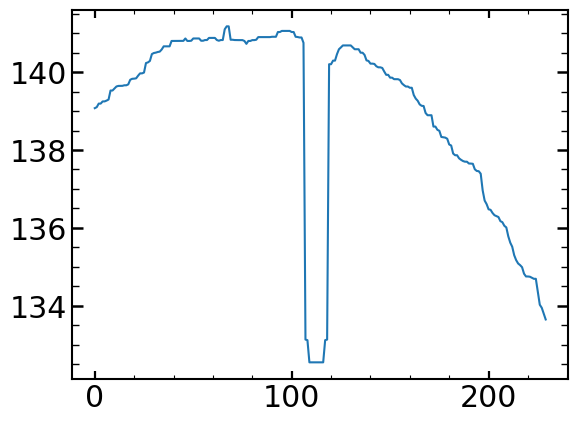

In [18]:
# shape of the continuum in the test region, from a single exposure
y_median_single_spot=y_median[3220-68:3450-68]

plt.plot(y_median_single_spot)

In [34]:
DATA_FOLDER='/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/rerun/rerun_3/'

for i in range(6):
    print(DATA_FOLDER+'v00'+str(run+i)+'/calExp-LA0'+str(run+i)+'r1.fits')
    
run=17072
DATA_FOLDER='/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/May_2019_run3/rerun/rerun_3/arc/calExp/2019-05-06'

data=fits.open(DATA_FOLDER+'/v00'+str(run+0)+'/calExp-LA0'+str(run+0)+'r1.fits')
scidata=data[1].data

/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/rerun/rerun_3/v0017072/calExp-LA017072r1.fits
/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/rerun/rerun_3/v0017073/calExp-LA017073r1.fits
/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/rerun/rerun_3/v0017074/calExp-LA017074r1.fits
/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/rerun/rerun_3/v0017075/calExp-LA017075r1.fits
/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/rerun/rerun_3/v0017076/calExp-LA017076r1.fits
/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/rerun/rerun_3/v0017077/calExp-LA017077r1.fits


In [36]:
# extract the single fier from the local data
single_fiber_extracted_local_summed=scidata[single_fiber_extracted_dimensions[1]:single_fiber_extracted_dimensions[1]+single_fiber_extracted_dimensions[3],
                                            single_fiber_extracted_dimensions[0]:single_fiber_extracted_dimensions[0]+single_fiber_extracted_dimensions[2]]

# extract the single fier from the local data, extended the width of the fiber trace 
extension=11
single_fiber_extracted_local_summed_extended=np.sum(scidata[single_fiber_extracted_dimensions[1]:single_fiber_extracted_dimensions[1]+single_fiber_extracted_dimensions[3],
                                            single_fiber_extracted_dimensions[0]-extension:single_fiber_extracted_dimensions[0]+extension+single_fiber_extracted_dimensions[2]],axis=1)

print(single_fiber_extracted_summed.shape)
print(single_fiber_extracted_local_summed_extended.shape)

(4019,)
(4019,)


Fiber: 4
single_fiber_extracted_dimensions: [1603   57   12 4019]
summing fiber between pixels: [1582, 1636]
stack_to_extract_normalization_factor: 0.01973952884789977
Central position of the spot 55 is: [1610, 2334]
size of stamp is: [30]
0:[2319, 2349, 1595, 1625]
1:[2318, 2348, 1595, 1625]
2:[2317, 2347, 1596, 1626]
3:[2317, 2347, 1596, 1626]
xposmin,xposmax,yposmin,yposmax:[1531, 1691, 2217, 2447]
overall_median is: 4.059441566467285
renormalizing fiber between: [51, 105]
[5, 35, 65, 95]
(30, 30)


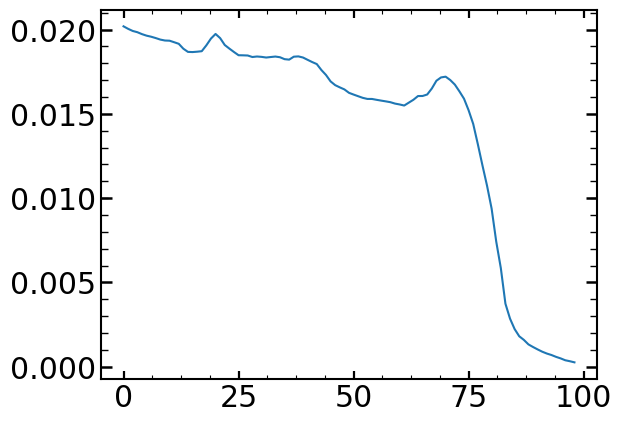

In [146]:
image_index=55
    
# set the dataframe used here 
finalHgAr=finalHgAr_May2019

# HAVE TO DO LOCAL RENORMALIZATION

which_fiber_starting_at_0=list_of_fiber_IDs.index(finalHgAr.loc[image_index]['fiber'])

print("Fiber: "+str(which_fiber_starting_at_0))

# shape of continuum
y_median=np.load('/Users/nevencaplar/Documents/PFS/ReducedData/TransferData/y_median_fiber_'+str(which_fiber_starting_at_0)+'.npy')
# spectrum summed after subtraction 
single_fiber_extracted_subtracted_summed=np.load('/Users/nevencaplar/Documents/PFS/ReducedData/TransferData/single_fiber_extracted_subtracted_summed_fiber_'+str(which_fiber_starting_at_0)+'.npy')
# spectrum summed without subtraction 
single_fiber_extracted_summed=np.load('/Users/nevencaplar/Documents/PFS/ReducedData/TransferData/single_fiber_extracted_summed_fiber_'+str(which_fiber_starting_at_0)+'.npy')
# dimension of the fiber
single_fiber_extracted_dimensions=np.load('/Users/nevencaplar/Documents/PFS/ReducedData/TransferData/single_fiber_extracted_dimensions_fiber_'+str(which_fiber_starting_at_0)+'.npy')
# extend y_median to 4176
y_median=np.concatenate((y_median,np.zeros((scidata_single.shape[0]-single_fiber_extracted_dimensions[3]-single_fiber_extracted_dimensions[1]))))

run=17071+24
if run in [17071,17072,17073,17074,17075,17076]:
    DATA_FOLDER='/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/May_2019_run3/rerun/rerun_3/arc/calExp/2019-05-06/'
else:
    DATA_FOLDER='/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/rerun/rerun_1/detrend/calExp/2019-05-06/'

data=fits.open(DATA_FOLDER+'v00'+str(run+0)+'/calExp-LA0'+str(run+0)+'r1.fits')
scidata=np.zeros_like(data[1].data)
maskdata=np.zeros_like(scidata)
vardata=np.zeros_like(scidata)  

for i in range(5):
    data=fits.open(DATA_FOLDER+'v00'+str(run+i)+'/calExp-LA0'+str(run+i)+'r1.fits')
    # round it a bit because sometimes the values are off by like 0.00001
    exposure_defocus=np.round(data[0].header['W_ENFCAX'],2)
    scidata_single=data[1].data
    maskdata_single=data[2].data
    vardata_single=data[3].data
    scidata=scidata+scidata_single
    maskdata=maskdata+maskdata_single
    vardata=vardata+vardata_single

#################    
# to get connection between the extraction of the flux on the cluster and local machine 
#################
#single_fiber_extracted_local_summed=np.sum(scidata[single_fiber_extracted_dimensions[1]:single_fiber_extracted_dimensions[1]+single_fiber_extracted_dimensions[3],
#                                            single_fiber_extracted_dimensions[0]:single_fiber_extracted_dimensions[0]+single_fiber_extracted_dimensions[2]],axis=1)

print('single_fiber_extracted_dimensions: '+str(single_fiber_extracted_dimensions))

# sum along the fiber in a box, everything
extension=21
single_fiber_extracted_local_summed_extended=np.sum(scidata[single_fiber_extracted_dimensions[1]:single_fiber_extracted_dimensions[1]+single_fiber_extracted_dimensions[3],
                                            single_fiber_extracted_dimensions[0]-extension:single_fiber_extracted_dimensions[0]+extension+single_fiber_extracted_dimensions[2]],axis=1)

print('summing fiber between pixels: '+str([single_fiber_extracted_dimensions[0]-extension,single_fiber_extracted_dimensions[0]+extension+single_fiber_extracted_dimensions[2]]))

res=[]
#for i in range(1,100):
#    res.append(np.percentile(single_fiber_extracted_summed,i)/np.percentile(single_fiber_extracted_local_summed,i))

# take only central parts (1000:3000)
for i in range(1,100):
    res.append(np.percentile(y_median[1000:3000],i)/np.percentile(single_fiber_extracted_local_summed_extended[1000:3000],i))

plt.plot(res)

stack_to_extract_normalization_factor=np.median(res[20:21])
print('stack_to_extract_normalization_factor: '+str(stack_to_extract_normalization_factor))
    


# central position as deduced from focused images
center_pos=[int(np.array(finalHgAr.loc[image_index,['xc','yc']].values)[0]),int(np.array(finalHgAr.loc[image_index,['xc','yc']].values)[1])]
print('Central position of the spot '+str(image_index)+' is: '+str(center_pos))


# have to set manually if in focus
if np.abs(exposure_defocus)==0:
    size=20
else:
    size=sizes_of_stamps[defocus_values==exposure_defocus]
size_of_stamp=size

print('size of stamp is: '+str(size_of_stamp))

center_pos_new=centering_algorithm(scidata,center_pos[0],center_pos[1],size_of_stamp)

#xposmin=int(np.round(center_pos_new[0]-size-10))
#xposmax=int(np.round(center_pos_new[0]+size+10))
#yposmin=int(np.round(center_pos_new[1]-size-45))
#yposmax=int(np.round(center_pos_new[1]+size+45))

xposmin=int(np.round(center_pos_new[0]-70-10))
xposmax=int(np.round(center_pos_new[0]+70+10))
yposmin=int(np.round(center_pos_new[1]-70-45))
yposmax=int(np.round(center_pos_new[1]+70+45))

size_of_stamp
print('xposmin,xposmax,yposmin,yposmax:'+str([xposmin,xposmax,yposmin,yposmax]))

# if you are on the edge, stop at the edge
if xposmin<0:
    xposmin=0
if xposmax>4096:
    xposmax=4096

scidata_cut=scidata[yposmin:yposmax,xposmin:xposmax]
maskdata_cut=maskdata[yposmin:yposmax,xposmin:xposmax]
vardata_cut=vardata[yposmin:yposmax,xposmin:xposmax]

# shape of the continuum in the test region, from a single exposure
# 68 is where the fiber (i.e., y_median) starts
y_median_renormalized=y_median*(1/stack_to_extract_normalization_factor)
y_median_single_spot_renormalized=y_median_renormalized[yposmin-single_fiber_extracted_dimensions[1]:yposmax-single_fiber_extracted_dimensions[1]]

scidata_cut_original=np.copy(scidata_cut)

#################
# removal of continuum - estimating
#################

# estimating local background
sci_upper_cut=scidata_cut[len(scidata_cut[:,0])-70:len(scidata_cut[:,0])-5]
sci_lower_cut=scidata_cut[5:70]

overall_median_lower_left=stats.sigma_clipped_stats(sci_lower_cut[:,:25].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
overall_median_lower_right=stats.sigma_clipped_stats(sci_lower_cut[:,:-25:].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
overall_median_upper_left=stats.sigma_clipped_stats(sci_upper_cut[:,:25].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
overall_median_upper_right=stats.sigma_clipped_stats(sci_upper_cut[:,:-25:].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
list_of_medians=[overall_median_lower_left,overall_median_lower_right,overall_median_upper_left,overall_median_upper_right]
overall_median=np.array(list_of_medians)[np.abs(list_of_medians)==np.min(np.abs(list_of_medians))][0]
print('overall_median is: '+str(overall_median))

#scidata_cut_median_subtracted=scidata_cut-overall_median
scidata_cut_median_subtracted=scidata_cut
scidata_cut_original_median_subtracted=np.copy(scidata_cut_median_subtracted)

   
# estimating fiber profile

midpoint=scidata_cut_median_subtracted.shape[0]/2
sci_central_cut=scidata_cut_median_subtracted[int(midpoint-size/2):int(midpoint+size/2)]
mask_central_cut=maskdata_cut[int(midpoint-size/2):int(midpoint+size/2)]
sci_central_cut_masked= np.ma.array(sci_central_cut, mask=mask_central_cut)
fiber_profile=np.ma.mean(sci_central_cut_masked,axis=0)

# get the central part of the fiber, the one that correspond to the trace
# 76 - have to deduce where on the detector you are taking the data from 
# 9 - comes from the width of the subtraction
# do I need only central, what if I use everything
fiber_profile_central=fiber_profile[single_fiber_extracted_dimensions[0]-xposmin-extension:single_fiber_extracted_dimensions[0]-xposmin+extension+single_fiber_extracted_dimensions[2]]

print('renormalizing fiber between: '+str([single_fiber_extracted_dimensions[0]-xposmin-extension,single_fiber_extracted_dimensions[0]-xposmin+extension+single_fiber_extracted_dimensions[2]]))

# stack_to_extract_normalization_factor ratio between the stack and a single image
fiber_profile_central_renormalized=fiber_profile/np.sum(fiber_profile_central)


#################
# removal of continuum NEW- actual removal
#################
scidata_cut_large_removed=np.copy(scidata_cut_median_subtracted)
maskdata_cut_large_removed=maskdata_cut
vardata_cut_large_removed=vardata_cut

try:
    for j in range(scidata_cut_large_removed.shape[1]):    
        scidata_cut_large_removed[0:int(scidata_cut.shape[0]/1),j]=scidata_cut_large_removed[0:int(scidata_cut.shape[0]/1),j]-fiber_profile_central_renormalized[j]*y_median_single_spot_renormalized
except:
    print('No subtraction!!!')
    pass

############################ 
# cutting final image
# allow for 5 pixels change, to capture wings of the donut
#################
y_min_for_scidata_cut_large_removed=int(scidata_cut_large_removed.shape[0]/2-size_of_stamp/2-5)
y_max_for_scidata_cut_large_removed=int(scidata_cut_large_removed.shape[0]/2+size_of_stamp/2+5)

scidata_cut_large_removed_prestep=scidata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]
maskdata_cut_large_removed_prestep=maskdata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]   
vardata_cut_large_removed_prestep=vardata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]

y_pos_for_final_cut=np.round(np.median(np.where(np.max(scidata_cut_large_removed_prestep*np.abs((1-maskdata_cut_large_removed_prestep)),axis=1)>300)))
x_pos_for_final_cut=np.round(np.median(np.where(np.max(scidata_cut_large_removed_prestep*np.abs((1-maskdata_cut_large_removed_prestep)),axis=0)>300)))

y_lower_limit_for_final_cut=int(y_pos_for_final_cut-size_of_stamp/2)
y_upper_limit_for_final_cut=int(y_pos_for_final_cut+size_of_stamp/2)
x_lower_limit_for_final_cut=int(x_pos_for_final_cut-size_of_stamp/2)
x_upper_limit_for_final_cut=int(x_pos_for_final_cut+size_of_stamp/2)

print([y_lower_limit_for_final_cut,y_upper_limit_for_final_cut,x_lower_limit_for_final_cut,x_upper_limit_for_final_cut])

scidata_final_cut=scidata_cut_large_removed_prestep[y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]
maskdata_final_cut=maskdata_cut_large_removed_prestep[int(y_pos_for_final_cut-size_of_stamp/2):int(y_pos_for_final_cut+size_of_stamp/2),int(x_pos_for_final_cut-size_of_stamp/2):int(x_pos_for_final_cut+size_of_stamp/2)]
vardata_final_cut=vardata_cut_large_removed_prestep[int(y_pos_for_final_cut-size_of_stamp/2):int(y_pos_for_final_cut+size_of_stamp/2),int(x_pos_for_final_cut-size_of_stamp/2):int(x_pos_for_final_cut+size_of_stamp/2)]

############################ 
#select only exposures that have no cosmics inside
#################
#scidata_final_cut_no_CR=np.zeros_like(scidata_final_cut)
#vardata_final_cut_no_CR=np.zeros_like(scidata_final_cut)
#vardata=np.zeros_like(scidata)  
#for run_i in range(6):
#    if np.sum(list_of_mask_data[run_i][y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut])==0:
#        scidata_final_cut_no_CR+=list_of_sci_data[run_i][y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]
#        vardata_final_cut_no_CR+=list_of_var_data[run_i][y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]

print(scidata_final_cut.shape)

(-500, 21000)

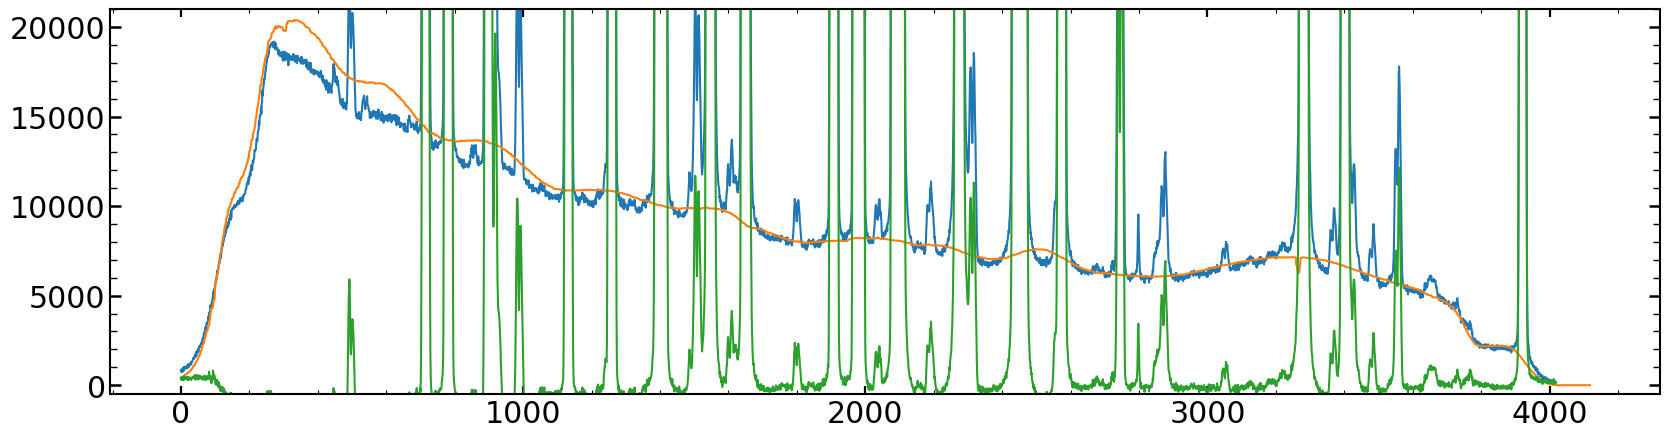

In [147]:
plt.figure(figsize=(20,5))
plt.plot(single_fiber_extracted_local_summed_extended)
plt.plot(y_median_renormalized)
plt.plot(single_fiber_extracted_local_summed_extended-y_median_renormalized[:len(single_fiber_extracted_local_summed_extended)])
plt.ylim(-500,21000)

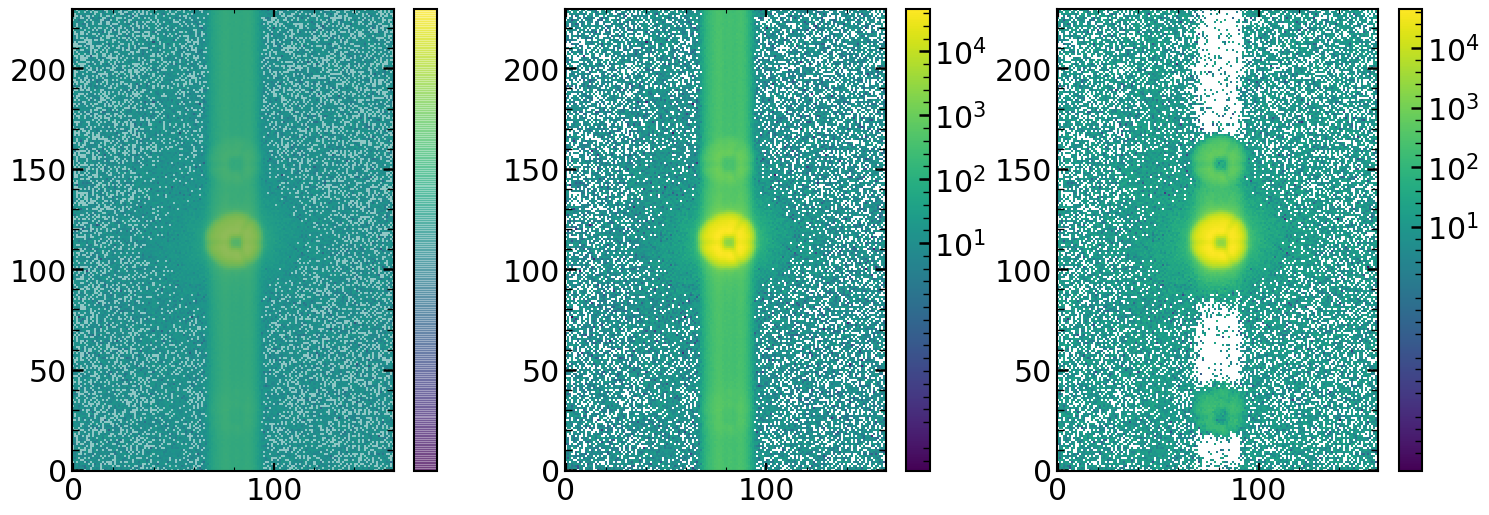

In [148]:
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.imshow(scidata_cut_original,norm=LogNorm(),origin='lower')
plt.imshow(maskdata_cut,origin='lower',alpha=.5)
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])
plt.subplot(132)
plt.imshow(scidata_cut_original_median_subtracted,norm=LogNorm(),origin='lower')
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])
plt.subplot(133)
plt.imshow(scidata_cut_large_removed,norm=LogNorm(),origin='lower')
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

In [149]:
run=17071
if run in [17071,17072,17073,17074,17075,17076]:
    DATA_FOLDER='/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/May_2019_run3/rerun/rerun_3/arc/calExp/2019-05-06/'
else:
    DATA_FOLDER='/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/rerun/rerun_1/detrend/calExp/2019-05-06/'

data=fits.open(DATA_FOLDER+'v00'+str(run+0)+'/calExp-LA0'+str(run+0)+'r1.fits')
scidata_focus=np.zeros_like(data[1].data)
maskdata=np.zeros_like(scidata_focus)
vardata=np.zeros_like(scidata)  

for i in range(5):
    data=fits.open(DATA_FOLDER+'v00'+str(run+i)+'/calExp-LA0'+str(run+i)+'r1.fits')
    # round it a bit because sometimes the values are off by like 0.00001
    exposure_defocus=np.round(data[0].header['W_ENFCAX'],2)
    scidata_single=data[1].data
    maskdata_single=data[2].data
    vardata_single=data[3].data
    scidata_focus=scidata_focus+scidata_single
    maskdata=maskdata+maskdata_single
    vardata=vardata+vardata_single

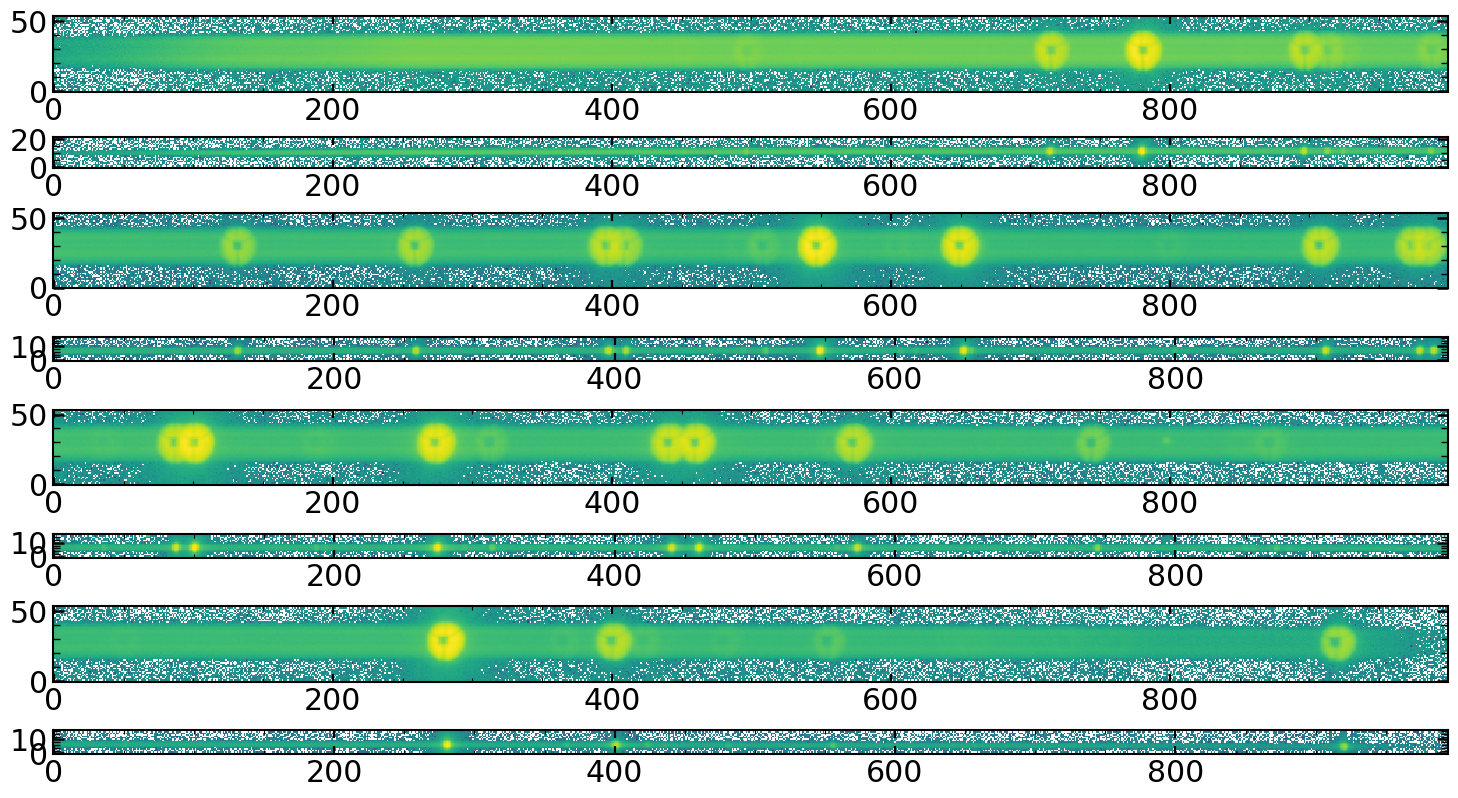

In [156]:
from scipy import ndimage
plt.figure(figsize=(18,10))
plt.subplot(811)
plt.imshow(np.transpose(scidata[single_fiber_extracted_dimensions[1]:single_fiber_extracted_dimensions[1]+1000,1582:1636]),norm=LogNorm())
plt.subplot(813)
plt.imshow(np.transpose(scidata[single_fiber_extracted_dimensions[1]+1000:single_fiber_extracted_dimensions[1]+2000,1582:1636]),norm=LogNorm())
plt.subplot(815)
plt.imshow(np.transpose(scidata[single_fiber_extracted_dimensions[1]+2000:single_fiber_extracted_dimensions[1]+3000,1582:1636]),norm=LogNorm())
plt.subplot(817)
plt.imshow(np.transpose(scidata[single_fiber_extracted_dimensions[1]+3000:single_fiber_extracted_dimensions[1]+4000,1582:1636]),norm=LogNorm())


plt.subplot(812)
plt.imshow(np.transpose(scidata_focus[single_fiber_extracted_dimensions[1]:single_fiber_extracted_dimensions[1]+1000,1603-5:1615+5])*8.70,norm=LogNorm())
plt.subplot(814)
plt.imshow(np.transpose(scidata_focus[single_fiber_extracted_dimensions[1]+1000:single_fiber_extracted_dimensions[1]+2000-5,1603:1615+5]*8.70),norm=LogNorm())
plt.subplot(816)
plt.imshow(np.transpose(scidata_focus[single_fiber_extracted_dimensions[1]+2000:single_fiber_extracted_dimensions[1]+3000-5,1603:1615+5]*8.70),norm=LogNorm())
plt.subplot(818)
plt.imshow(np.transpose(scidata_focus[single_fiber_extracted_dimensions[1]+3000:single_fiber_extracted_dimensions[1]+4000-5,1603:1615+5]*8.70),norm=LogNorm())

8.851071507541311


(0, 23000)

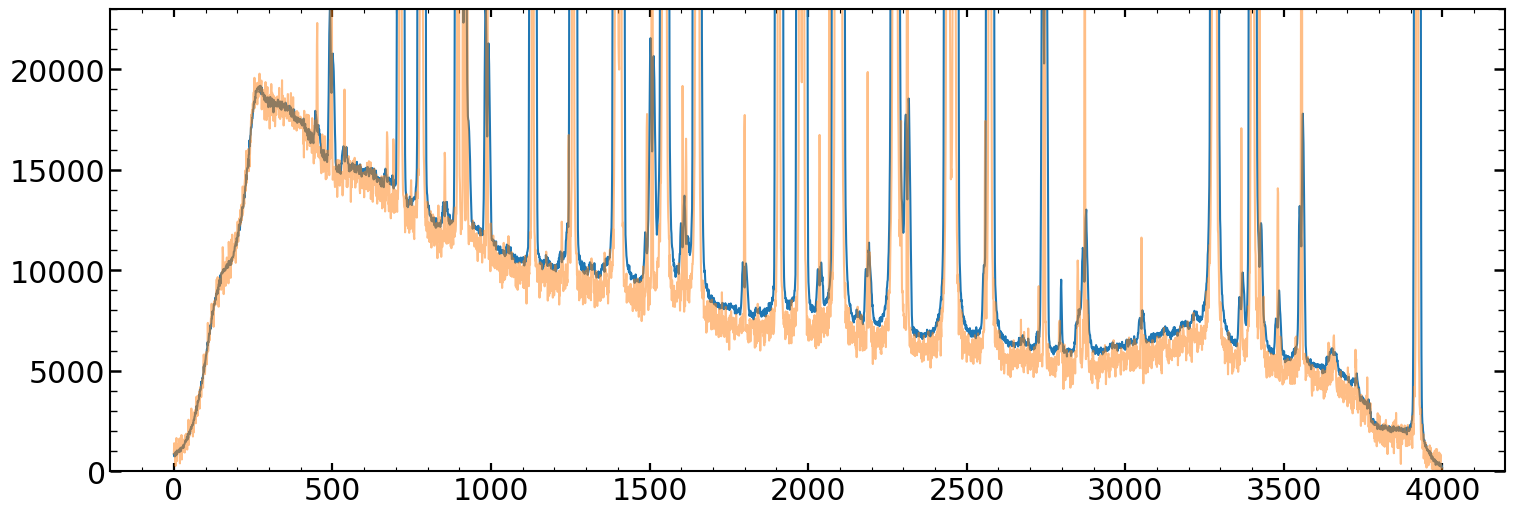

In [155]:
plt.figure(figsize=(18,6))
print(1/(np.median(np.sum(scidata_focus[single_fiber_extracted_dimensions[1]:single_fiber_extracted_dimensions[1]+4000,1582:1636],axis=1))/np.median(np.sum(scidata[single_fiber_extracted_dimensions[1]:single_fiber_extracted_dimensions[1]+4000,1603-5:1620],axis=1))))
plt.plot(np.sum(scidata[single_fiber_extracted_dimensions[1]:single_fiber_extracted_dimensions[1]+4000,1582:1636],axis=1))
plt.plot(8.70*np.sum(scidata_focus[single_fiber_extracted_dimensions[1]:single_fiber_extracted_dimensions[1]+4000,1603-5:1615+5],axis=1),alpha=0.5)
plt.ylim(0,23000)

In [111]:
# https://github.com/Subaru-PFS/drp_stella/blob/master/python/pfs/drp/stella/fitContinuum.py

iterations=10
numKnots=30

def fitContinuumImpl(values)
indices = np.arange(len(values), dtype=np.float)
knots, binned = binData(indices, values, good,numKnots)
interp = scipy.interpolate.splrep(indices,values,knots=numKnots)
fit = np.array(interp.interpolate(indices))

for ii in range(iterations):
    fit = self._fitContinuumImpl(spectrum.spectrum, good)
    diff = spectrum.spectrum - fit
    lq, uq = np.percentile(diff[good], [25.0, 75.0])
    stdev = 0.741*(uq - lq)
    good = np.isfinite(diff) & (np.abs(diff) <= self.config.rejection*stdev)
    if np.all(good == oldGood):
        break
    oldGood = good

8.796288482775118

(0, 23000)

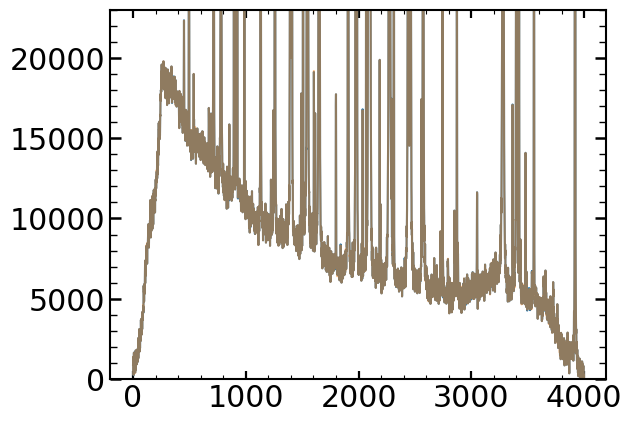

In [180]:
import scipy
values=8.70*np.sum(scidata_focus[single_fiber_extracted_dimensions[1]:single_fiber_extracted_dimensions[1]+4000,1603-5:1615+5],axis=1)
numKnots=30

indices = np.arange(len(values), dtype=np.float)
interp = scipy.interpolate.splrep(indices,values,k=3,s=10000000)
y2=scipy.interpolate.splev(indices,interp)

plt.plot(y2)
plt.plot(values,alpha=0.5)
plt.ylim(0,23000)

(0, 23000)

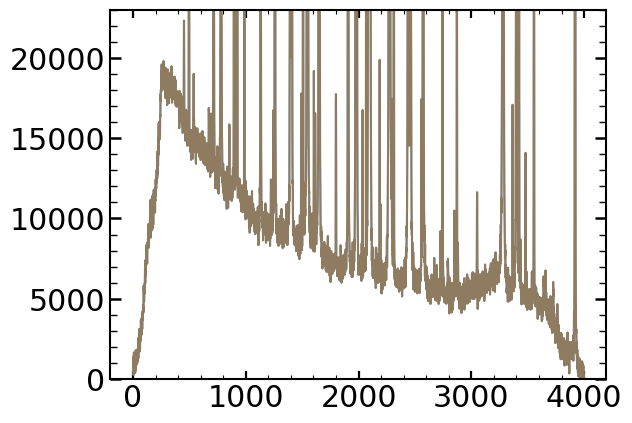

In [177]:
interp[0].shape

(4004,)

[0.9084070841018831, 0.9642878268963984, 0.9805443988870091, 1.0104587963552072, 0.9913975190714738, 1.115694253013778]


(2273.1434040827908, 5037.202953615857)

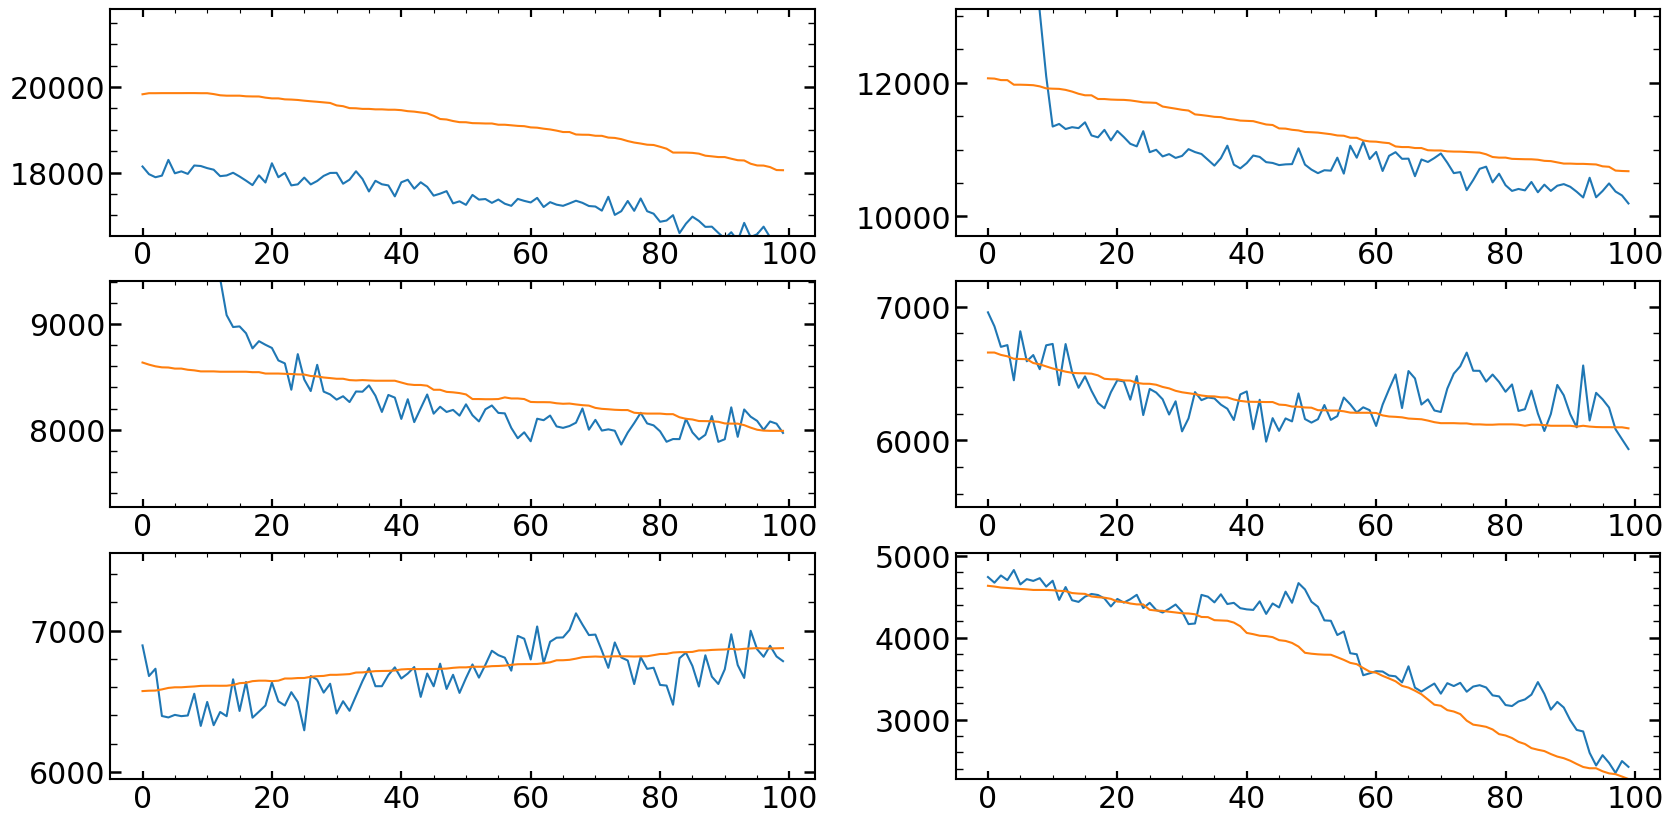

In [83]:
# 6 selected regions
region1_continuum=single_fiber_extracted_local_summed_extended[400-68:400-68+100]
region2_continuum=single_fiber_extracted_local_summed_extended[1060-68:1060-68+100]
region3_continuum=single_fiber_extracted_local_summed_extended[1730-68:1730-68+100]
region4_continuum=single_fiber_extracted_local_summed_extended[2670-68:2670-68+100]
region5_continuum=single_fiber_extracted_local_summed_extended[3130-68:3130-68+100]
region6_continuum=single_fiber_extracted_local_summed_extended[3750-68:3750-68+100]

region1_y_median=y_median_renormalized[400-68:400-68+100]
region2_y_median=y_median_renormalized[1060-68:1060-68+100]
region3_y_median=y_median_renormalized[1730-68:1730-68+100]
region4_y_median=y_median_renormalized[2670-68:2670-68+100]
region5_y_median=y_median_renormalized[3130-68:3130-68+100]
region6_y_median=y_median_renormalized[3750-68:3750-68+100]

print([np.median(region1_continuum)/np.median(region1_y_median),np.median(region2_continuum)/np.median(region2_y_median),np.median(region3_continuum)/np.median(region3_y_median),
 np.median(region4_continuum)/np.median(region4_y_median),np.median(region5_continuum)/np.median(region5_y_median),np.median(region6_continuum)/np.median(region6_y_median)])

# show regions with continuum removed and continuum fits
plt.figure(figsize=(20,10))

plt.subplot(321)
plt.plot(region1_continuum)
plt.plot(region1_y_median*(1/1))
plt.ylim(np.percentile(region1_y_median,10)*0.9,np.percentile(region1_y_median,90)*1.1)

plt.subplot(322)
plt.plot(region2_continuum)
plt.plot(region2_y_median)
plt.ylim(np.percentile(region2_y_median,10)*0.9,np.percentile(region2_y_median,90)*1.1)

plt.subplot(323)
plt.plot(region3_continuum)
plt.plot(region3_y_median)
plt.ylim(np.percentile(region3_y_median,10)*0.9,np.percentile(region3_y_median,90)*1.1)

plt.subplot(324)
plt.plot(region4_continuum)
plt.plot(region4_y_median)
plt.ylim(np.percentile(region4_y_median,10)*0.9,np.percentile(region4_y_median,90)*1.1)

plt.subplot(325)
plt.plot(region5_continuum)
plt.plot(region5_y_median)
plt.ylim(np.percentile(region5_y_median,10)*0.9,np.percentile(region5_y_median,90)*1.1)

plt.subplot(326)
plt.plot(region6_continuum)
plt.plot(region6_y_median)
plt.ylim(np.percentile(region6_y_median,10)*0.9,np.percentile(region6_y_median,90)*1.1)

In [ ]:
if 